In [1]:
%reload_ext pretty_jupyter
#pip install pretty-jupyter
#jupyter nbconvert --to html --no-input --template pj sprawozdanie.ipynb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
import geopandas as gpd
import matplotlib.patches as mpatches
from scipy.stats import kendalltau, spearmanr
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import calinski_harabasz_score

## Wprowadzenie
Analiza warunków życia w różnych regionach jest kluczowa dla zrozumienia różnic społeczno-ekonomicznych oraz planowania polityki rozwoju regionalnego. W niniejszym badaniu skoncentrowano się na powiatach południowo-wschodniej Polski, obejmujących województwa małopolskie, podkarpackie i świętokrzyskie, wykorzystując metody porządkowania liniowego oraz analizę skupień do oceny i klasyfikacji warunków życia mieszkańców tych obszarów.<br><br>
W badaniu wykorzystano dane pochodzące z Banku Danych Lokalnych Głównego Urzędu Statystycznego (GUS), obejmujące rok 2023. Dobór zmiennych opisujących warunki życia (m.in. z zakresu rynku pracy, edukacji, demografii, zdrowia, infrastruktury, a także środowiska) został przeprowadzony na podstawie opracowania dotyczącego analizy tego regionu w roku 2019. W celu zapewnienia porównywalności wyników starano się możliwie wiernie odwzorować zestaw wskaźników użyty w tamtym badaniu. W tabeli przedstawiono wykorzystane zmienne.

| Zmienna  | <center>Nazwa zmiennej</center>                                                                           |   Jednostka   |  Charakter   |
|:--------:|-----------------------------------------------------------------------------------------------------------|:-------------:|:------------:|
|  $X_1$   | Stopa bezrobocia rejestrowanego                                                                           |       %       | destymulanta |
|  $X_2$   | Nowo zarejestrowane podmioty gospodarki narodowej w rejestrze REGON na 10 000 osób                        |     szt.      |  stymulanta  |
|  $X_3$   | Udział bezrobotnych pozostających bez pracy dłużej niż rok wśród wszystkich zarejestrowanych bezrobotnych |       %       | destymulanta |
|  $X_4$   | Przeciętne miesięczne wynagrodzenie brutto                                                                |      zł       |  stymulanta  |
|  $X_5$   | Saldo migracji ogółem na 1000 mieszkańców                                                                 |     osoby     |  stymulanta  |
|  $X_6$   | Współczynnik obciążenia demograficznego osobami starszymi                                                 |       %       | destymulanta |
|  $X_7$   | Ludność korzystająca z sieci kanalizacyjnej                                                               |       %       |  stymulanta  |
|  $X_8$   | Powierzchnia użytkowa mieszkania na osobę                                                                 | m<sup>2</sup> |  stymulanta  |
|  $X_9$   | Liczba osób na aptekę ogólnodostępną                                                                      |     osoby     | destymulanta |
| $X_{10}$ | Lekarze pracujący ogółem na 10 000 mieszkańców                                                            |     osoby     |  stymulanta  |
| $X_{11}$ | Przestępstwa stwierdzone na 1000 mieszkańców                                                              |     szt.      | destymulanta |
| $X_{12}$ | Liczba samochodów osobowych w przeliczeniu na 1000 mieszkańców powiatu                                    |     szt.      |  stymulanta  |
| $X_{13}$ | Długość dróg gminnych i powiatowych o twardej nawierzchni na 100km<sup>2</sup> powierzchni powiatu        |      km       |  stymulanta  |
| $X_{14}$ | Liczba wypadków drogowych w przeliczeniu na 100 000<br>mieszkańców powiatu                                |     szt.      | destymulanta |
| $X_{15}$ | Zanieczyszczenia gazowe w przeliczeniu na 1 km<sup>2</sup> powiatu                                        |       t       | destymulanta |
| $X_{16}$ | Parki, zieleńce i tereny zielone                                                                          |       %       |  stymulanta  |
| $X_{17}$ | Obszary prawnie chronione                                                                                 |       %       |  stymulanta  |
| $X_{18}$ | Współczynnik skolaryzacji brutto                                                                          |       %       |  stymulanta  |
| $X_{19}$ | Uczniowie na oddział w szkołach ogólnokształcących                                                        |     osoby     | destymulanta |

## Analiza i przygotowanie danych

Dla analizowanych cech wyznaczono podstawowe statystyki opisowe, wykresy rozkładów, a także zbadano poziom ich skorelowanie. Następnie dokonano zastąpienia wartości odstających, normalizacji zmiennych oraz zamiany destymulant na stymulanty.

### Statystyki zmiennych

In [3]:
df = pd.read_excel('dane.xlsx', header=1, index_col=0)

desc = df.describe().T
desc['skew'] = df.skew()
desc['kurtosis'] = df.kurtosis() + 3
desc['CV'] = abs(df.std() / df.mean() * 100)

desc = desc.drop(columns=['count'])
desc.columns = ['Średnia', 'Odch. std.', 'Minimum', '25%', '50%', '75%', 'Maksimum', 'Skośność', 'Kurtoza', 'CV']
desc.insert(0, 'Zmienna', [f"$X_{{{i+1}}}$" for i in range(len(desc))])
desc = desc.round(2)
styler = (
    desc.style
    .hide(axis="index")
    .set_properties(subset=['Zmienna'], **{'text-align': 'center'})
    .format("{:.2f}", subset=desc.columns[1:])
)
styler

### Rozkłady zmiennych

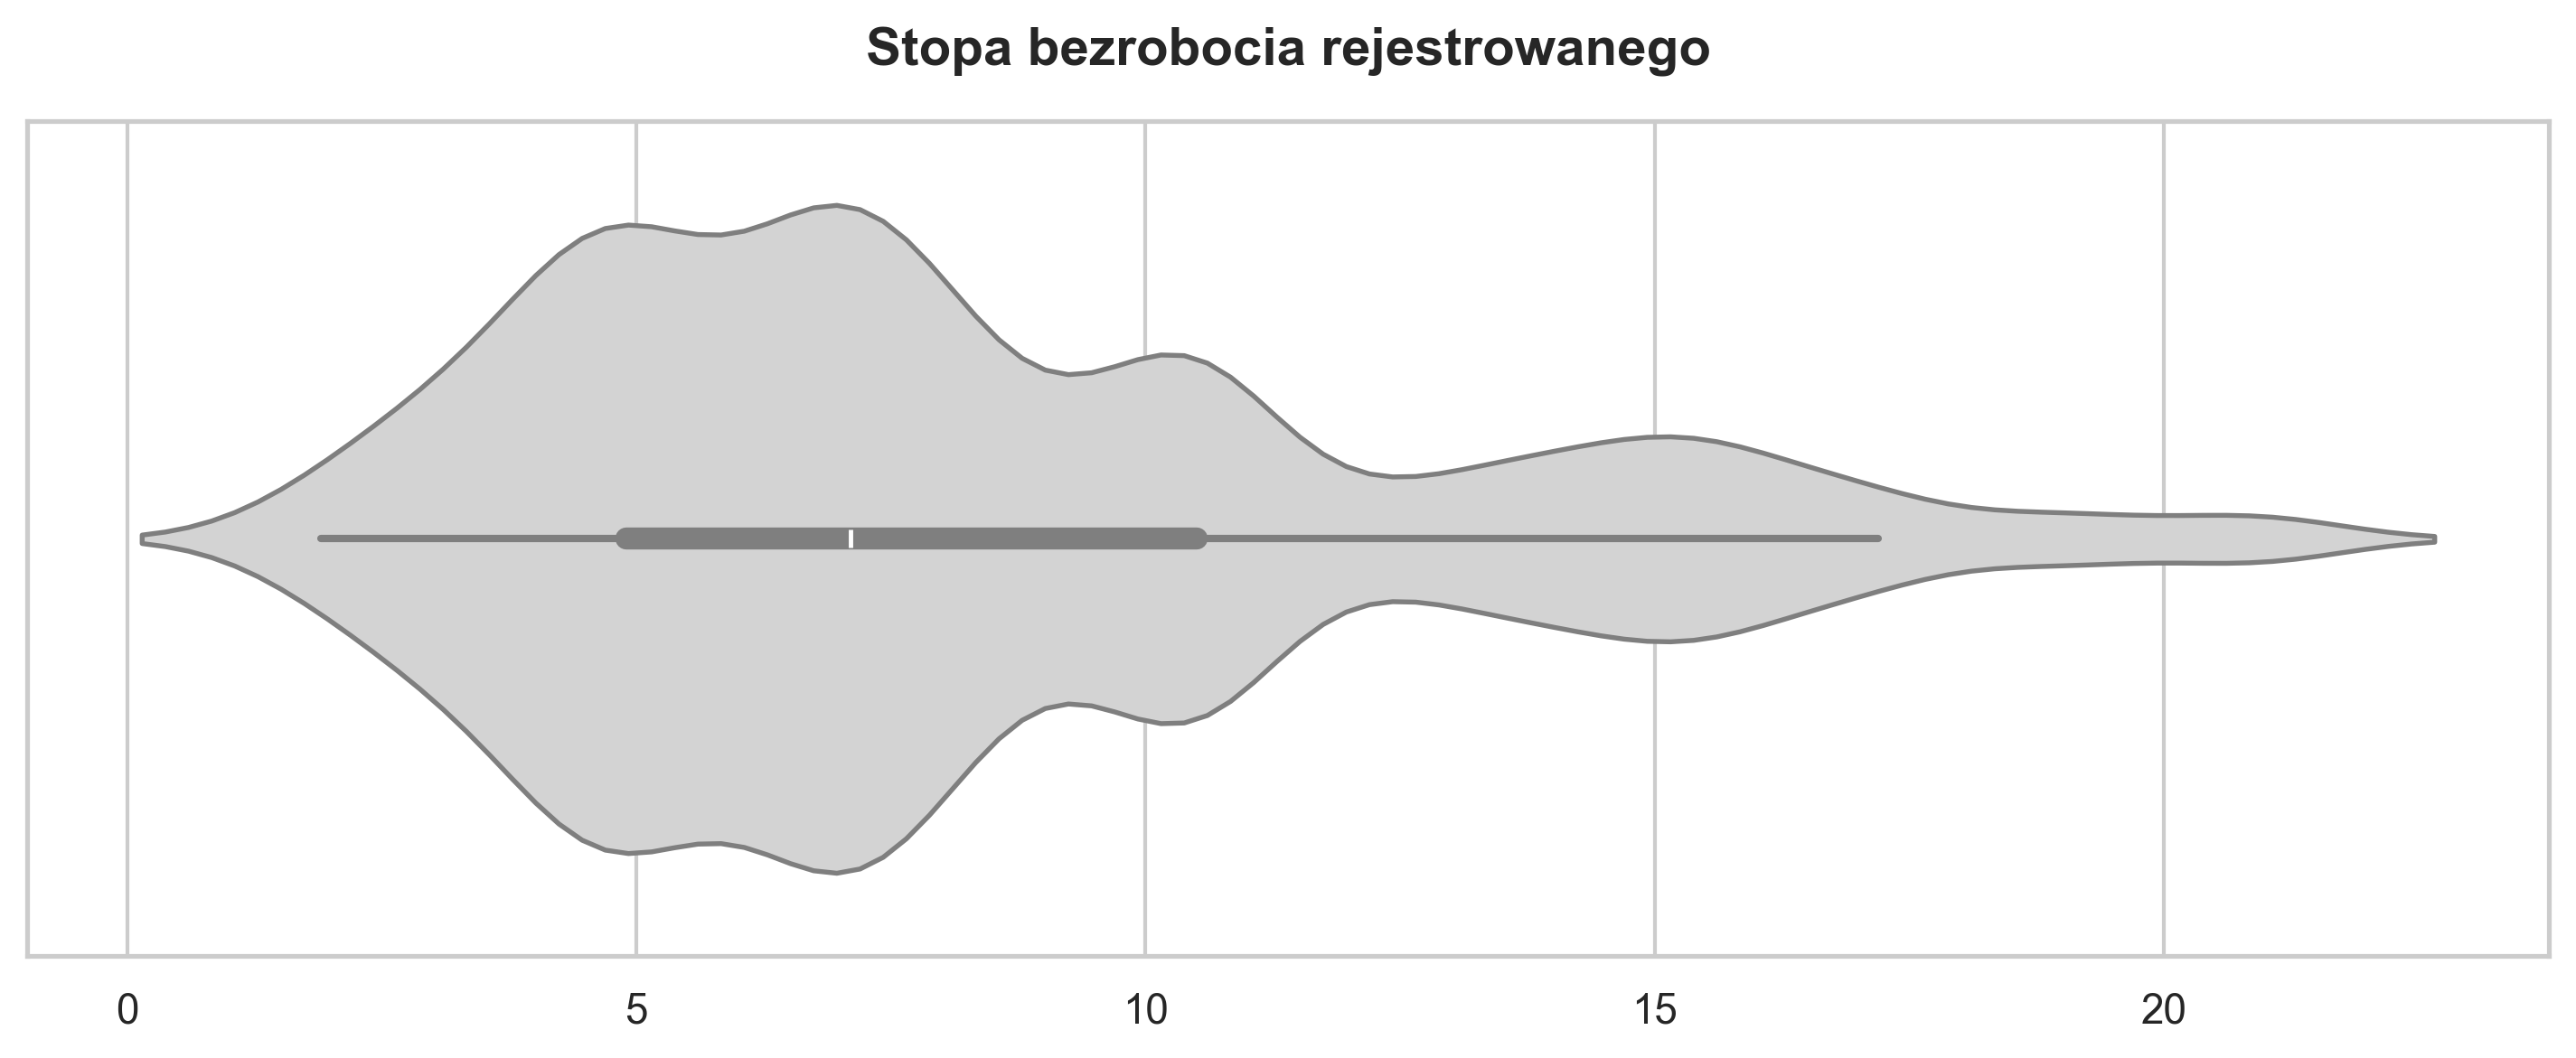

In [4]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[0],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Stopa bezrobocia rejestrowanego", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład stopy bezrobocia jest umiarkowanie prawoskośny, co sugeruje, że większość powiatów charakteryzuje się raczej niższą stopą bezrobocia, a wysokie wartości są rzadsze. Dość wysoka zmienność wskazuje na wyraźne zróżnicowanie sytuacji na rynku pracy w obrębie regionu południowo-wschodniej Polski.
<hr style="border: 0.5px solid black;">

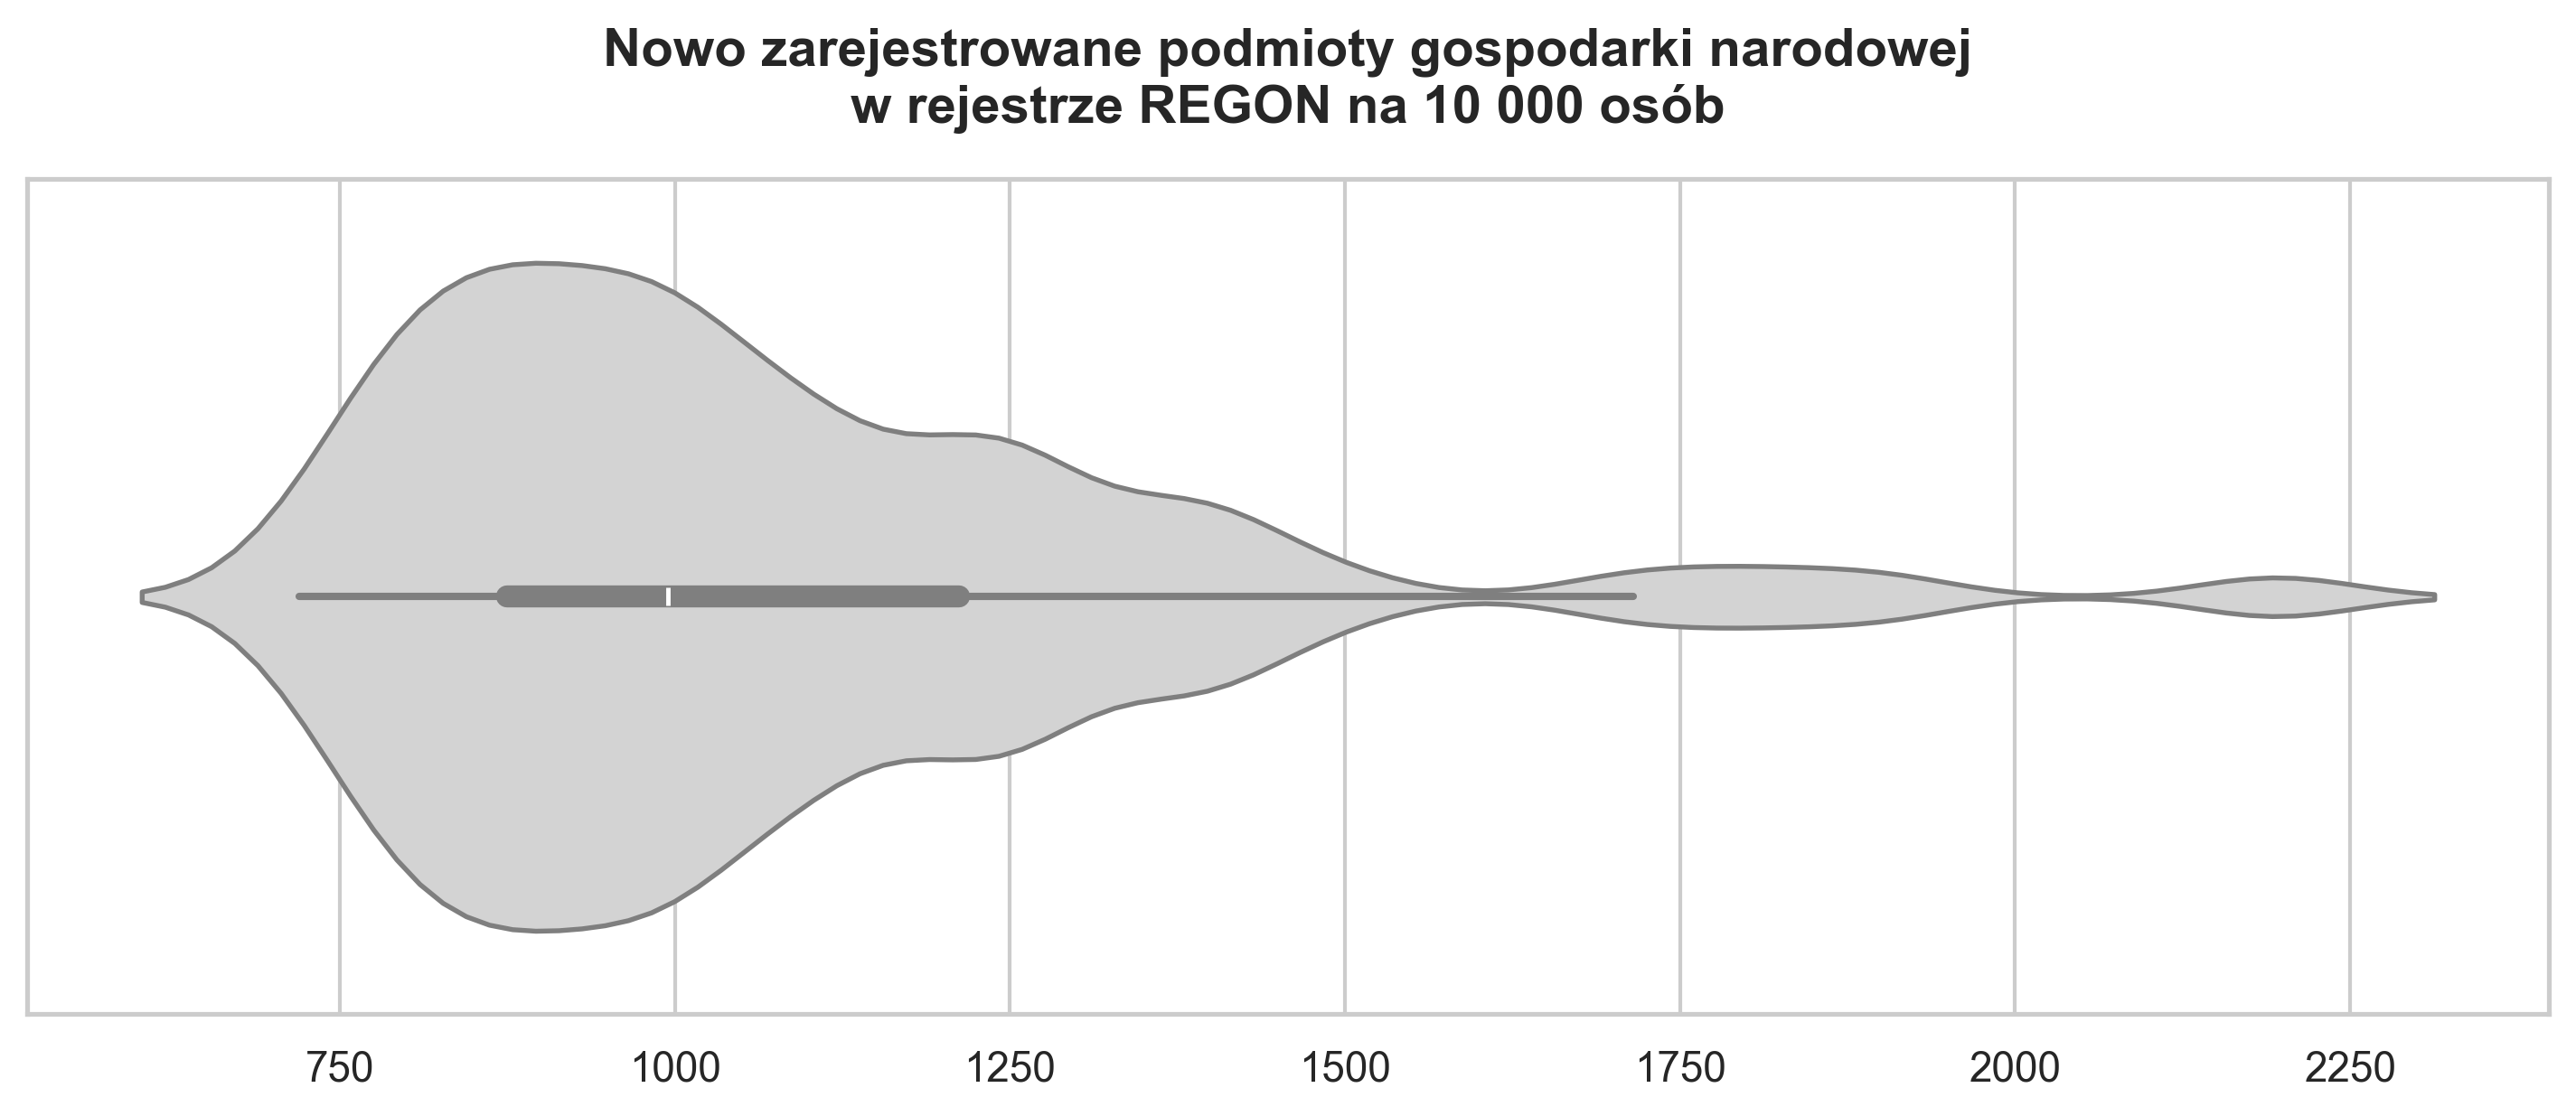

In [5]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[1],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Nowo zarejestrowane podmioty gospodarki narodowej\nw rejestrze REGON na 10 000 osób", fontsize=14, fontweight='bold', pad=15)
plt.show()

Zmienna opisująca nowo zarejestrowane podmioty gospodarcze ma rozkład prawoskośny, co oznacza, że w większości powiatów poziom przedsiębiorczości jest znacząco umiarkowany, a tylko dla nielicznych obszarów występują wysokie wartości tego wskaźnika. Może to świadczyć o dużych różnicach i skoncetrowaniu rozwoju gospodarczego wyłącznie w kluczowych obszarach regionu.
<hr style="border: 0.5px solid black;">

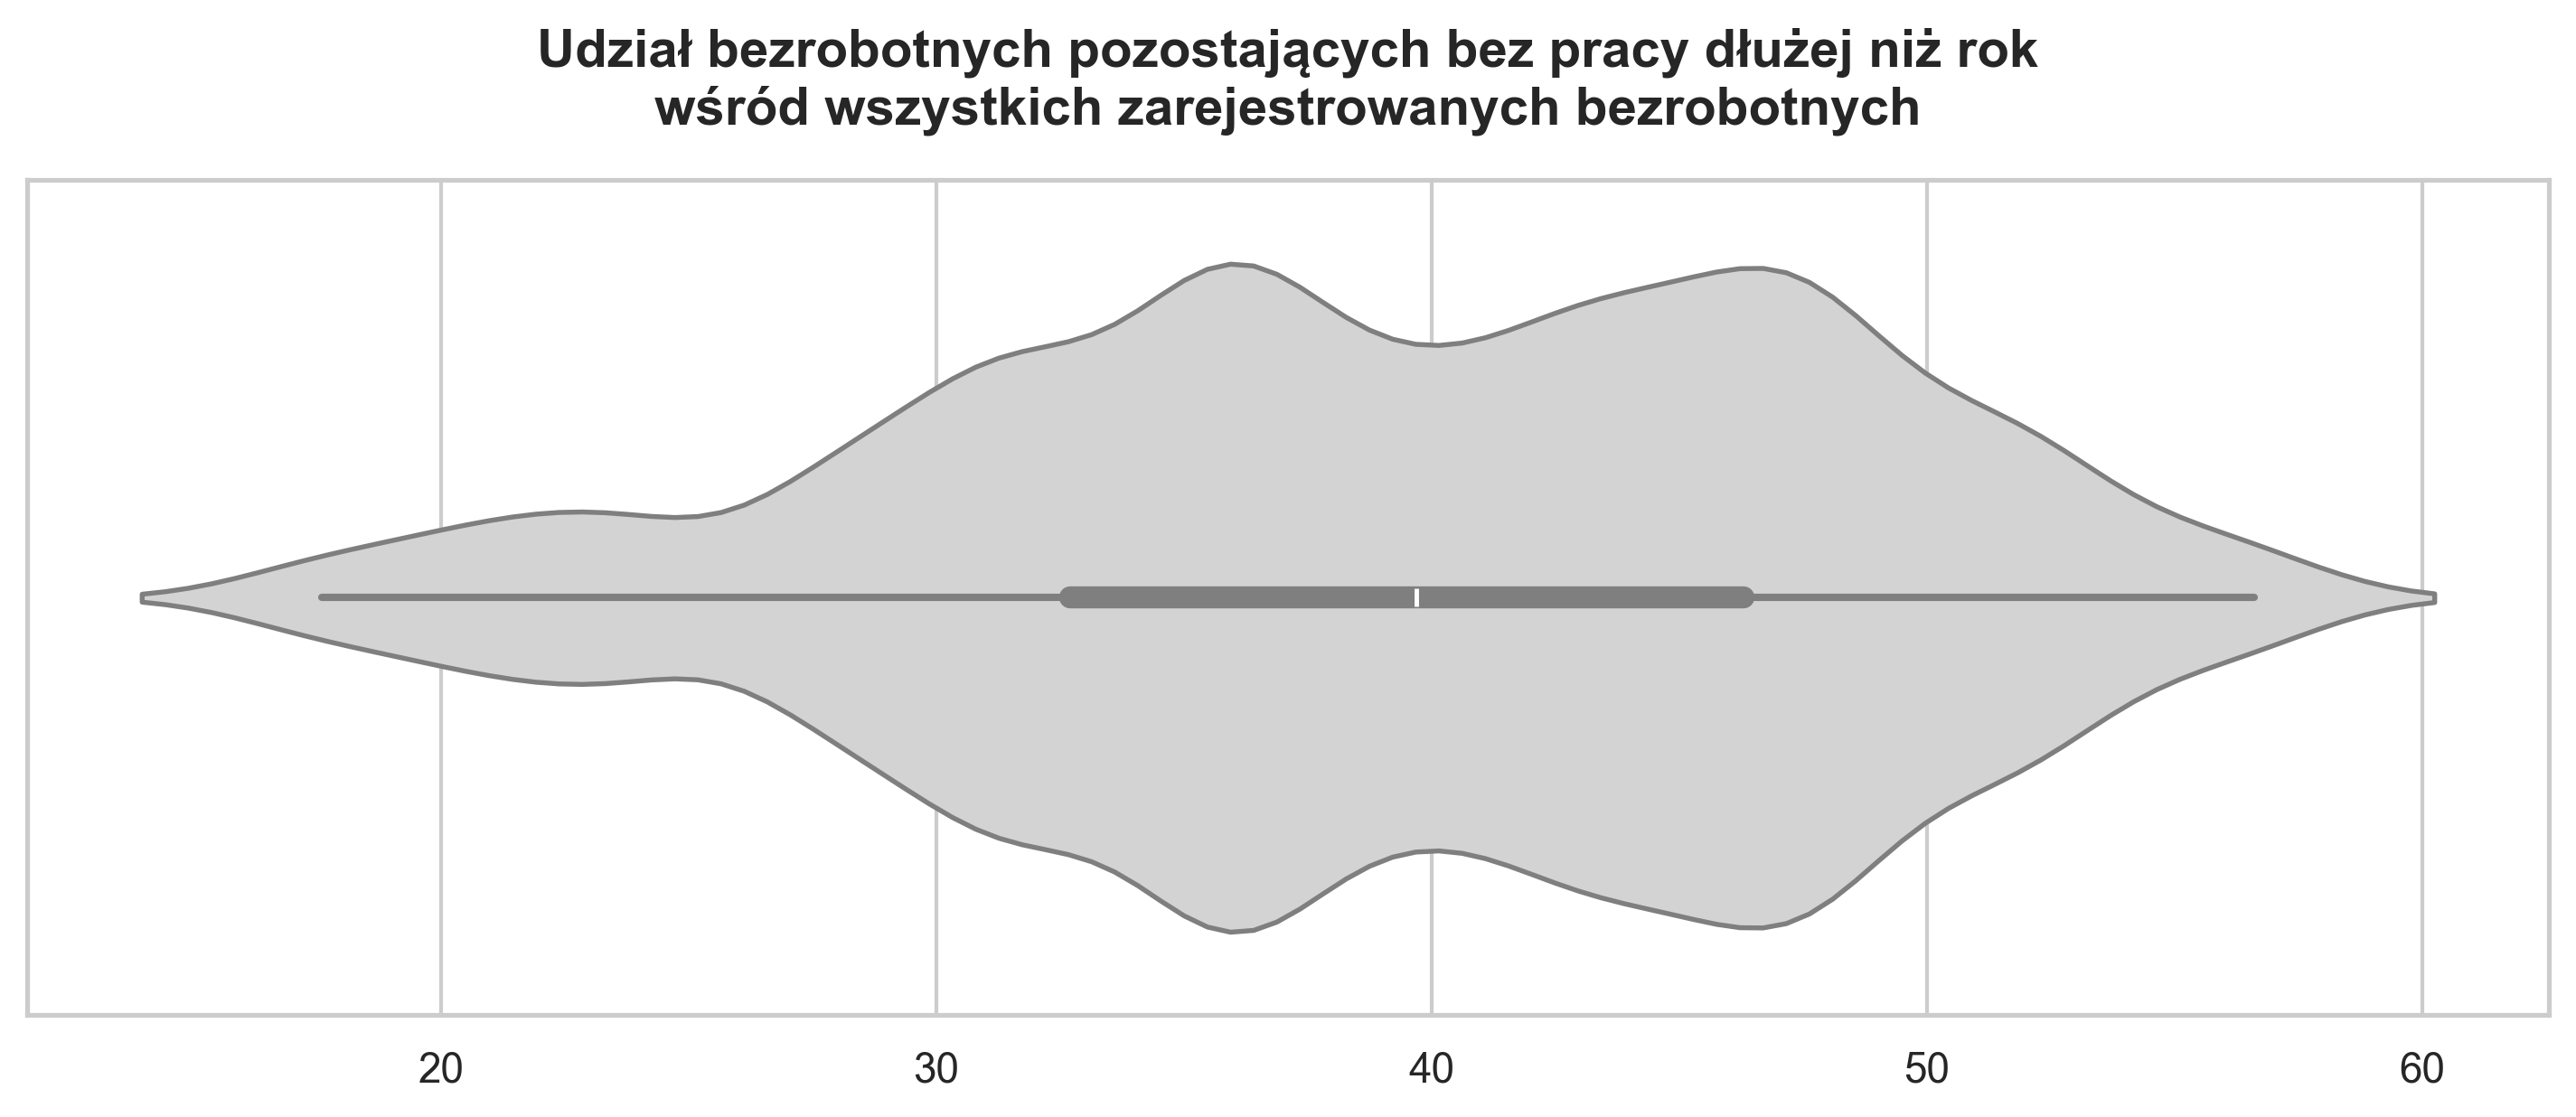

In [6]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[2],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Udział bezrobotnych pozostających bez pracy dłużej niż rok\nwśród wszystkich zarejestrowanych bezrobotnych", fontsize=14, fontweight='bold', pad=15)
plt.show()

Udział długotrwale bezrobotnych jest dość zbliżony dla większości powiatów, co sugeruje, że problem ten ma charakter dość równomierny. Brak większych odchyleń może wskazywać na utrwalony poziom bezrobocia strukturalnego w większości regionu.
<hr style="border: 0.5px solid black;">

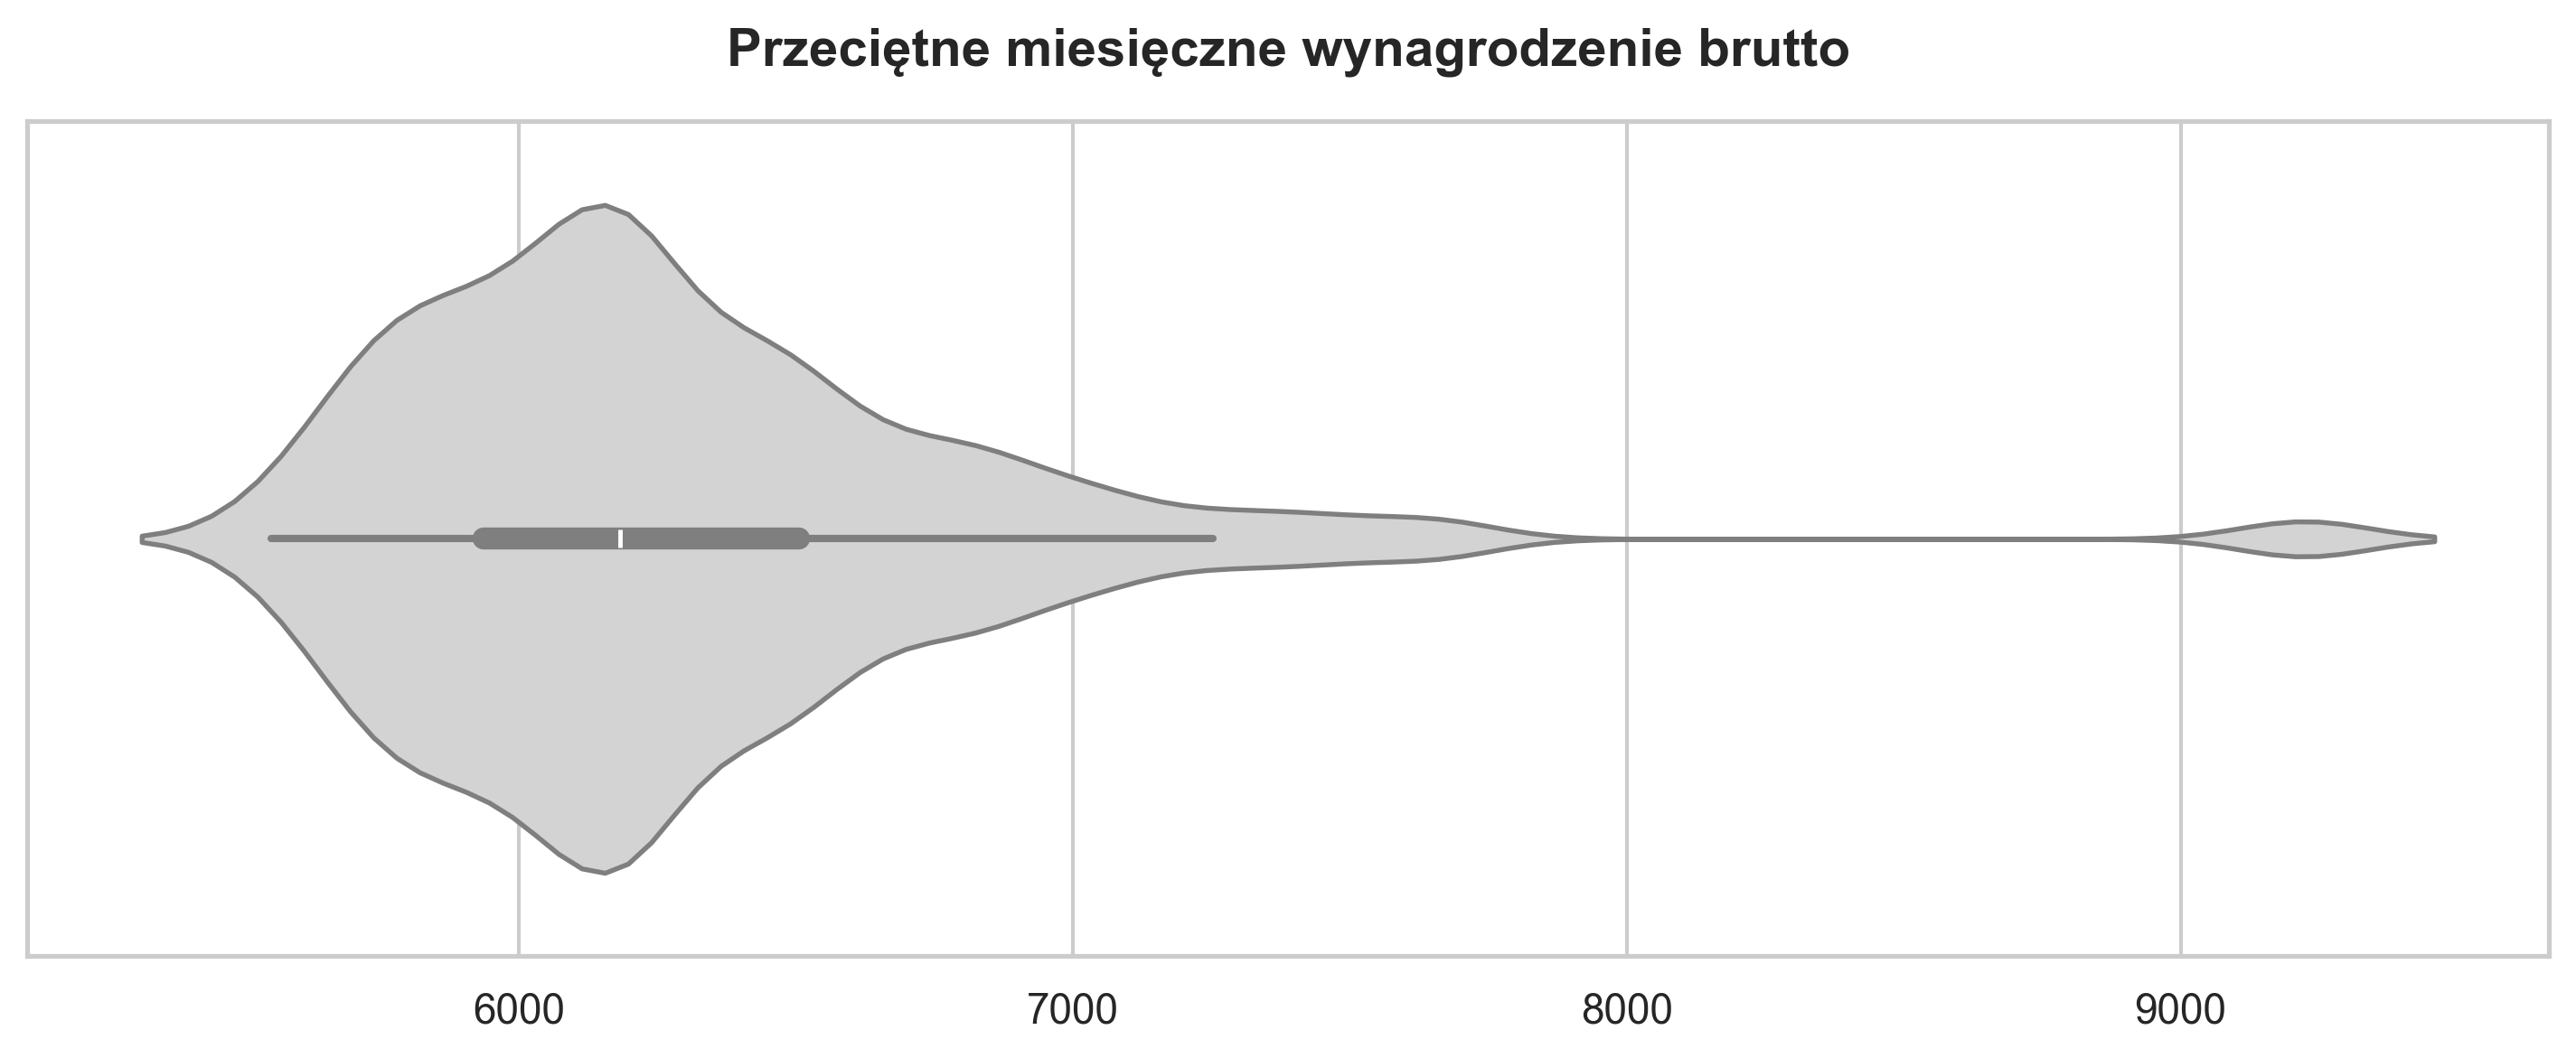

In [7]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[3],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Przeciętne miesięczne wynagrodzenie brutto", fontsize=14, fontweight='bold', pad=15)
plt.show()

Przęciętne wynagrodzenia są wysoce zbliżone między powiatami, jednak w kilku z nich notuje się wyraźnie wyższe płace. Sugeruje to stosunkowo jednolity poziom dochodów, z nielicznymi wyjątkami wynikającymi z obecności silniejszych ośrodków gospodarczych.
<hr style="border: 0.5px solid black;">

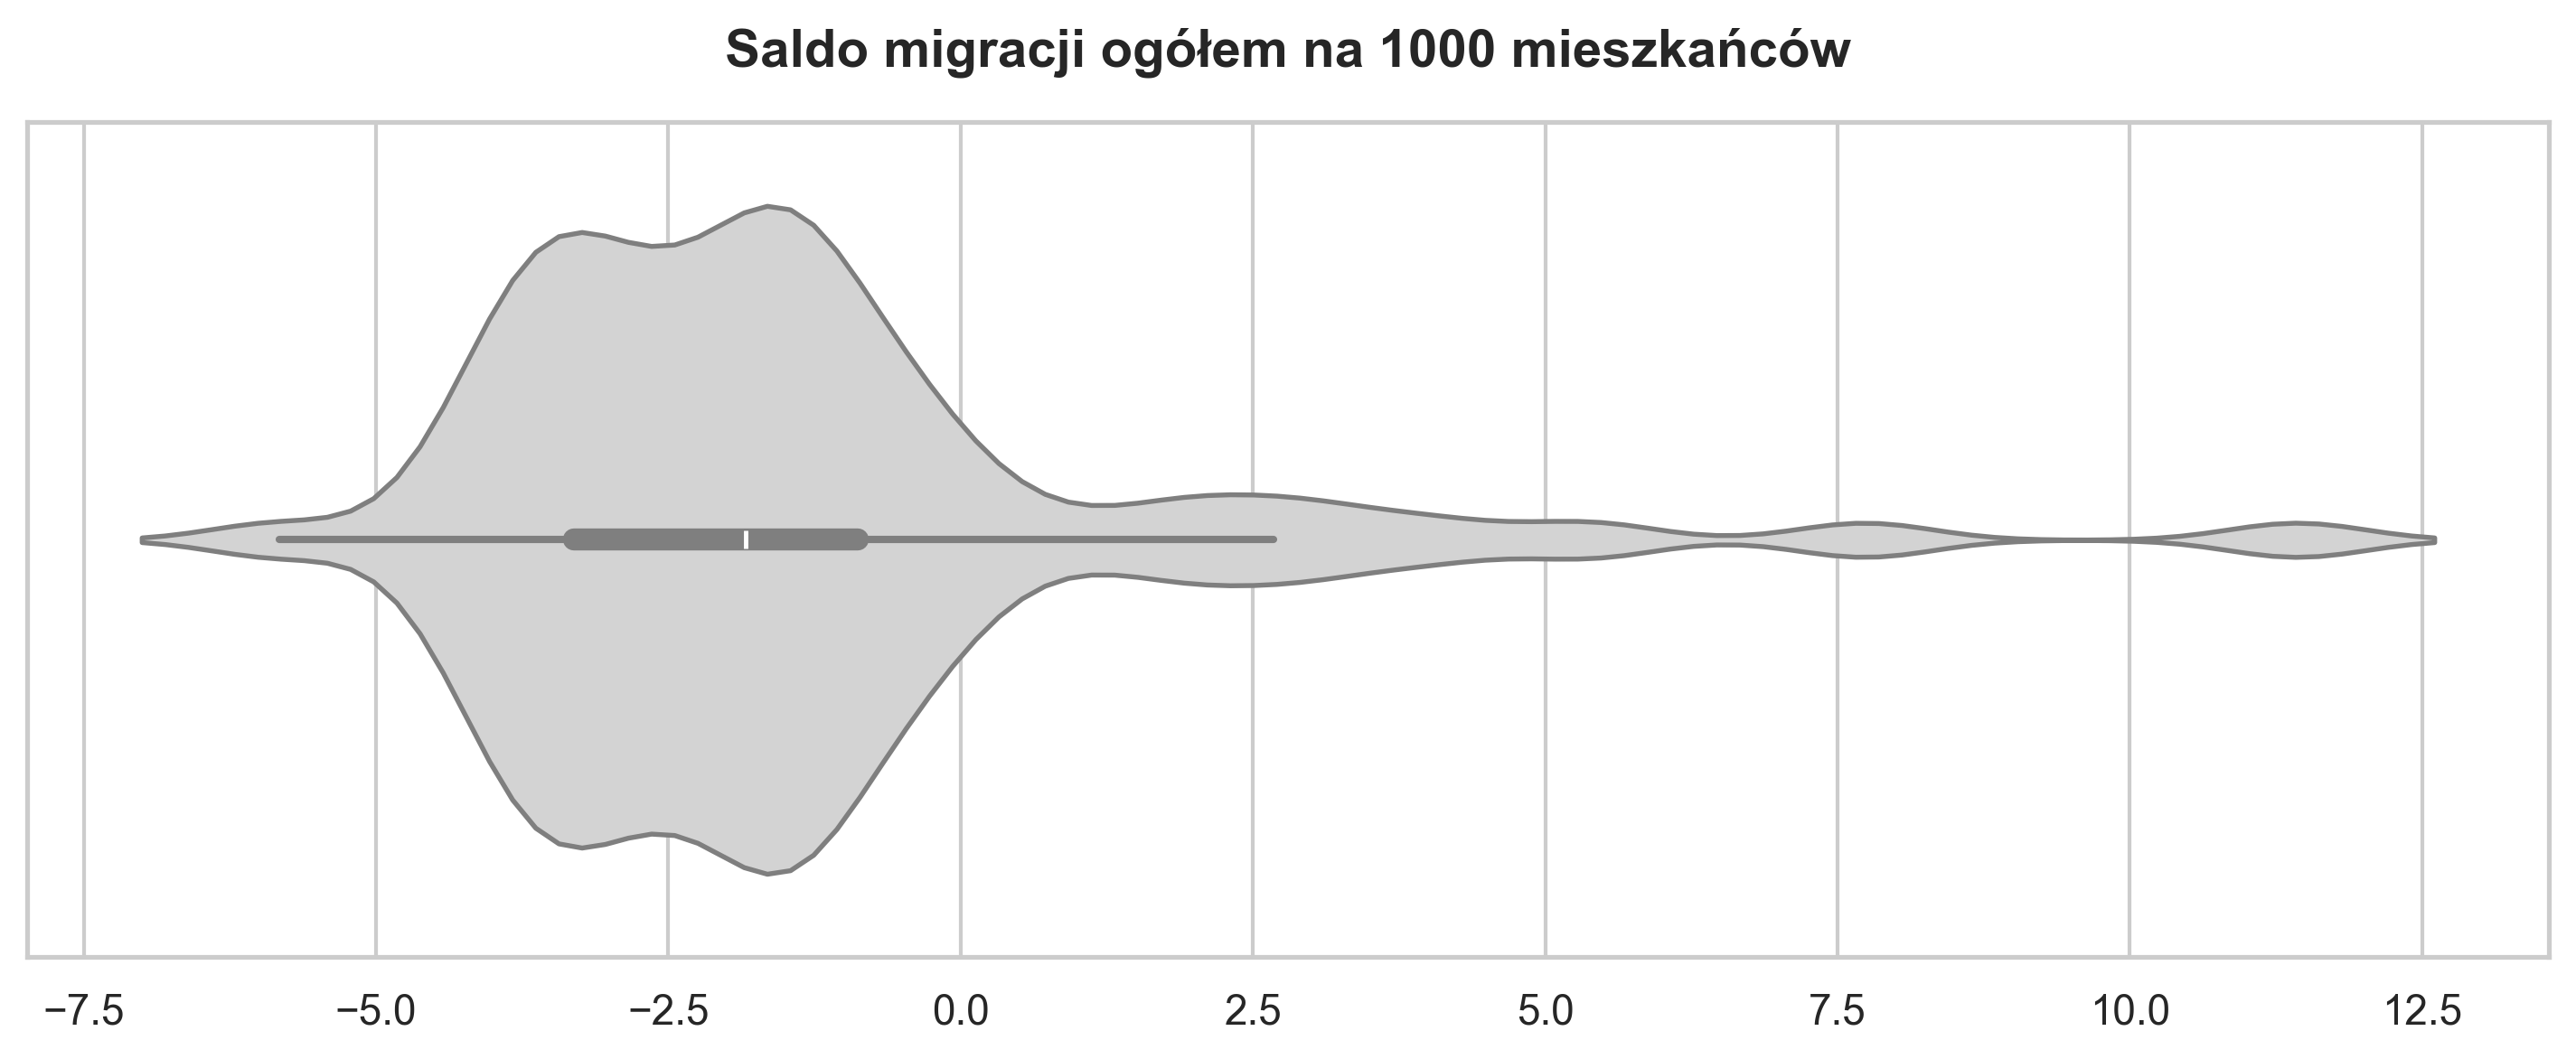

In [8]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[4],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Saldo migracji ogółem na 1000 mieszkańców", fontsize=14, fontweight='bold', pad=15)
plt.show()

Wskaźnik migracji ma silnie prawoskośny rozkład i wysoką zmienność, co świadczy o dużych różnicach w atrakcyjności powiatów. W części z nich obserwuje się wyraźny odpływ ludności, podczas gdy inne przyciągają znaczące liczby nowych mieszkańców.
<hr style="border: 0.5px solid black;">

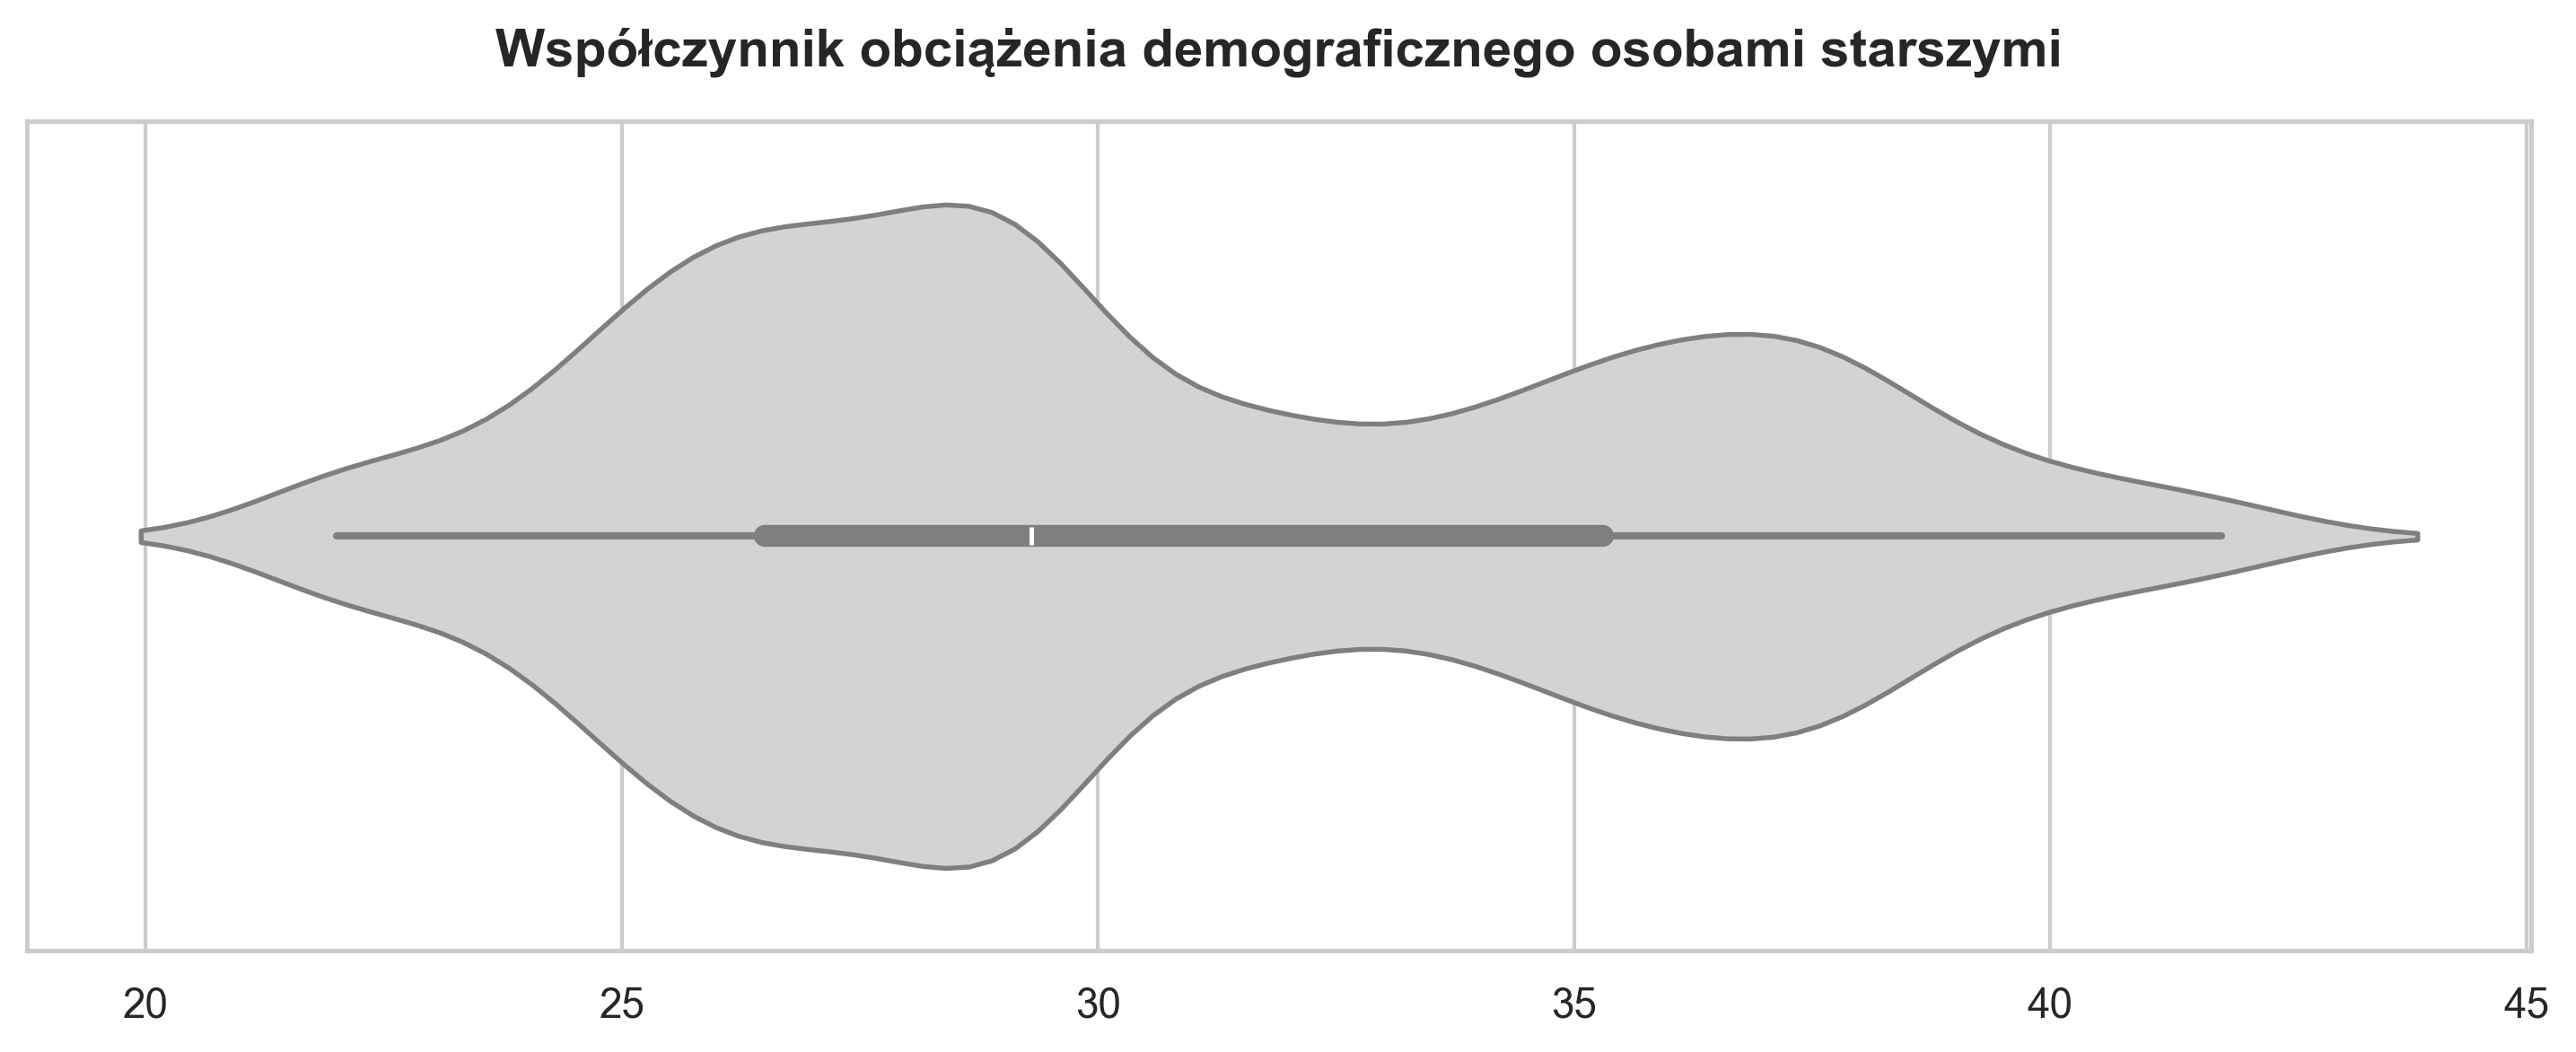

In [9]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[5],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2

)
plt.xlabel("")
plt.ylabel("")
plt.title("Współczynnik obciążenia demograficznego osobami starszymi", fontsize=14, fontweight='bold', pad=15)
plt.show()

Wskaźnik ten jest stosunkowo wyrównany w skali całego regionu, co oznacza, że proces starzenia się ludności przebiega podobnie w większości powiatów. Różnice między nimi są umiarkowane i nie wskazują na występowanie skrajnych przypadków.
<hr style="border: 0.5px solid black;">

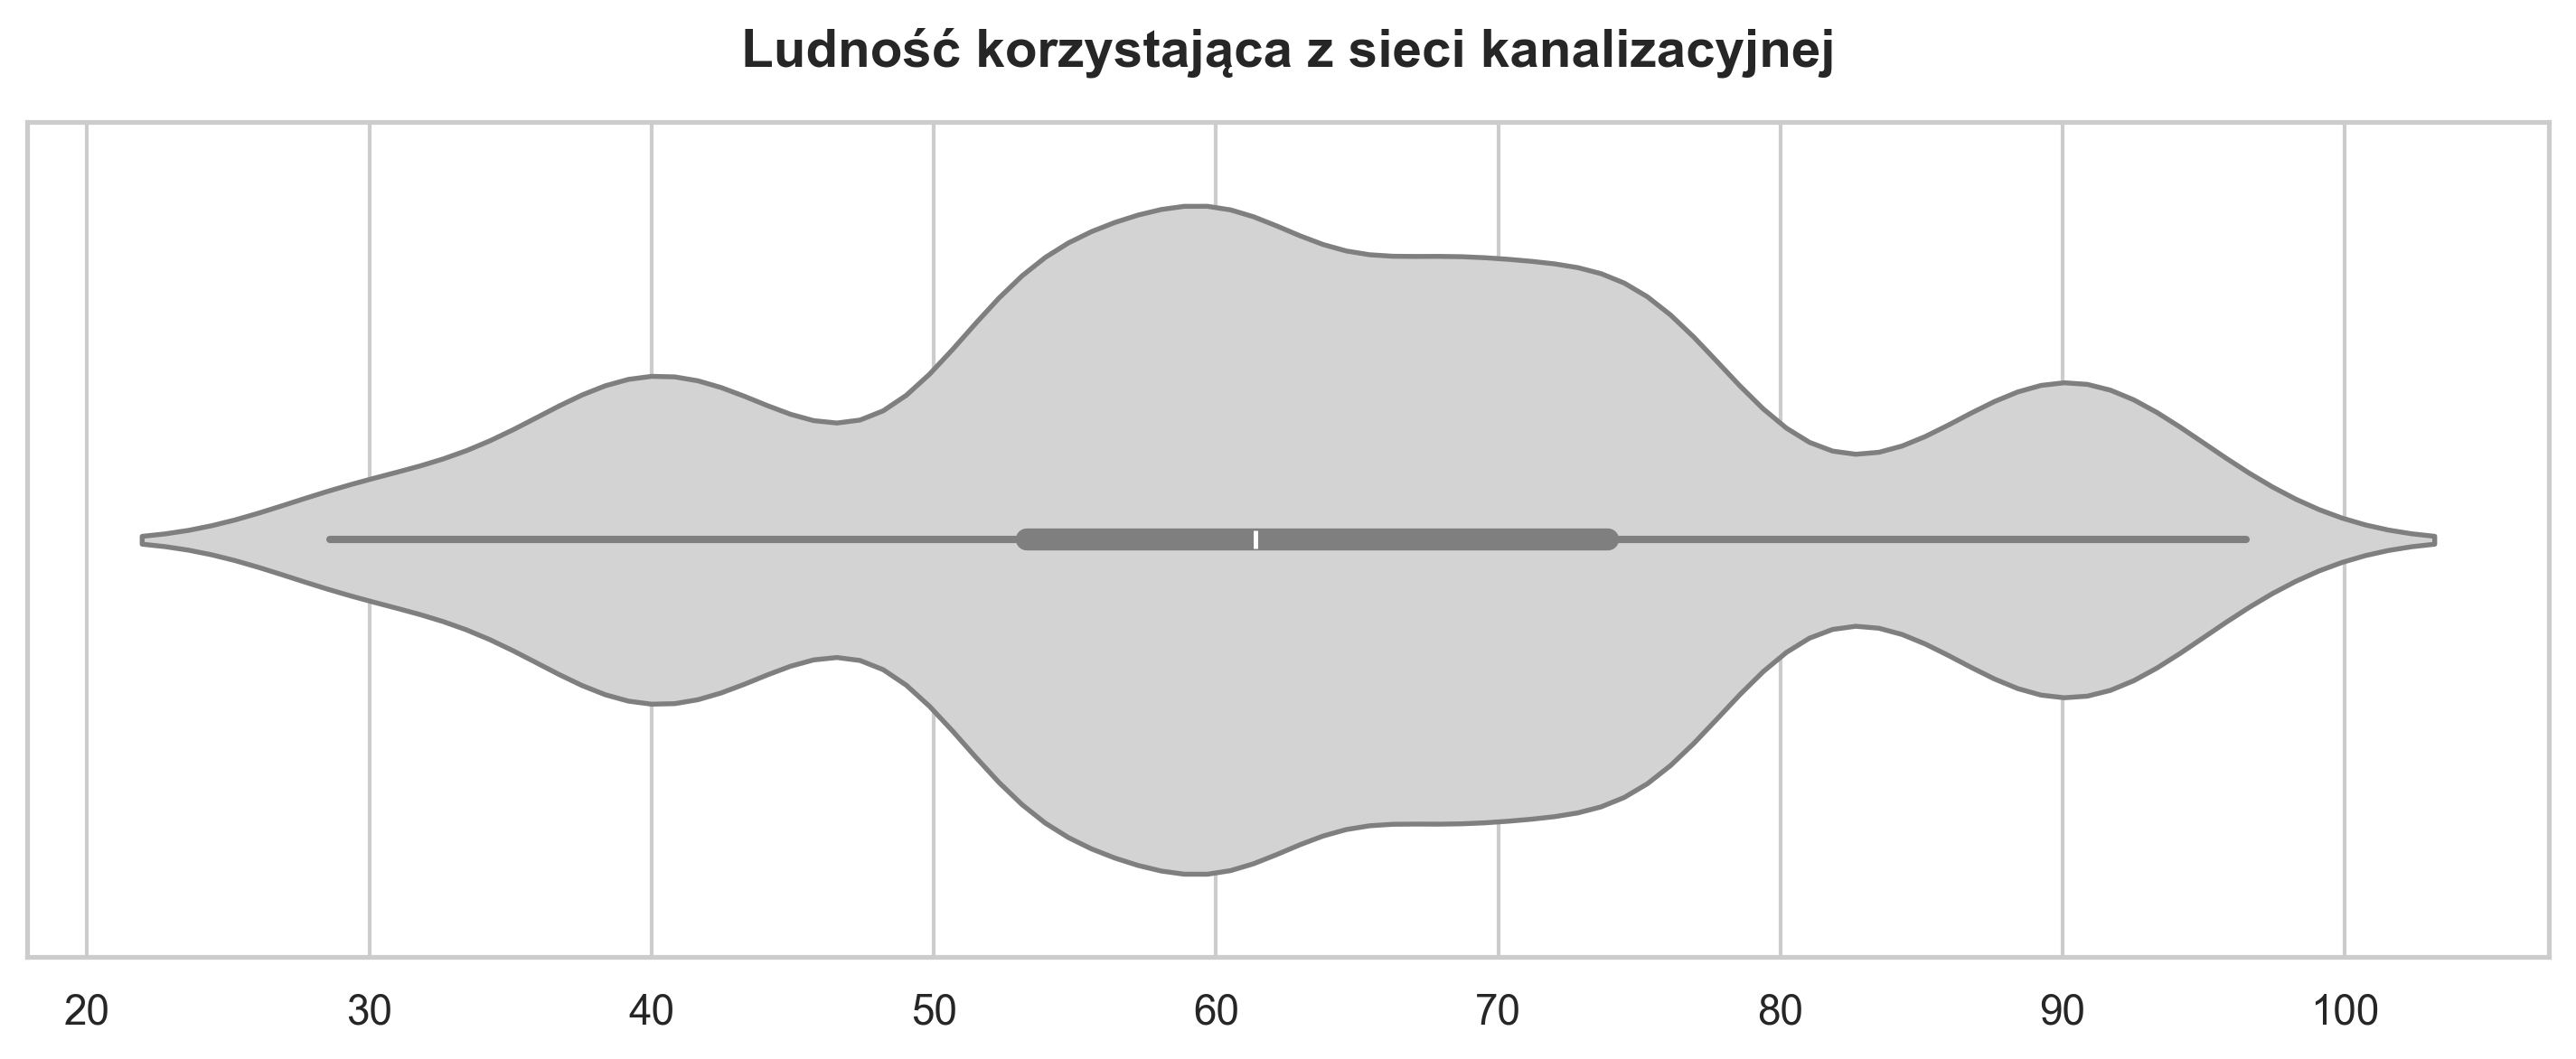

In [10]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[6],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Ludność korzystająca z sieci kanalizacyjnej", fontsize=14, fontweight='bold', pad=15)
plt.show()

Dostęp do kanalizacji jest w regionie dość szeroki, choć wciąż można wskazać powiaty, w których infrastruktura ta rozwinięta jest znacząco słabiej. Dodatkowo dla głównych obszarów miejskich wskaźnik przyjmuje wyższe wartości.
<hr style="border: 0.5px solid black;">

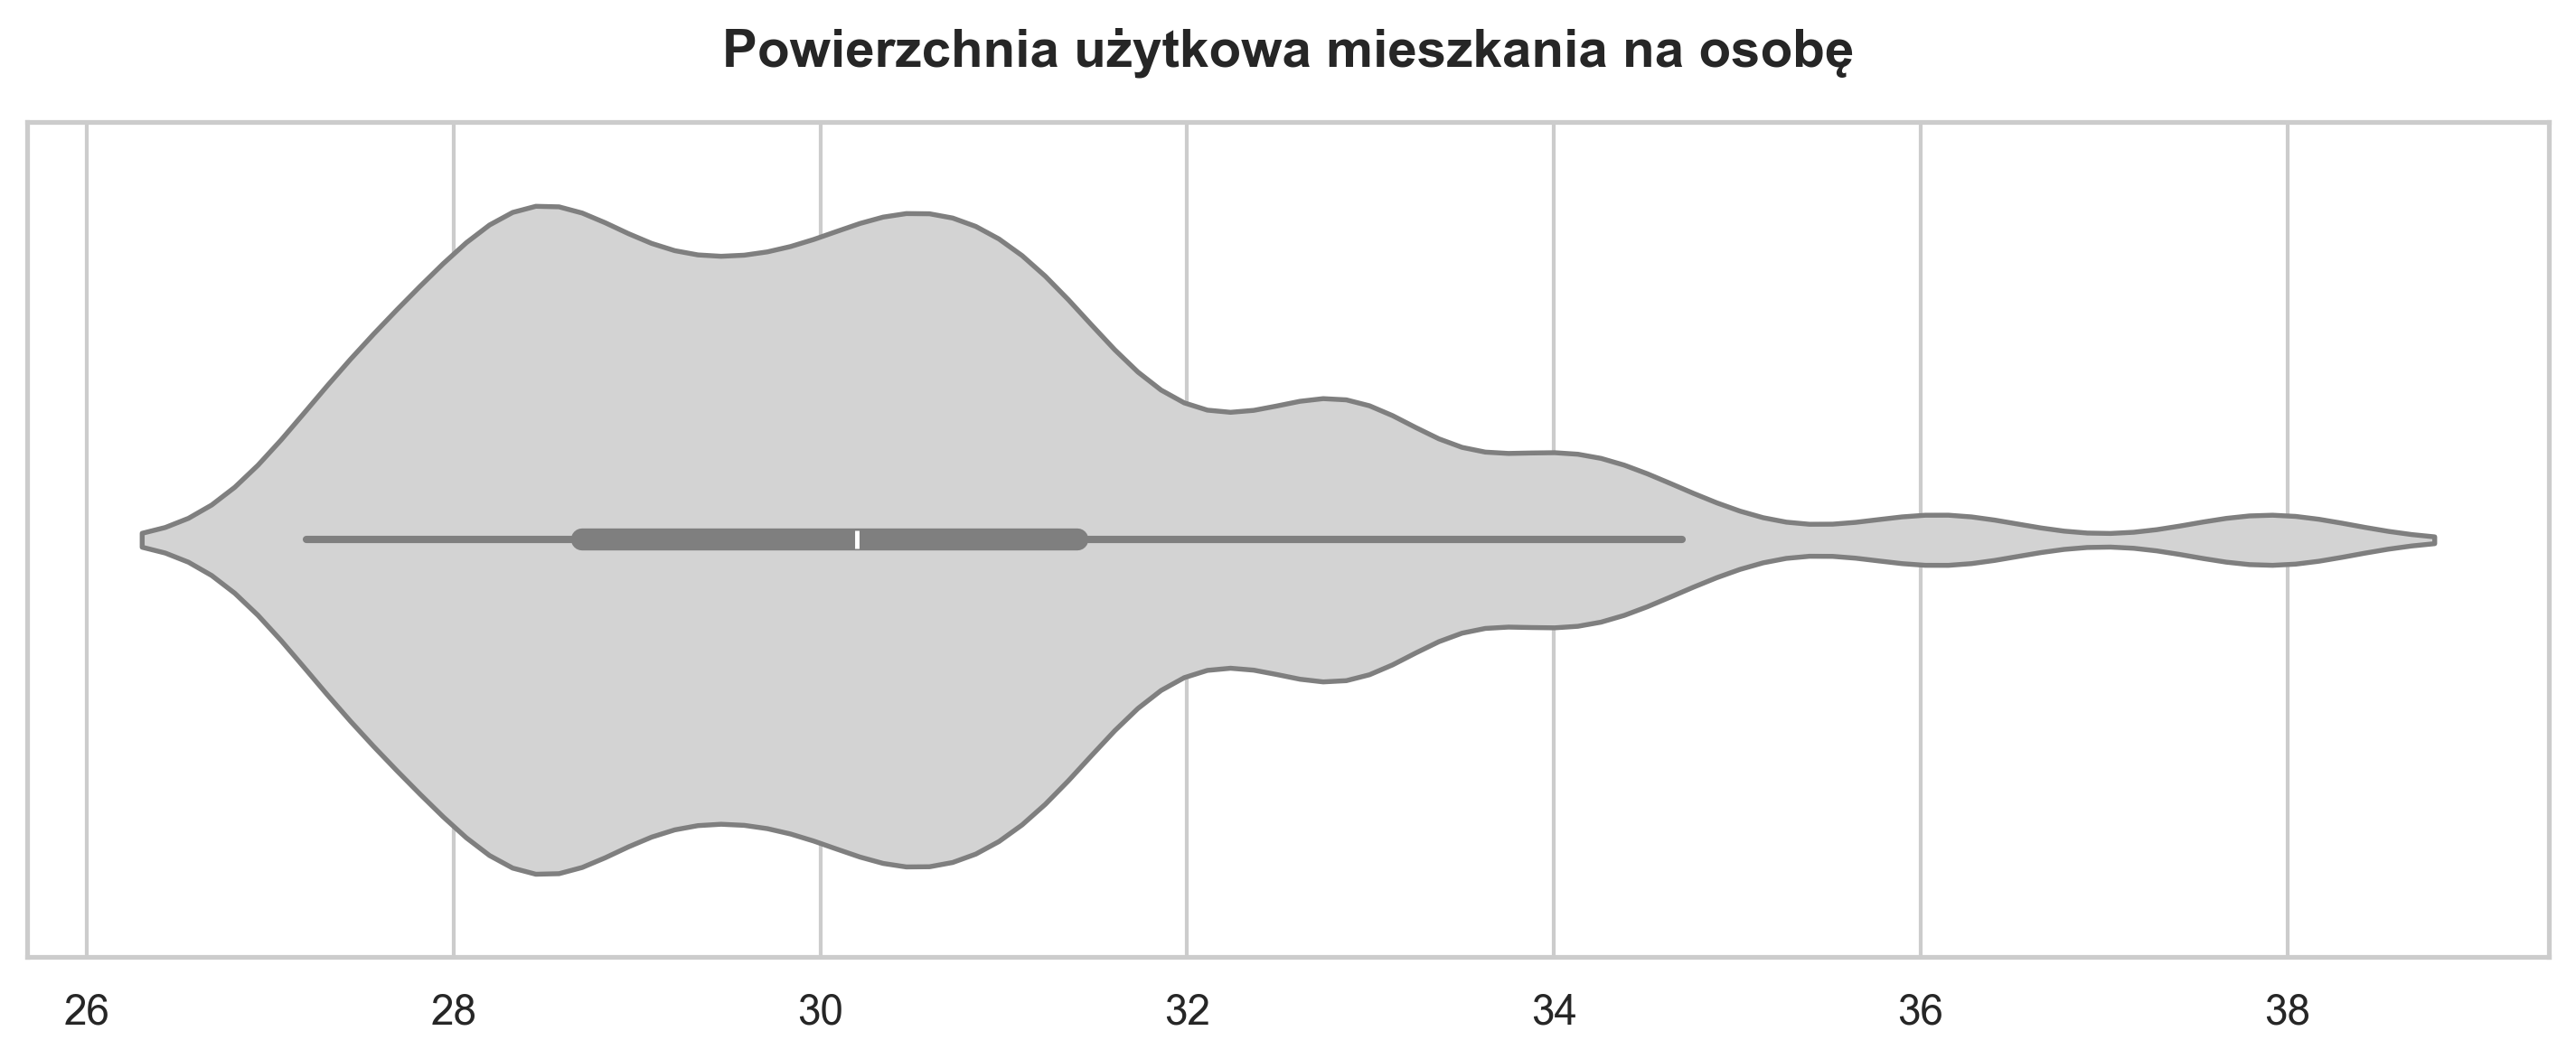

In [11]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[7],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Powierzchnia użytkowa mieszkania na osobę", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład cechy opisującej powierzchnię użytkową na osobę jest prawoskośny, a niska zmienność sugeruje zbliżony poziom warunków mieszkaniowych w większości analizowanych powiatów. Natomiast istnieją obszary regionu, dla których wskaźnik przyjmuje znacznie większe wartości.
<hr style="border: 0.5px solid black;">

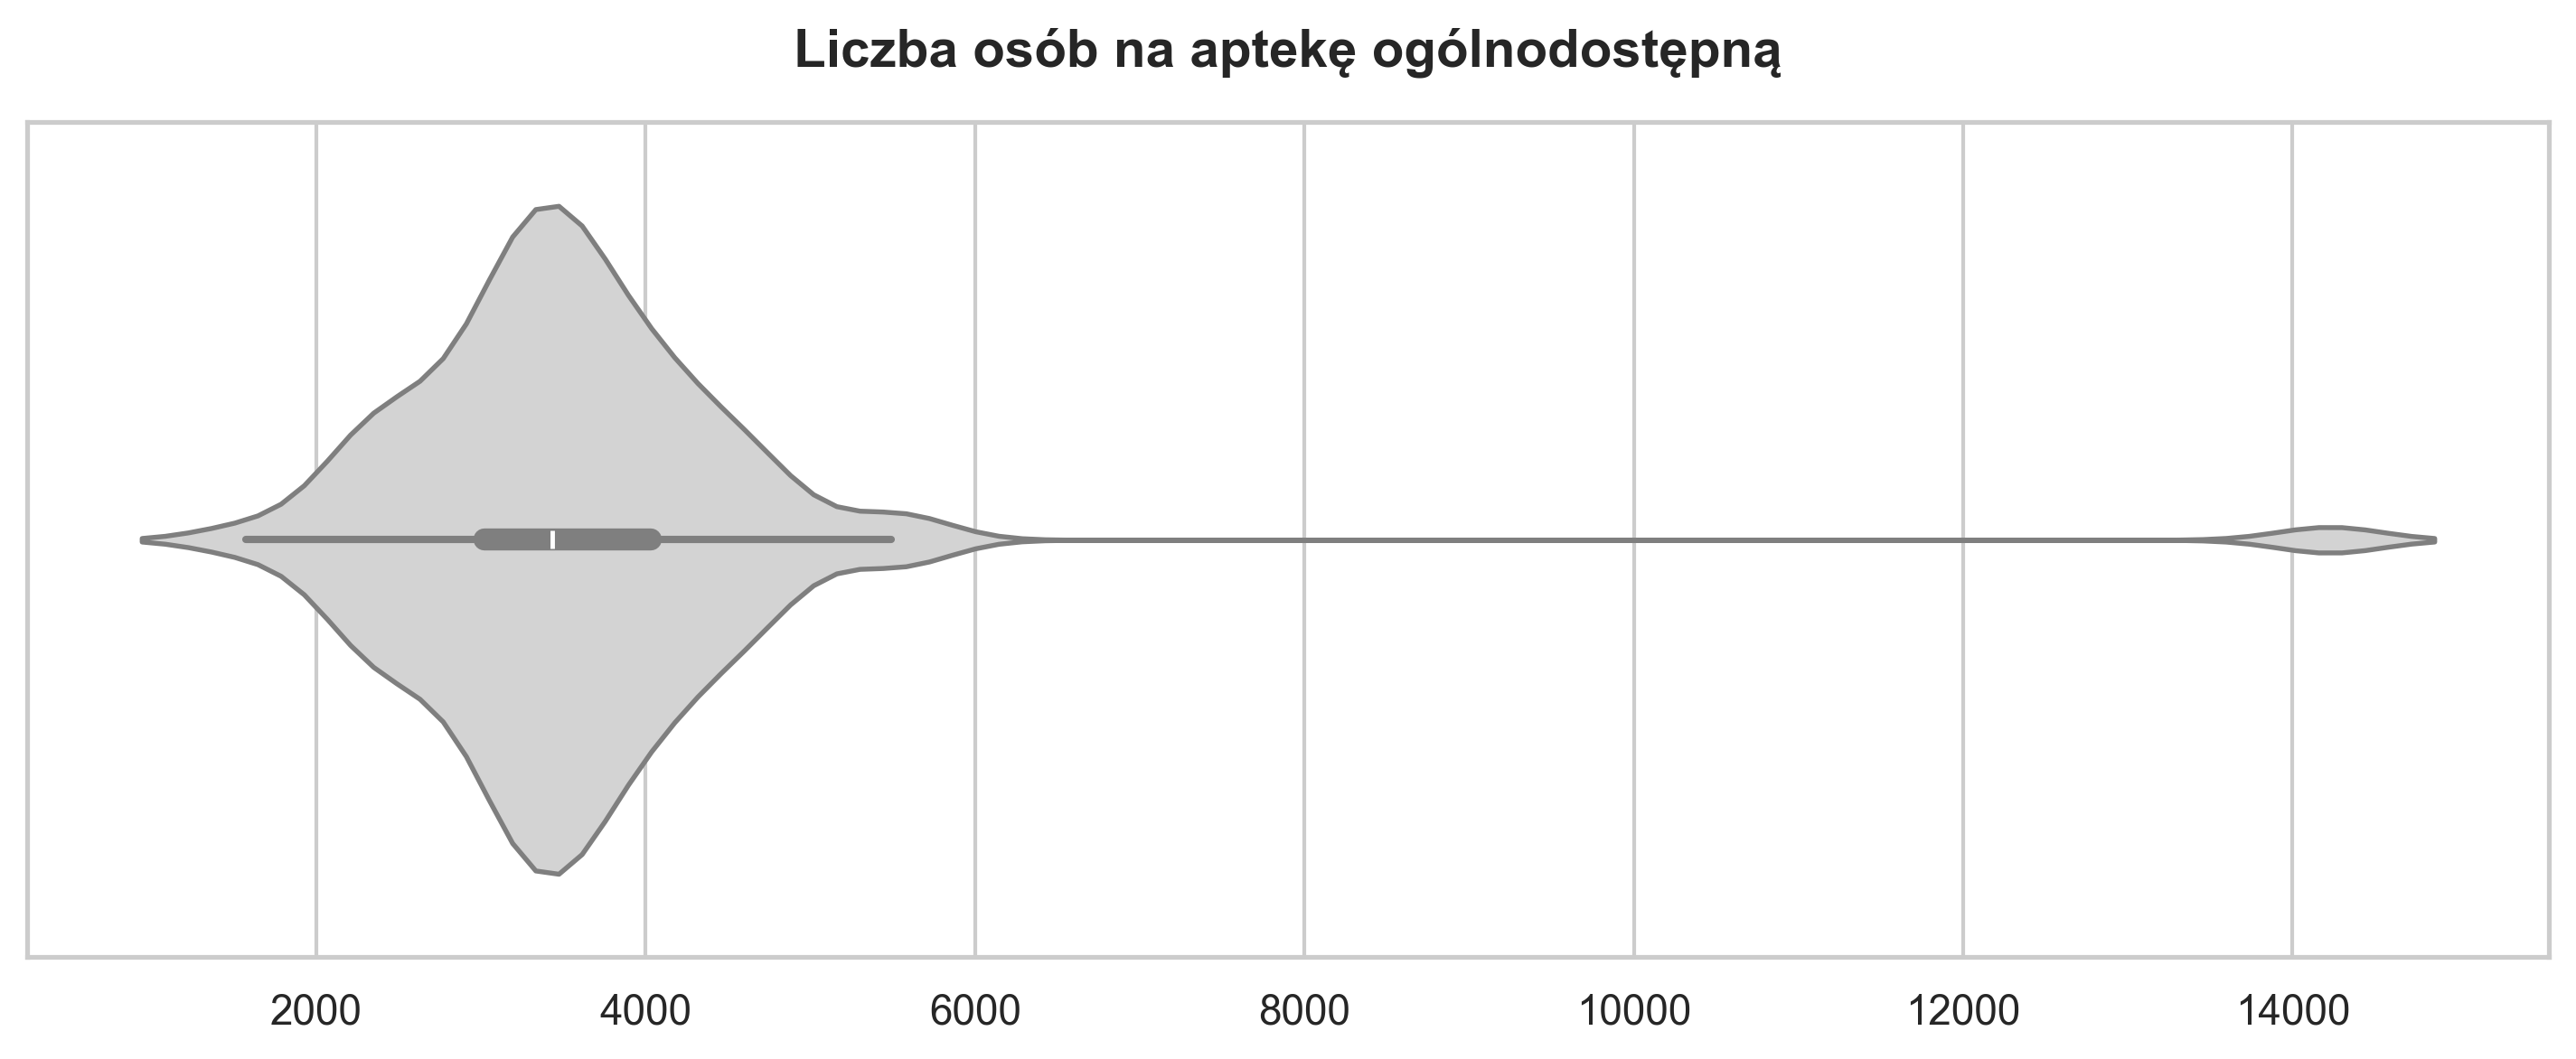

In [12]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[8],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Liczba osób na aptekę ogólnodostępną", fontsize=14, fontweight='bold', pad=15)
plt.show()

Dostępność aptek dla mieszkańców większości powiatów jest zbliżona. W niektórych dostęp do usług farmaceutycznych jest bardzo ograniczony, a także należy zauważyć obszar, dla którego wskaźnik osiągą kilkukrotnie wyższą wartość niż przeciętna. Może to świadczyć o nierównym dostępie do usług zdrowotnych w regionie.
<hr style="border: 0.5px solid black;">

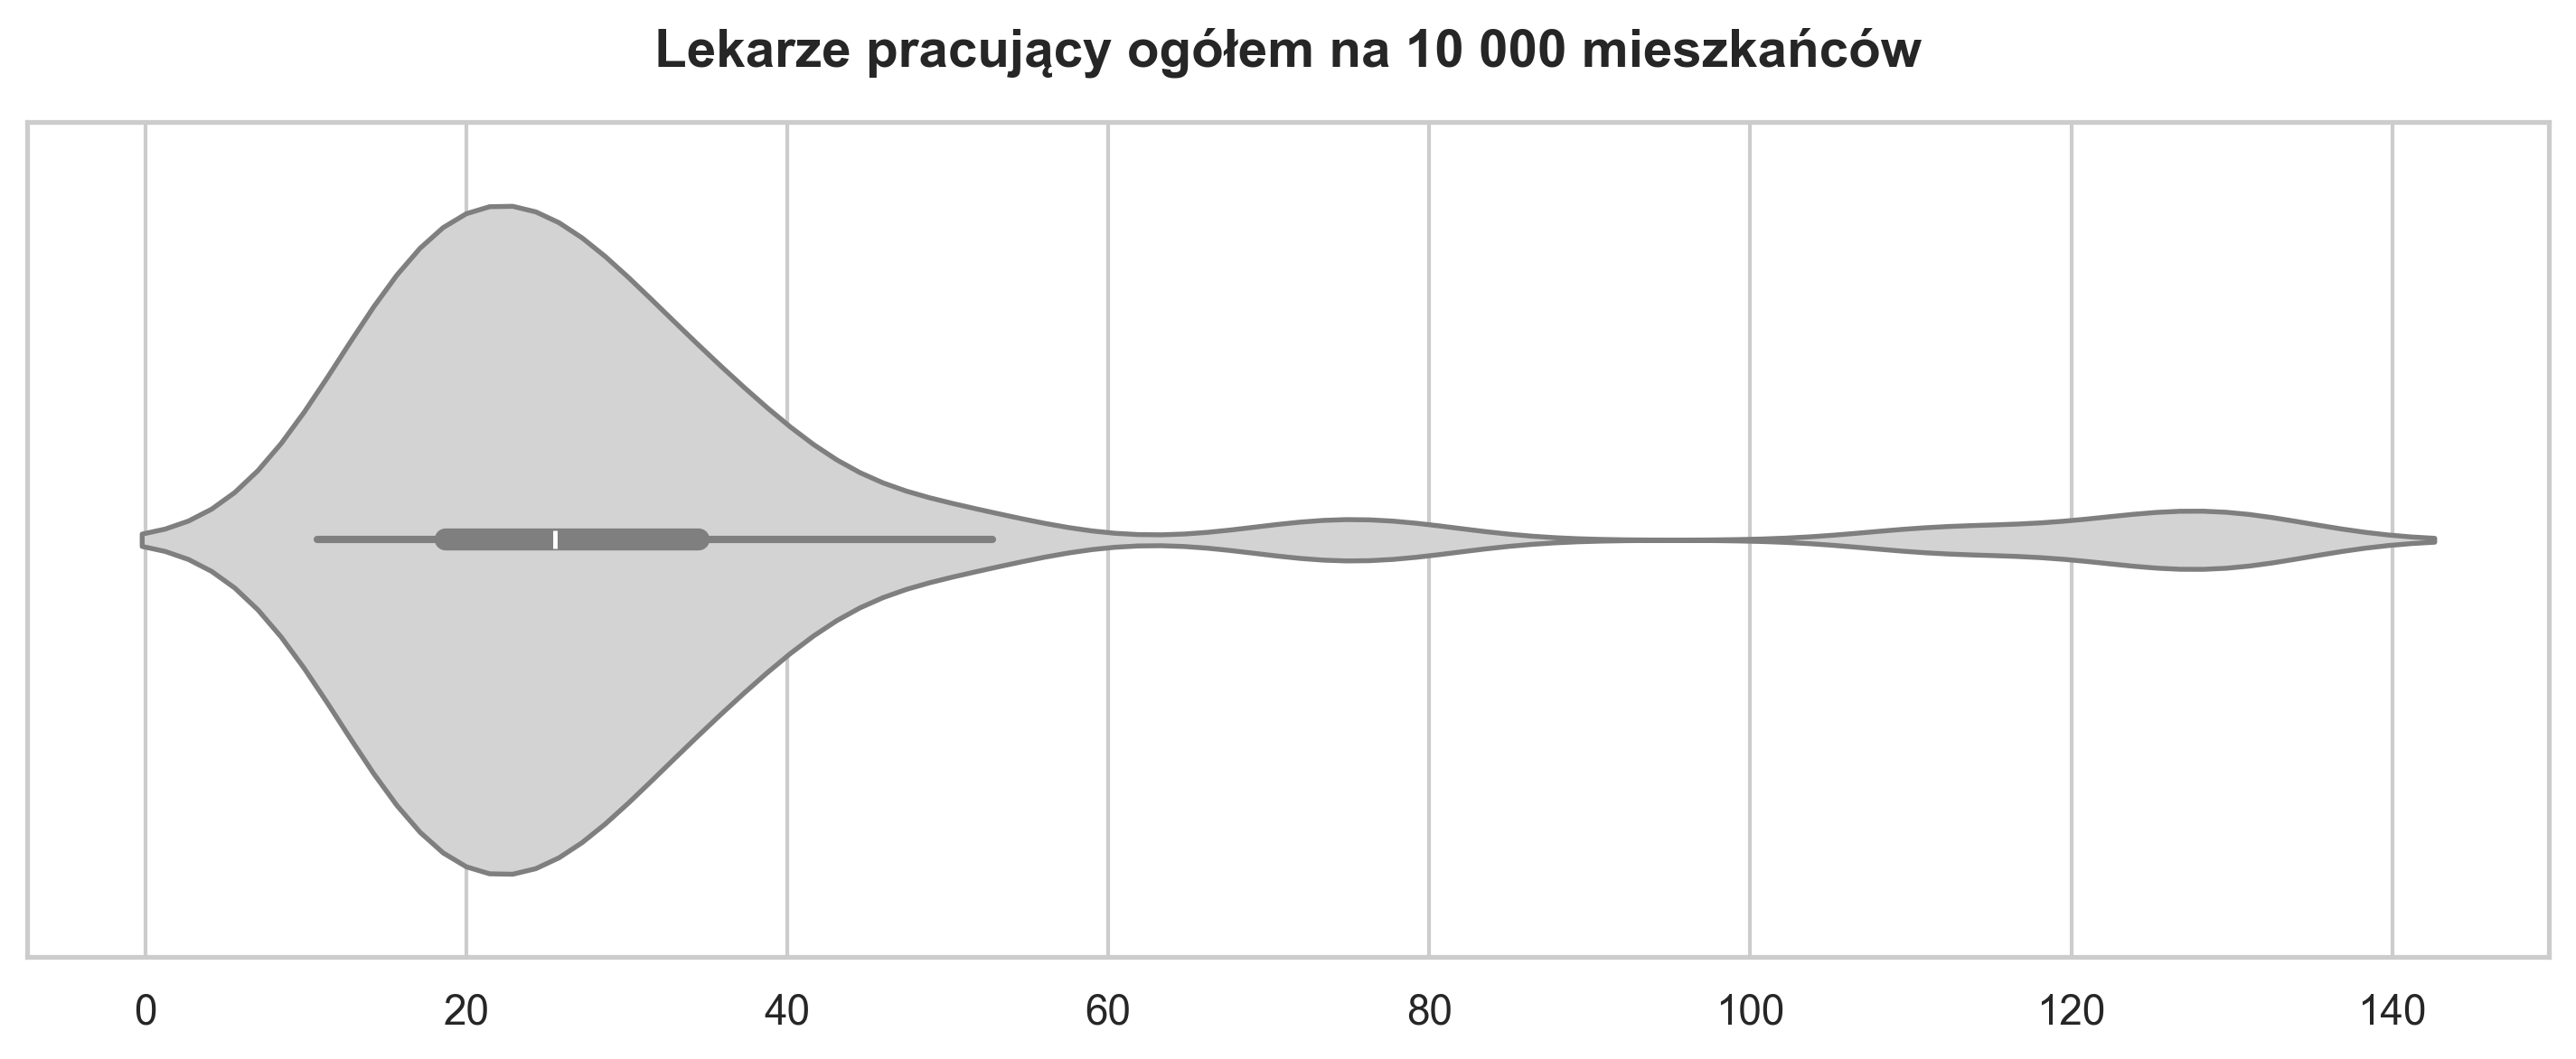

In [13]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[9],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Lekarze pracujący ogółem na 10 000 mieszkańców", fontsize=14, fontweight='bold', pad=15)
plt.show()

Podobnie jak z dostępnością do aptek, rozkład jest wyraźnie prawoskośny, co oznacza, że w większości powiatów liczba lekarzy jest raczej niska, a tylko kilka jednostek osiąga znacznie wyższe wartości. Duża zmienność potwierdza różnice w dostępności usług medycznych w regionie południowo-wschodniej Polski.
<hr style="border: 0.5px solid black;">

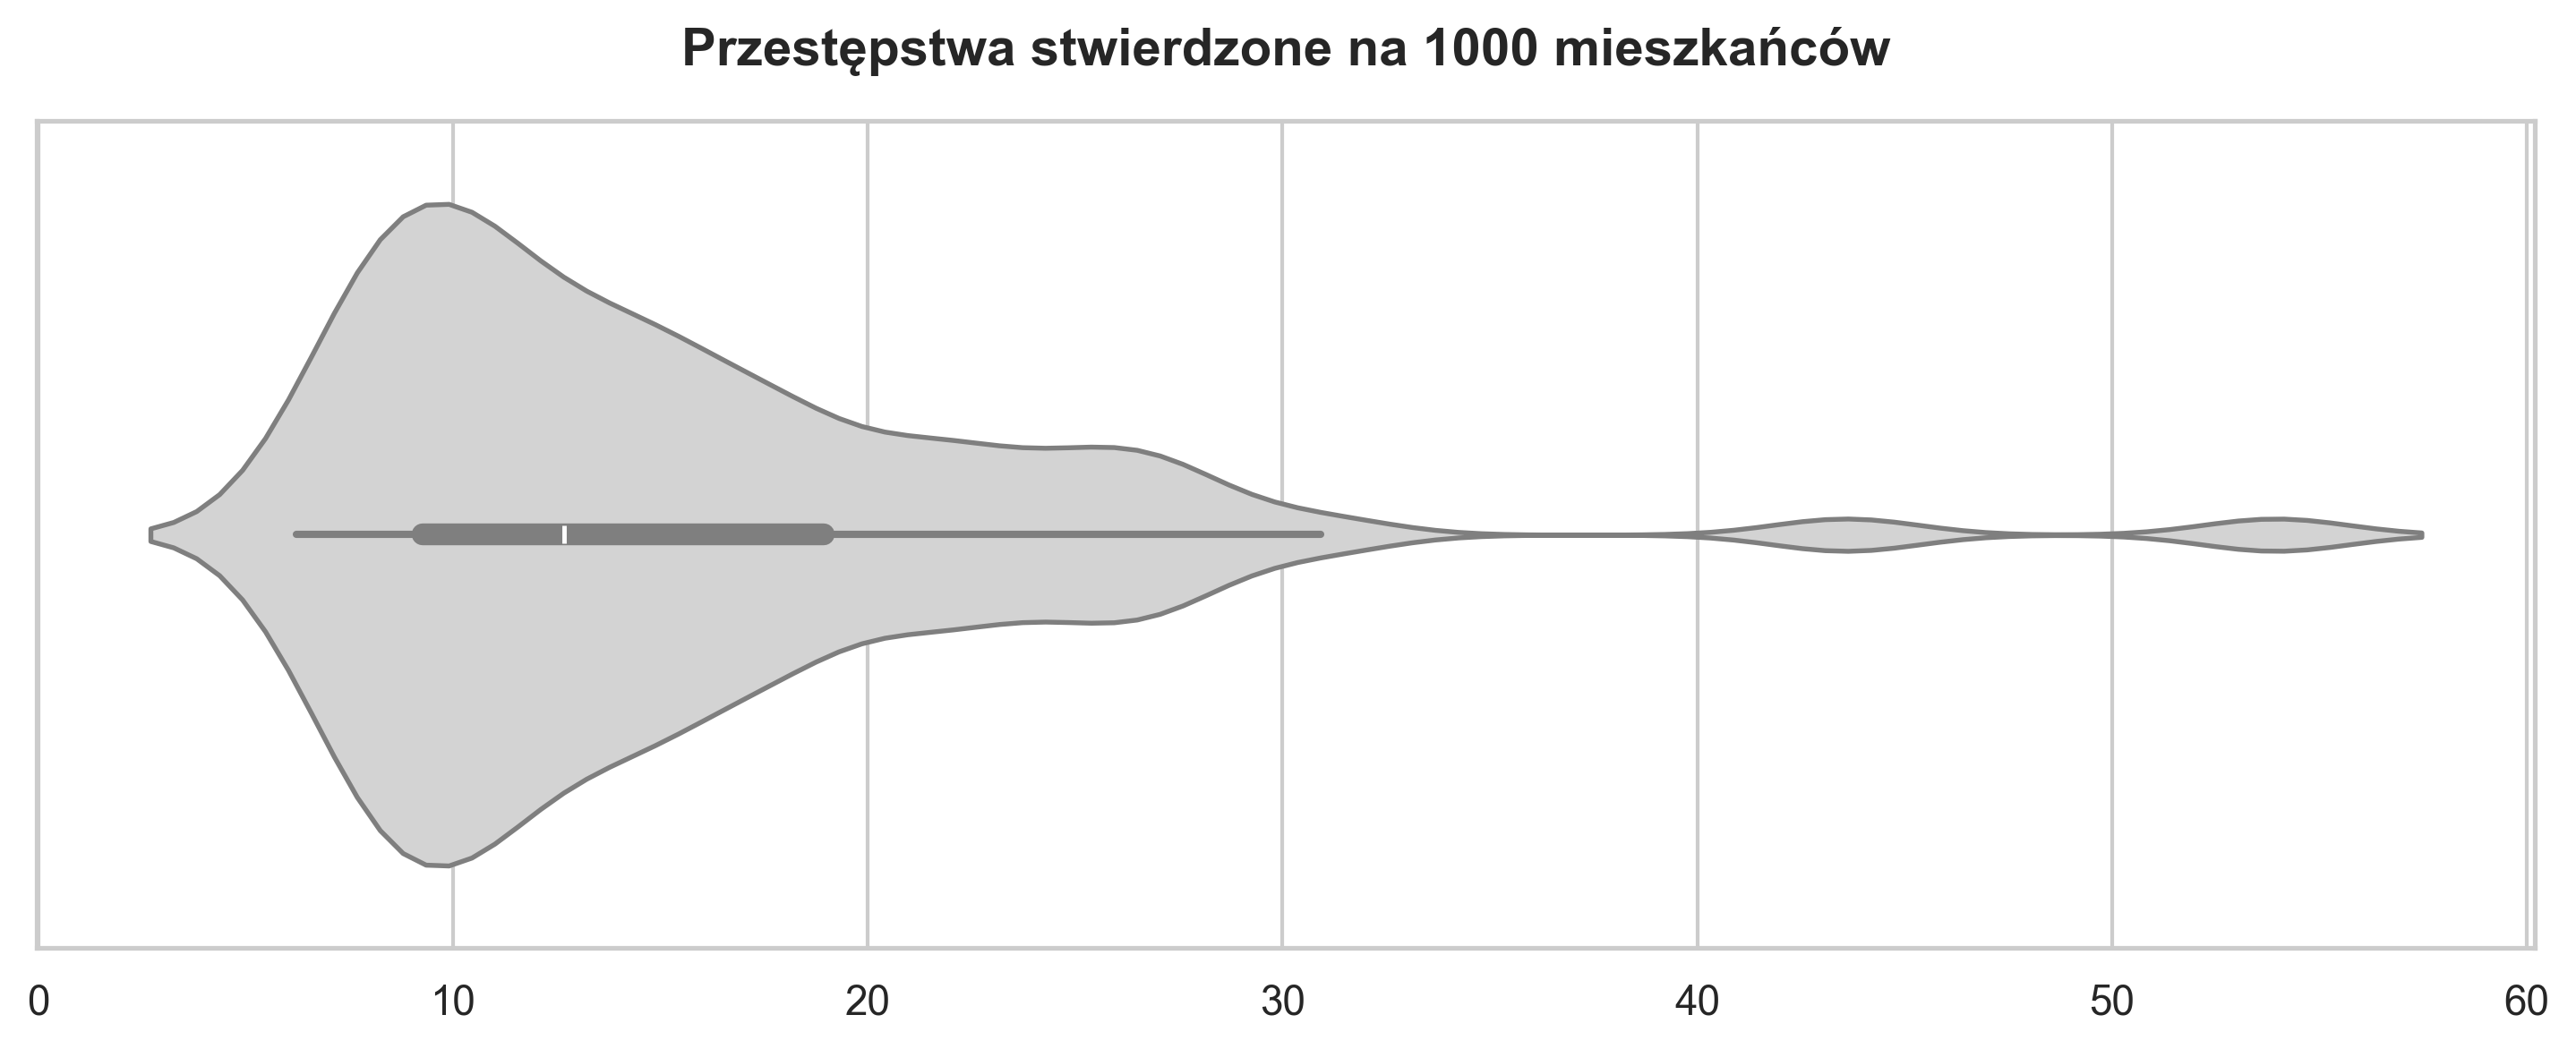

In [14]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[10],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Przestępstwa stwierdzone na 1000 mieszkańców", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład umiarkowanie prawoskośny i o wysokiej kurtozie sugerują, że w większości powiatów poziom przestępczości jest niski, lecz pojedyncze obszary notują znacząco wyższe wartości tego wskaźniki.
<hr style="border: 0.5px solid black;">

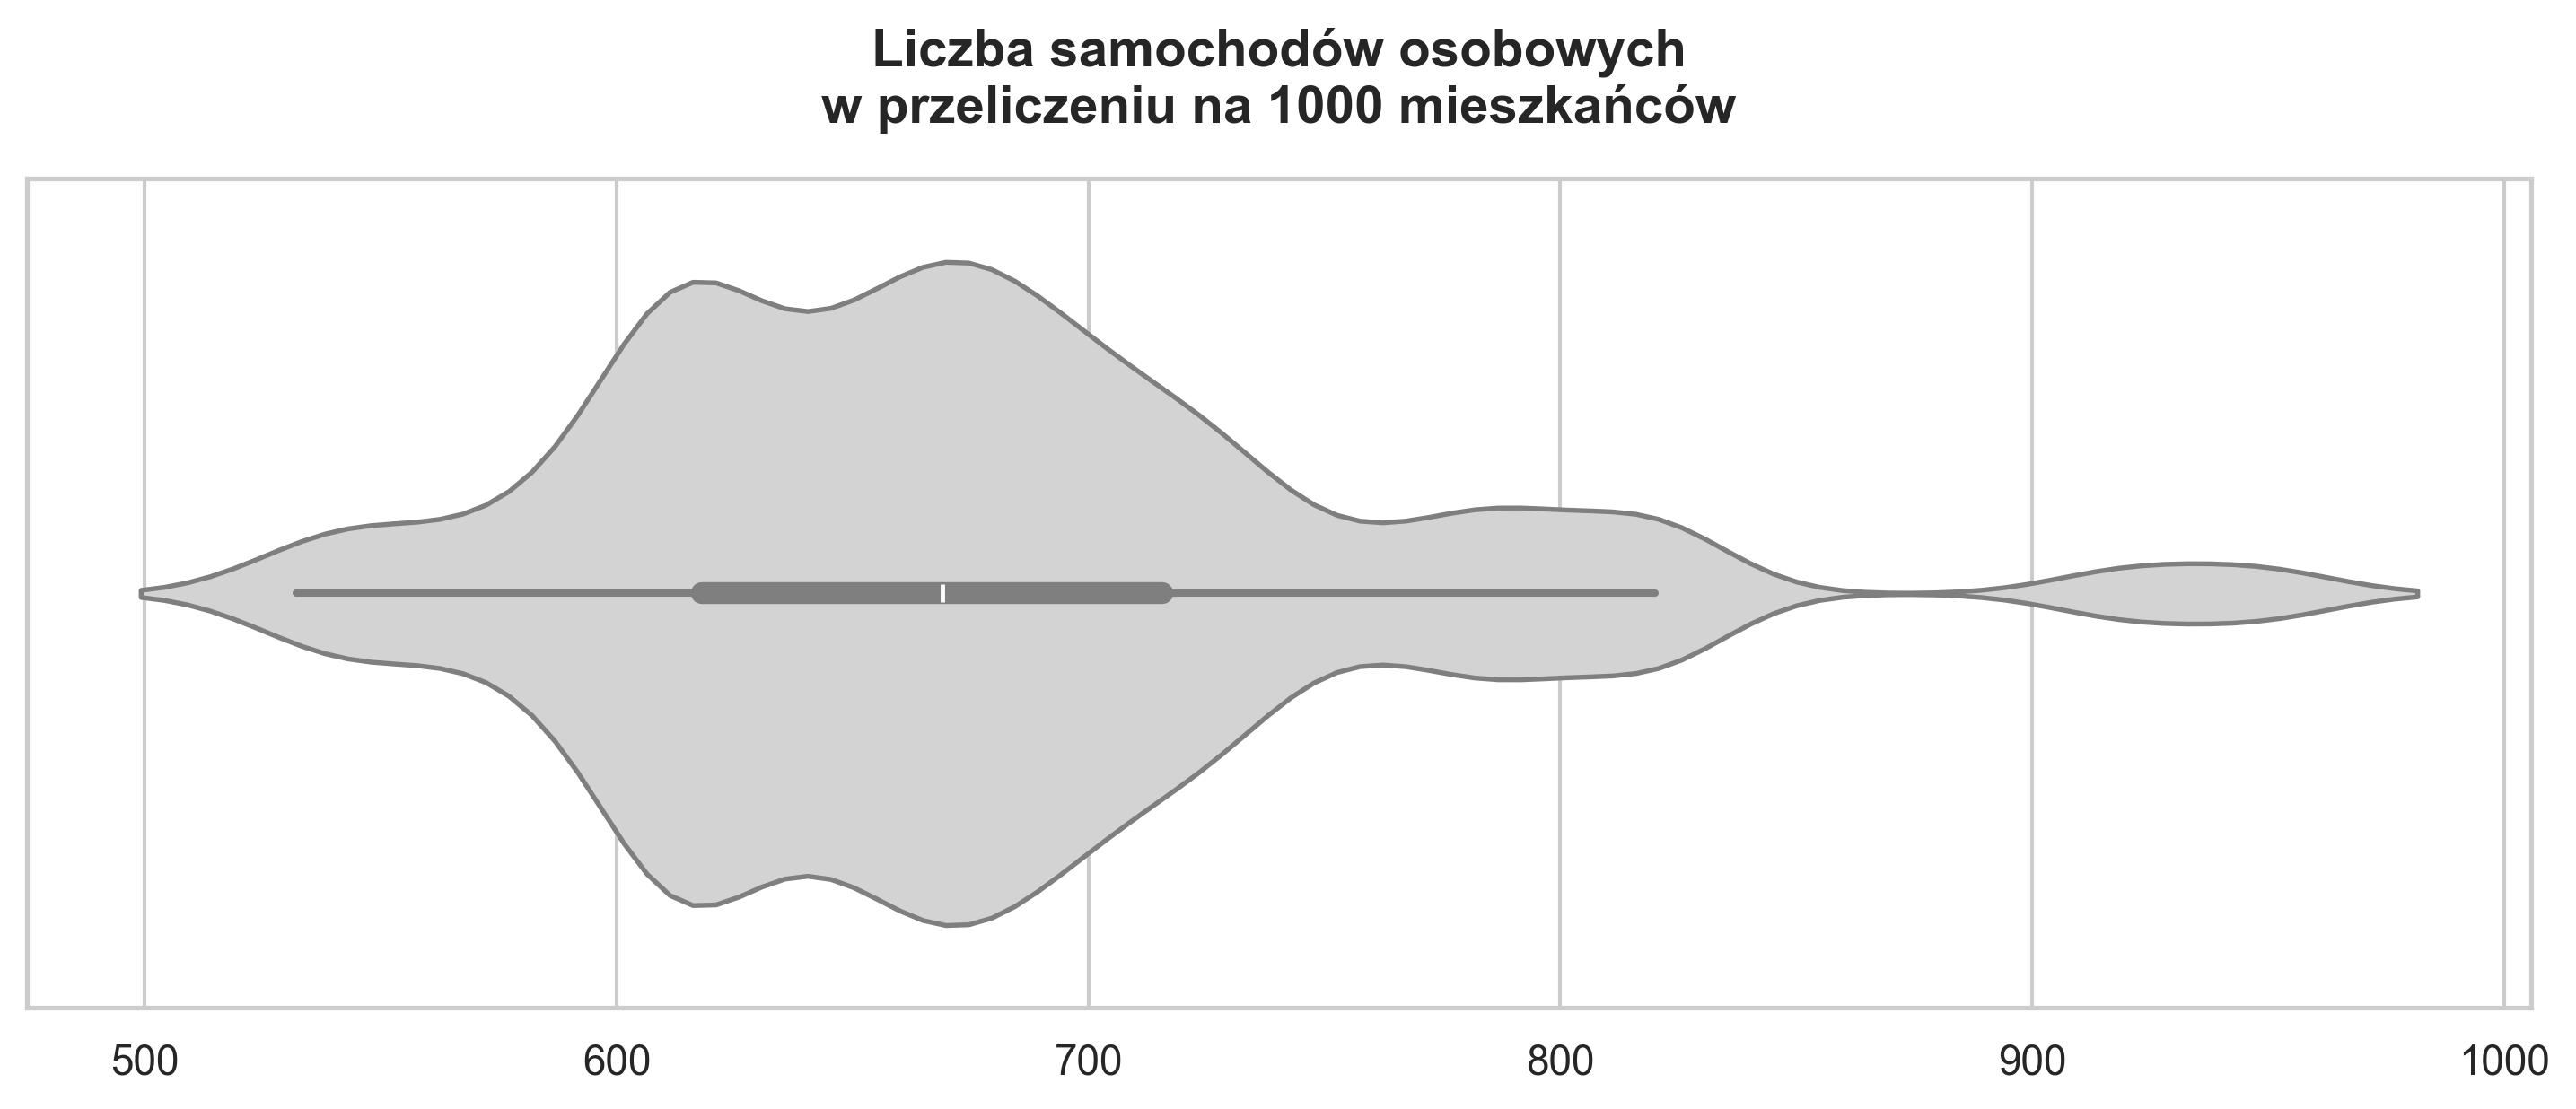

In [15]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[11],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Liczba samochodów osobowych\nw przeliczeniu na 1000 mieszkańców", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład jest lekko prawoskośny, co wskazuje, że większość powiatów ma umiarkowany poziom motoryzacji, a tylko nieliczne wyróżniają się dużą liczbą pojazdów. Niewielka zmienność sugeruje stosunkowo podobny poziom wskaźnika w całym regionie.
<hr style="border: 0.5px solid black;">

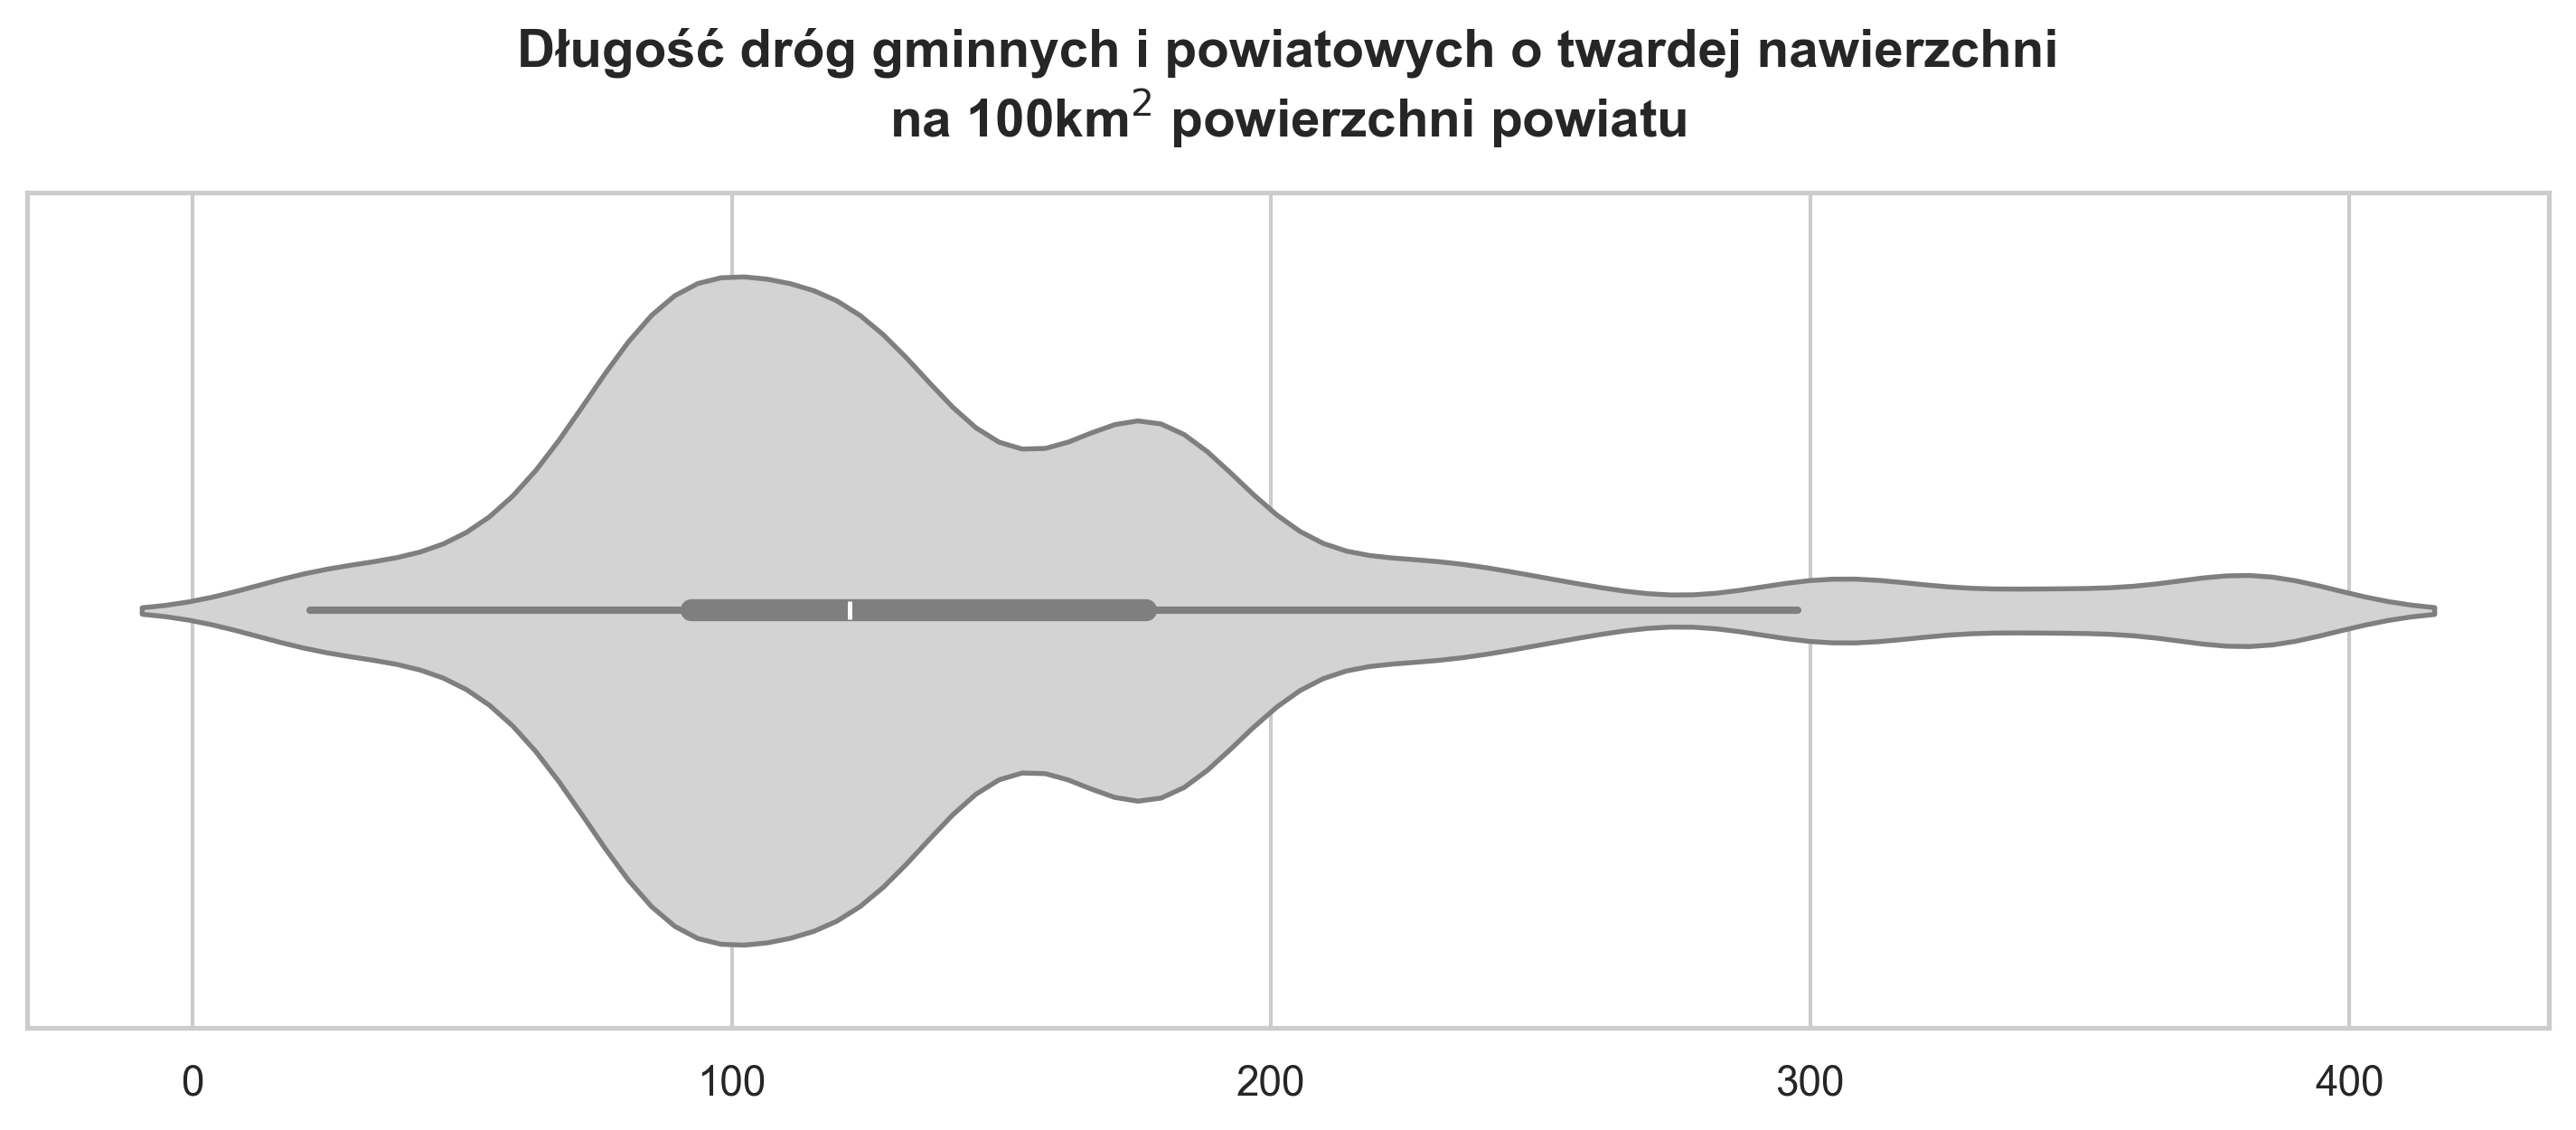

In [16]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[12],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Długość dróg gminnych i powiatowych o twardej nawierzchni\nna 100km$^2$ powierzchni powiatu", fontsize=14, fontweight='bold', pad=15)
plt.show()

Znaczna prawoskośność i spora zmienność mogą świadczyć o dużych różnicach w gęstości infrastruktury drogowej między powiatami. Część jednostek dysponuje rozbudowaną siecią dróg, podczas gdy inne pozostają słabiej rozwinięte pod tym względem.
<hr style="border: 0.5px solid black;">

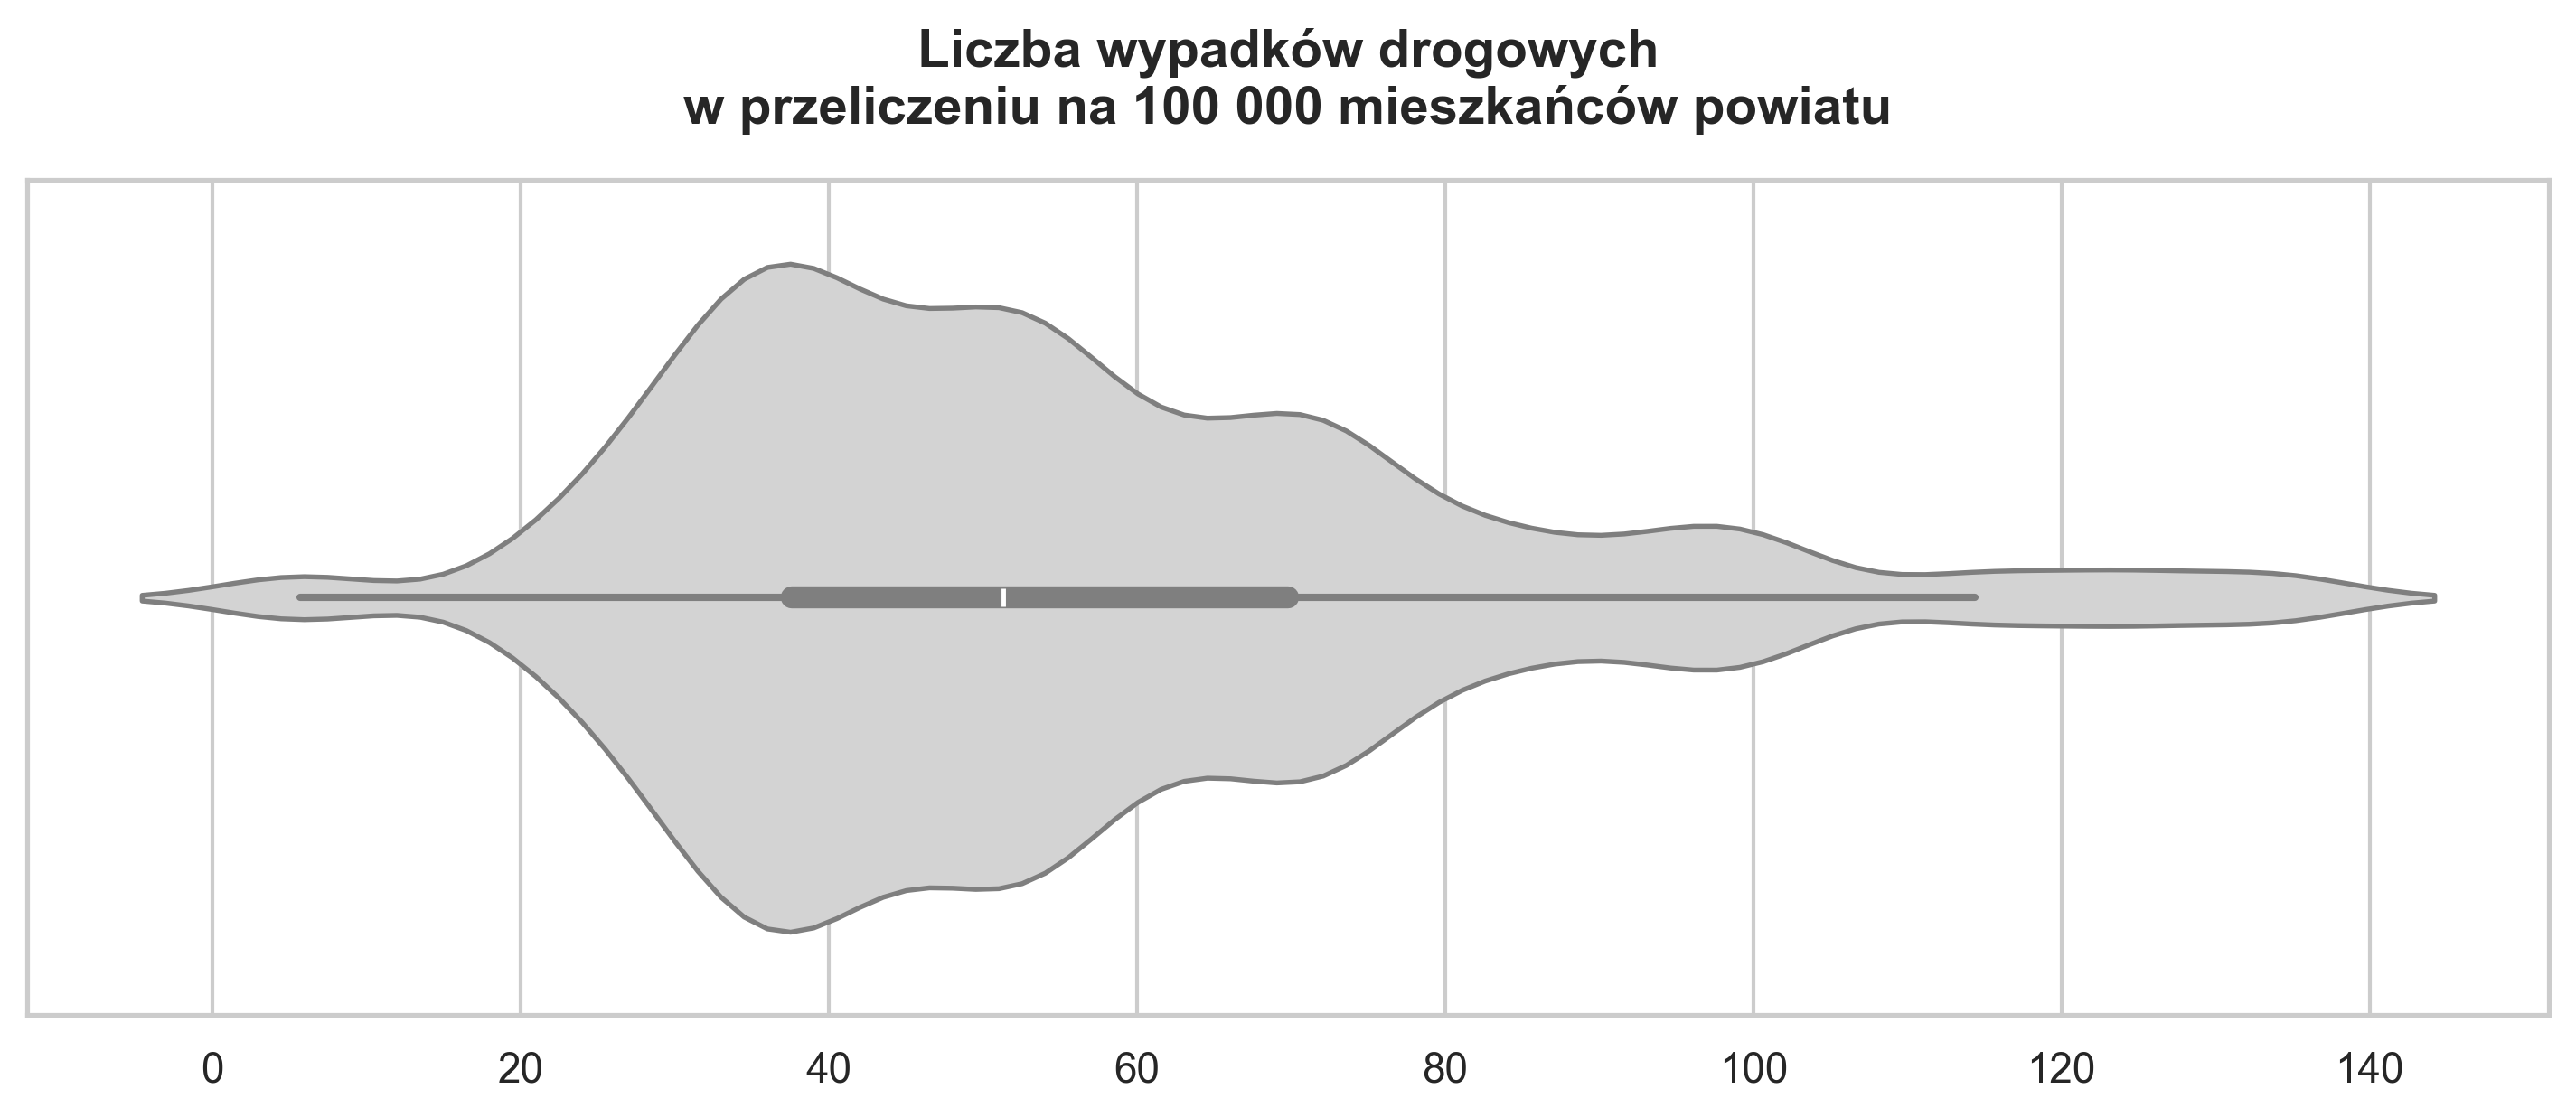

In [17]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[13],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Liczba wypadków drogowych\nw przeliczeniu na 100 000 mieszkańców powiatu", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład cechy jest prawoskośny, co oznacza, że większość powiatów cechuje się relatywnie niskim poziomem wskaźnika, a do więkoszości wypadków drogowych dochodzi w nielicznych obszarach regionu.
<hr style="border: 0.5px solid black;">

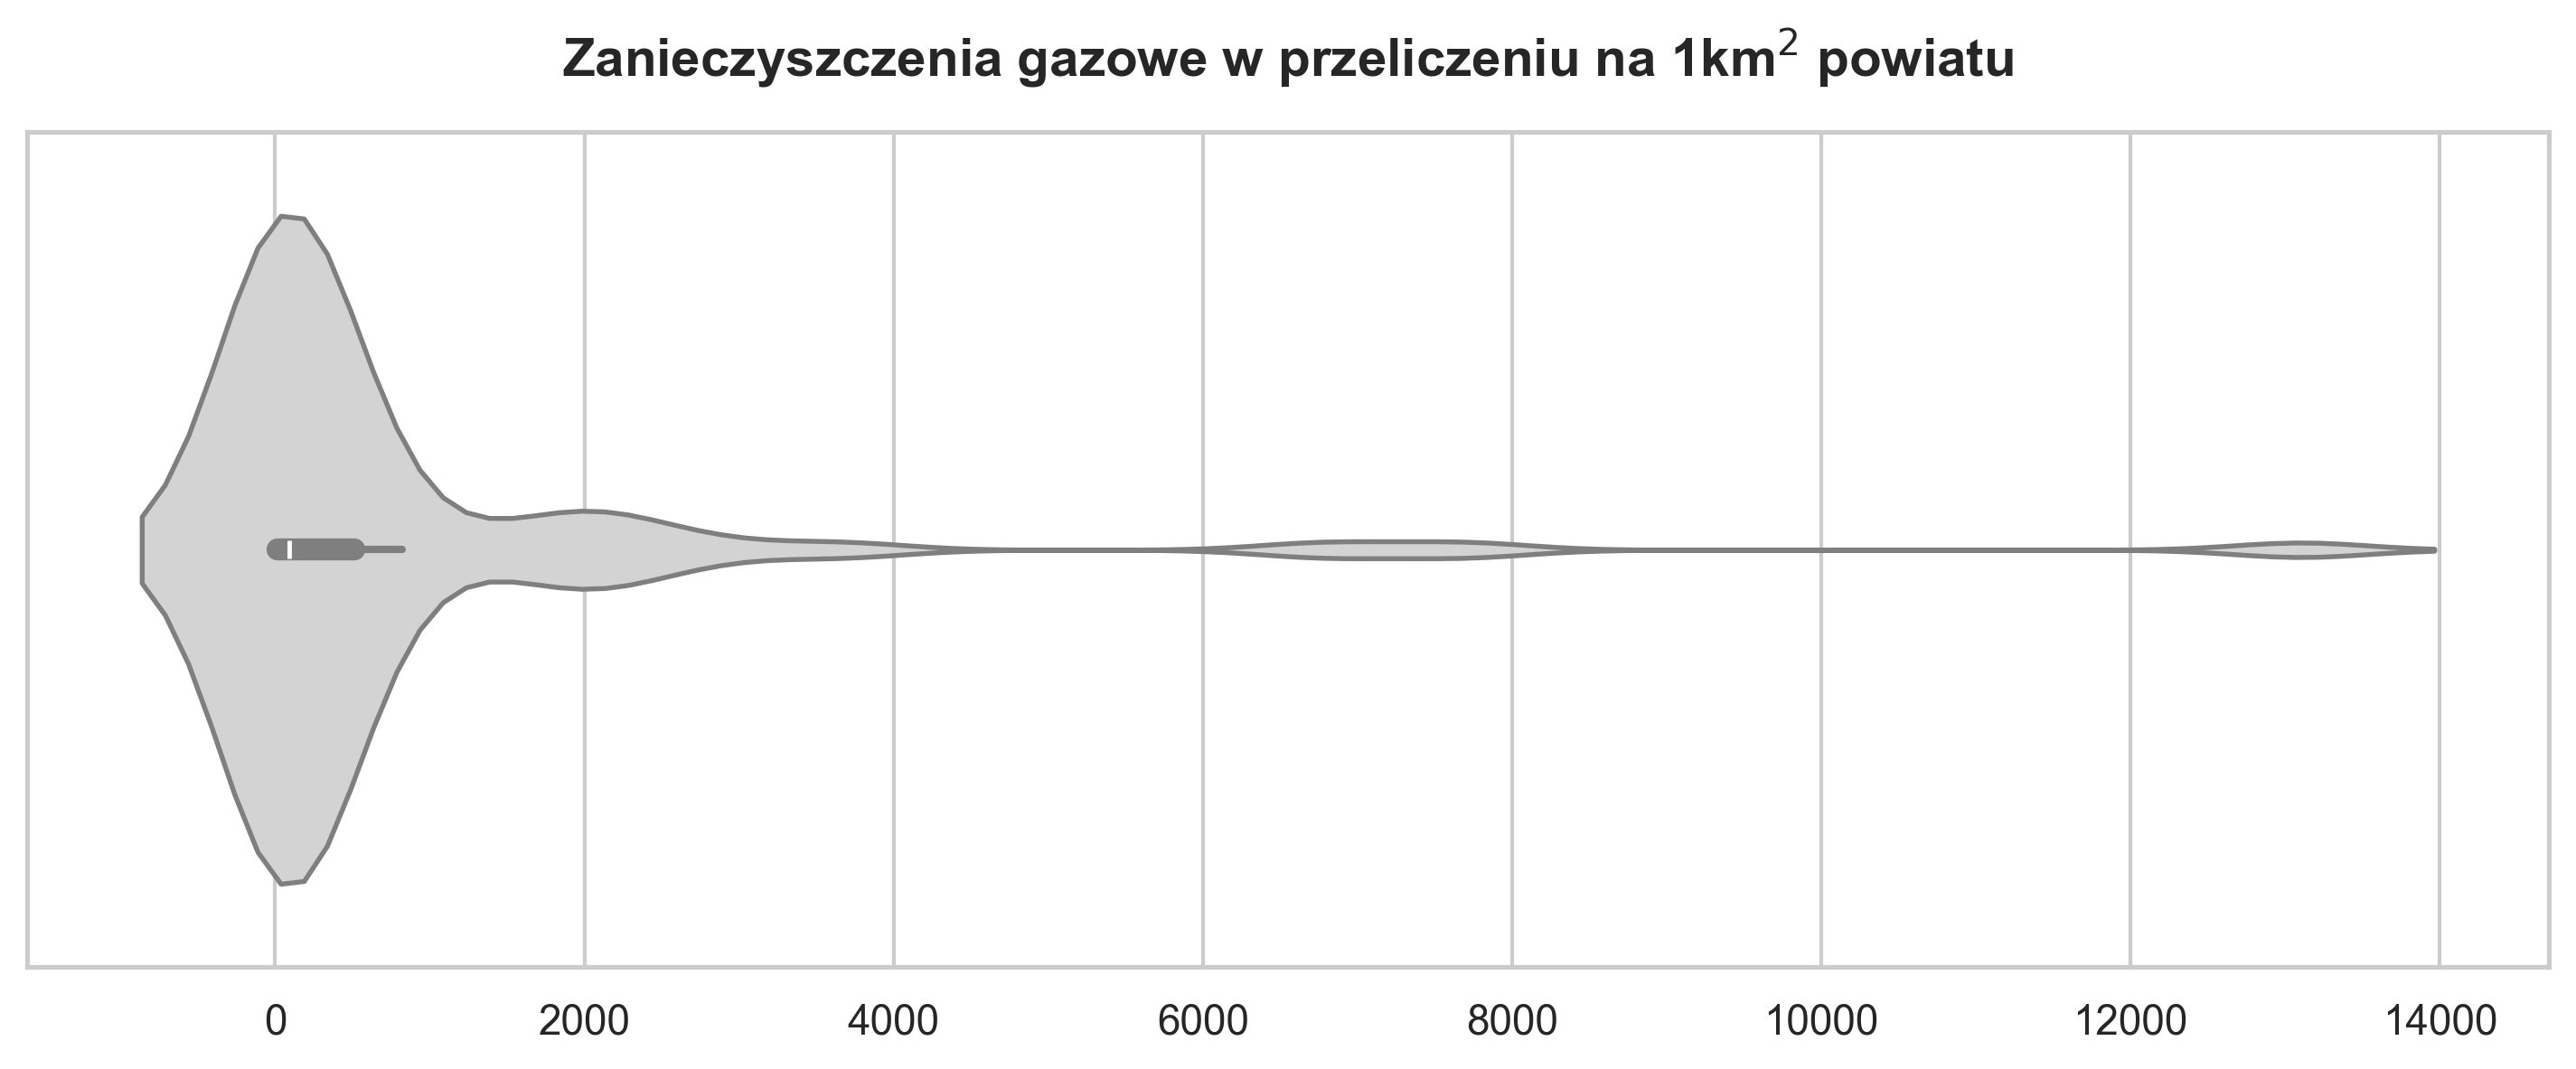

In [18]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[14],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Zanieczyszczenia gazowe w przeliczeniu na 1km$^2$ powiatu", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład bardzo silnie prawoskośny, o wysokiej kurtozie i współczynniku zmienności wskazuje na występowanie kilku powiatów o wyjątkowo wysokim poziomie emisji gazów, stanowiących prawdopodobnie główne obszary przemysłowe regionu południowo-wschodniej Polski. W większości jednostek zanieczyszczenie powietrza pozostaje na stosunkowo niskim poziomie.
<hr style="border: 0.5px solid black;">

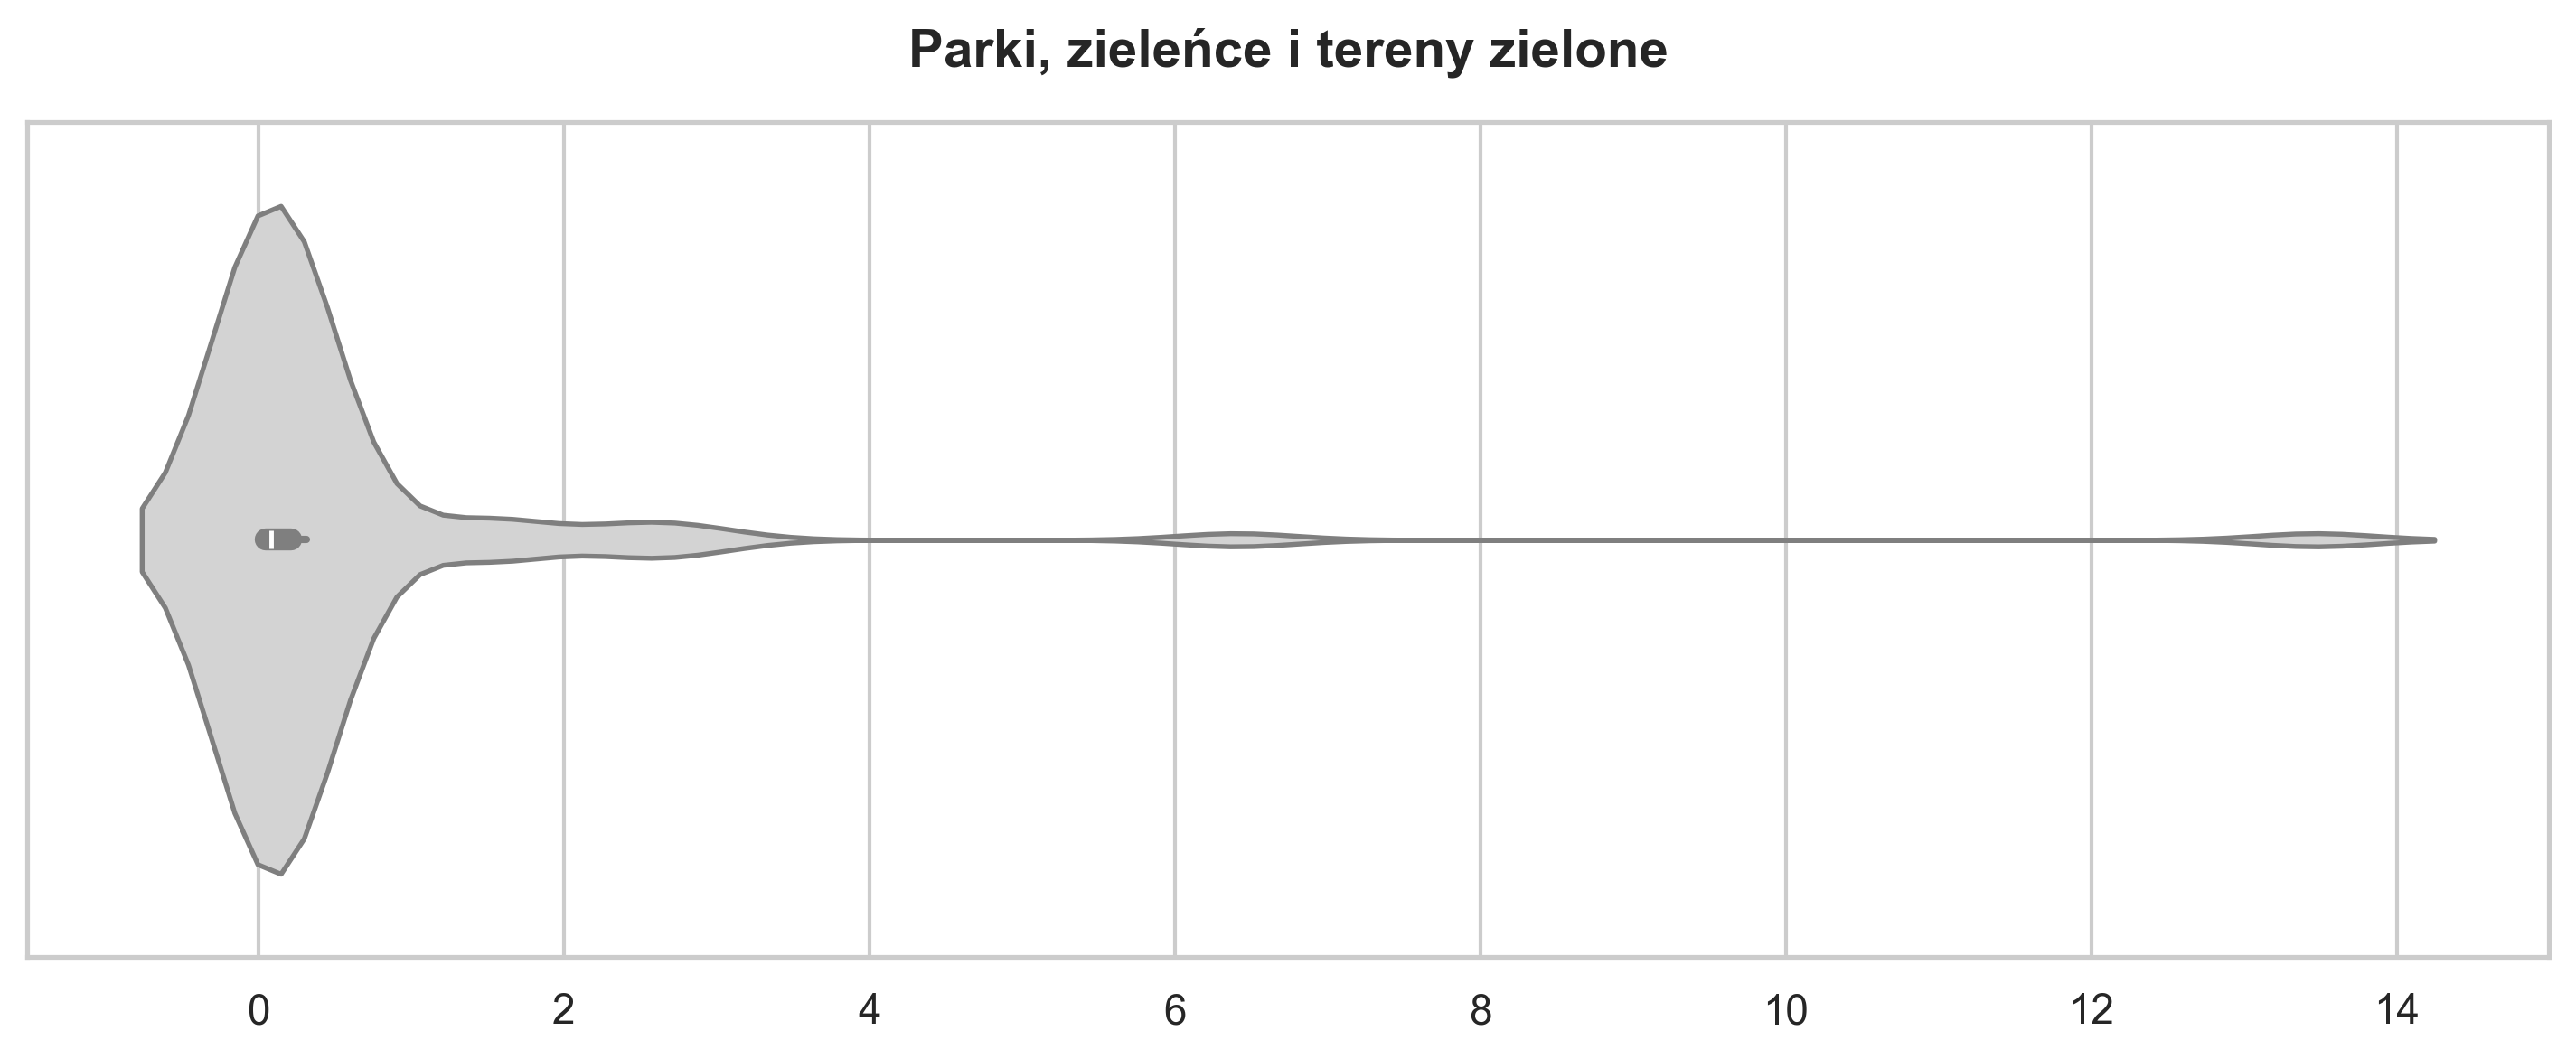

In [19]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[15],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Parki, zieleńce i tereny zielone", fontsize=14, fontweight='bold', pad=15)
plt.show()

Prawoskośność cechy i bardzo wysoka zmienność sugerują, że tylko nieliczne powiaty mają znaczące powierzchnie terenów zielonych. W pozostałych udział takich obszarów jest minimalny.
<hr style="border: 0.5px solid black;">

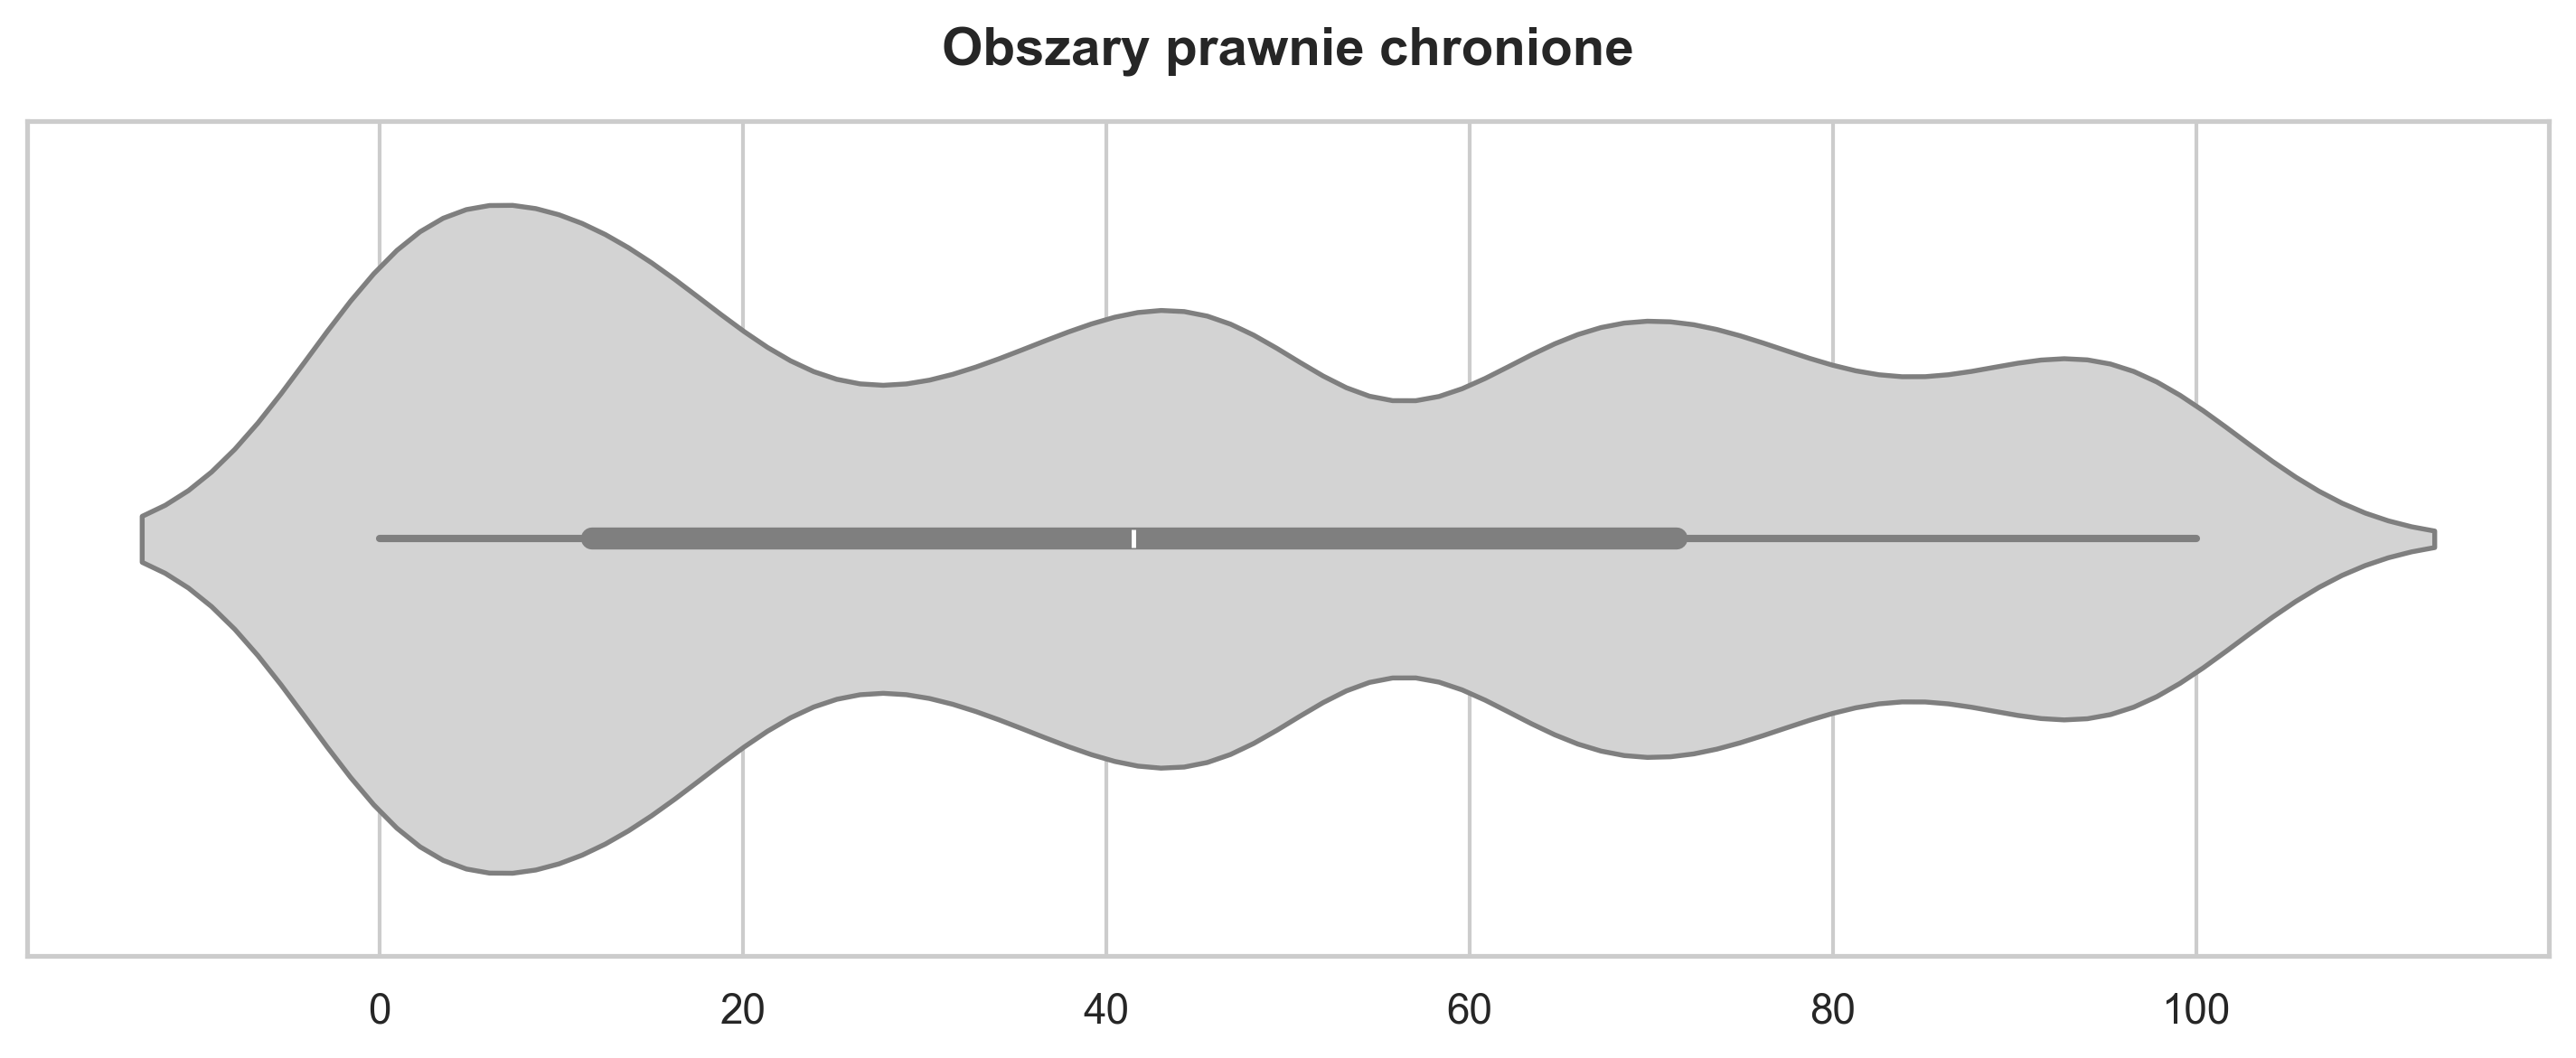

In [20]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[16],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Obszary prawnie chronione", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład jest umiarkowanie prawoskośny, co oznacza, że większość powiatów ma przeciętny udział terenów chronionych, a tylko niektóre wyróżniają się ich dużym udziałem.
<hr style="border: 0.5px solid black;">

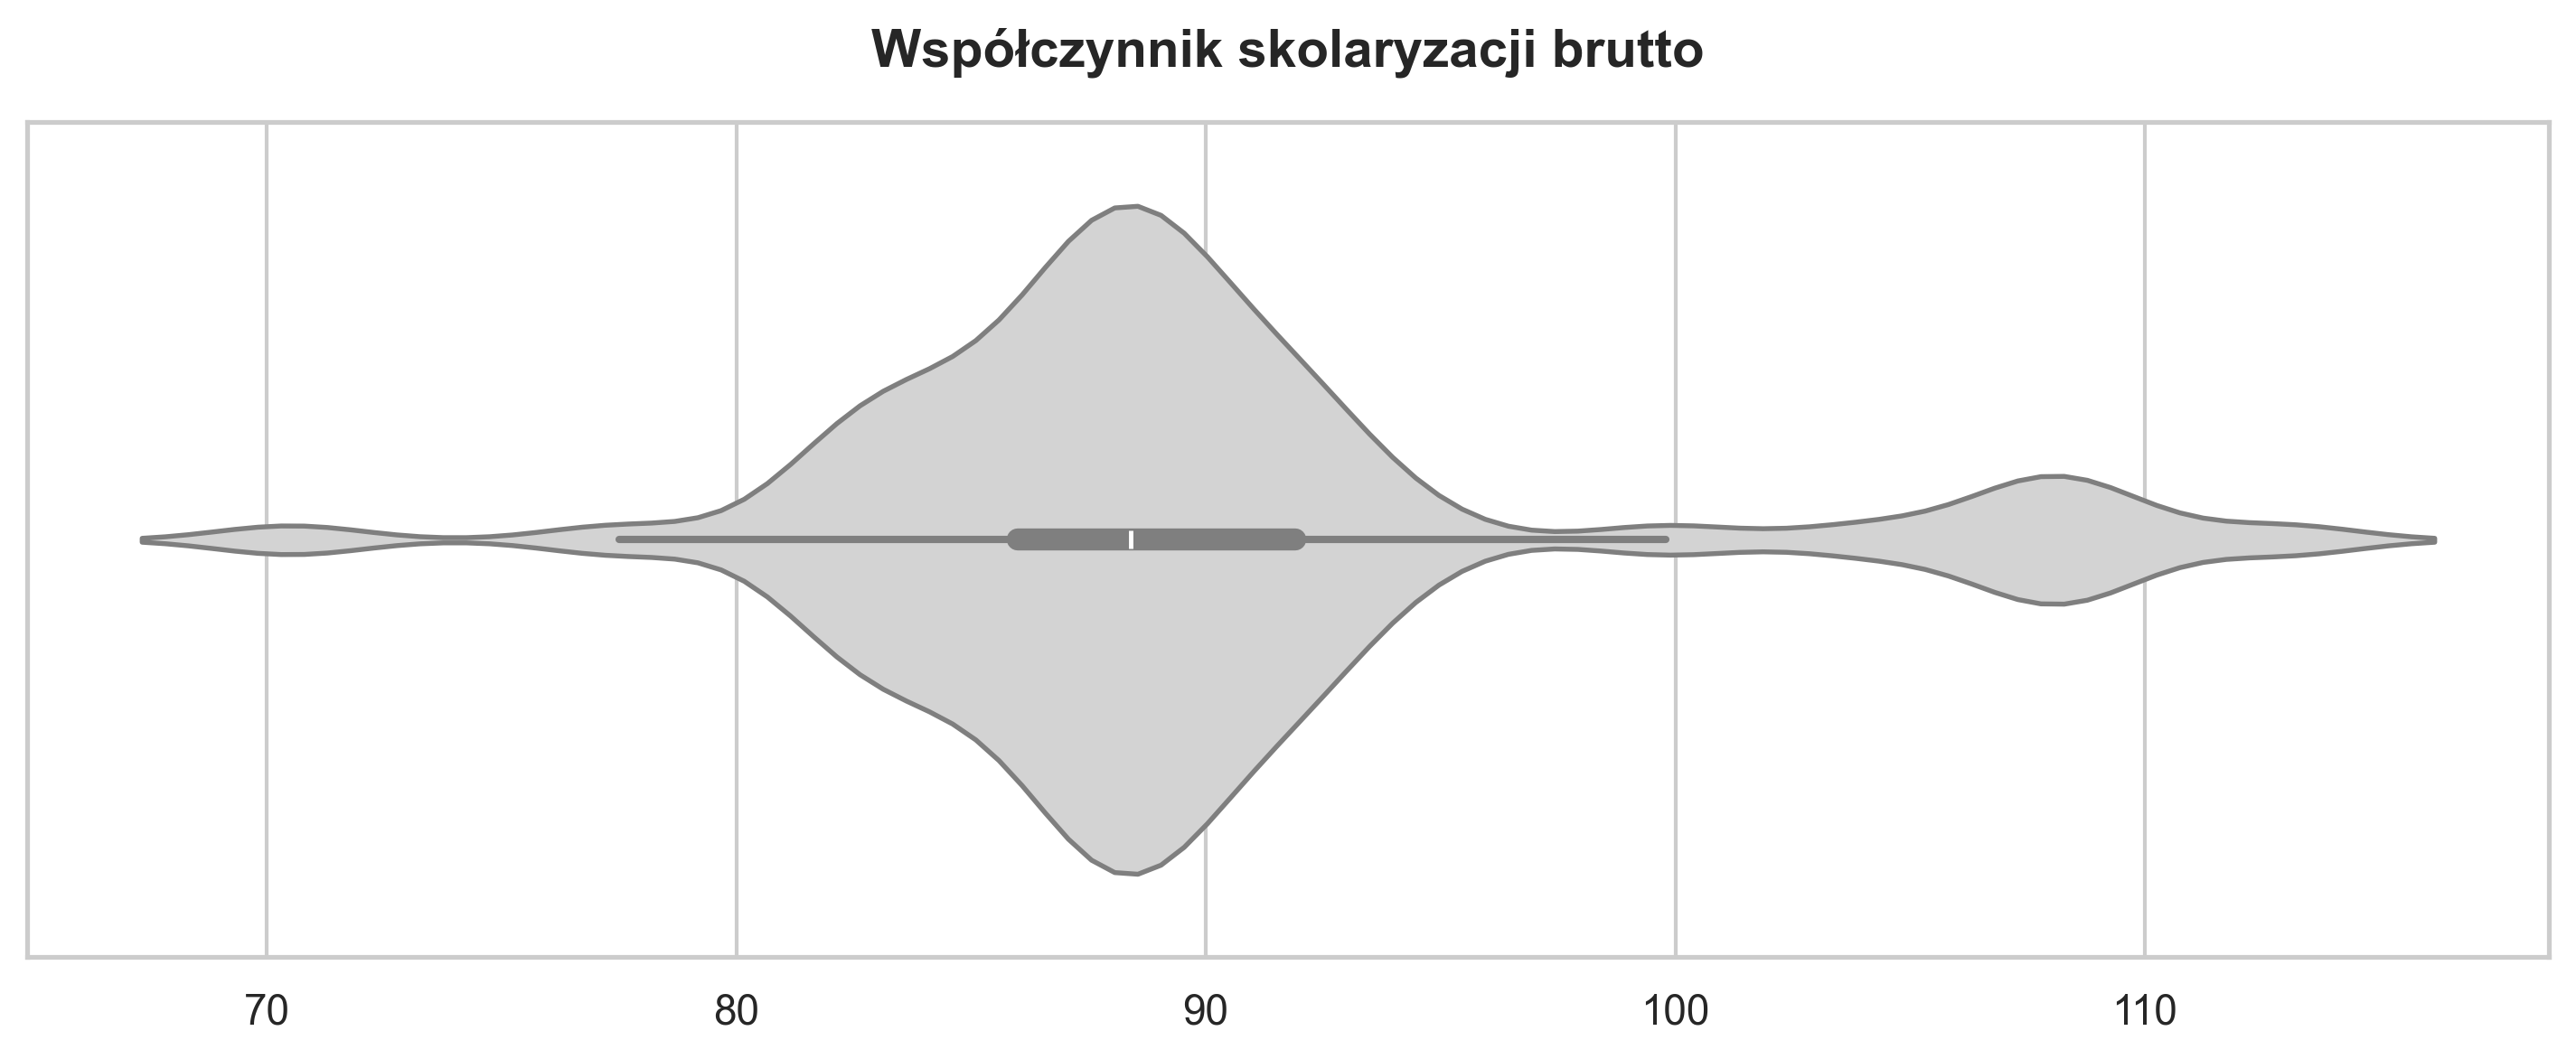

In [21]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[17],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Współczynnik skolaryzacji brutto", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład prawoskośny o umiarkowanej zmienności świadczy o dość wysokim i zbliżonym poziomie skolaryzacji w regionie. Różnice między powiatami nie są duże, co może sugerować podobny dostęp do edukacji. Należy zauważyć pojedyncze ośrodki, dla których wskaźnik ten jest znacznie wyższy.
<hr style="border: 0.5px solid black;">

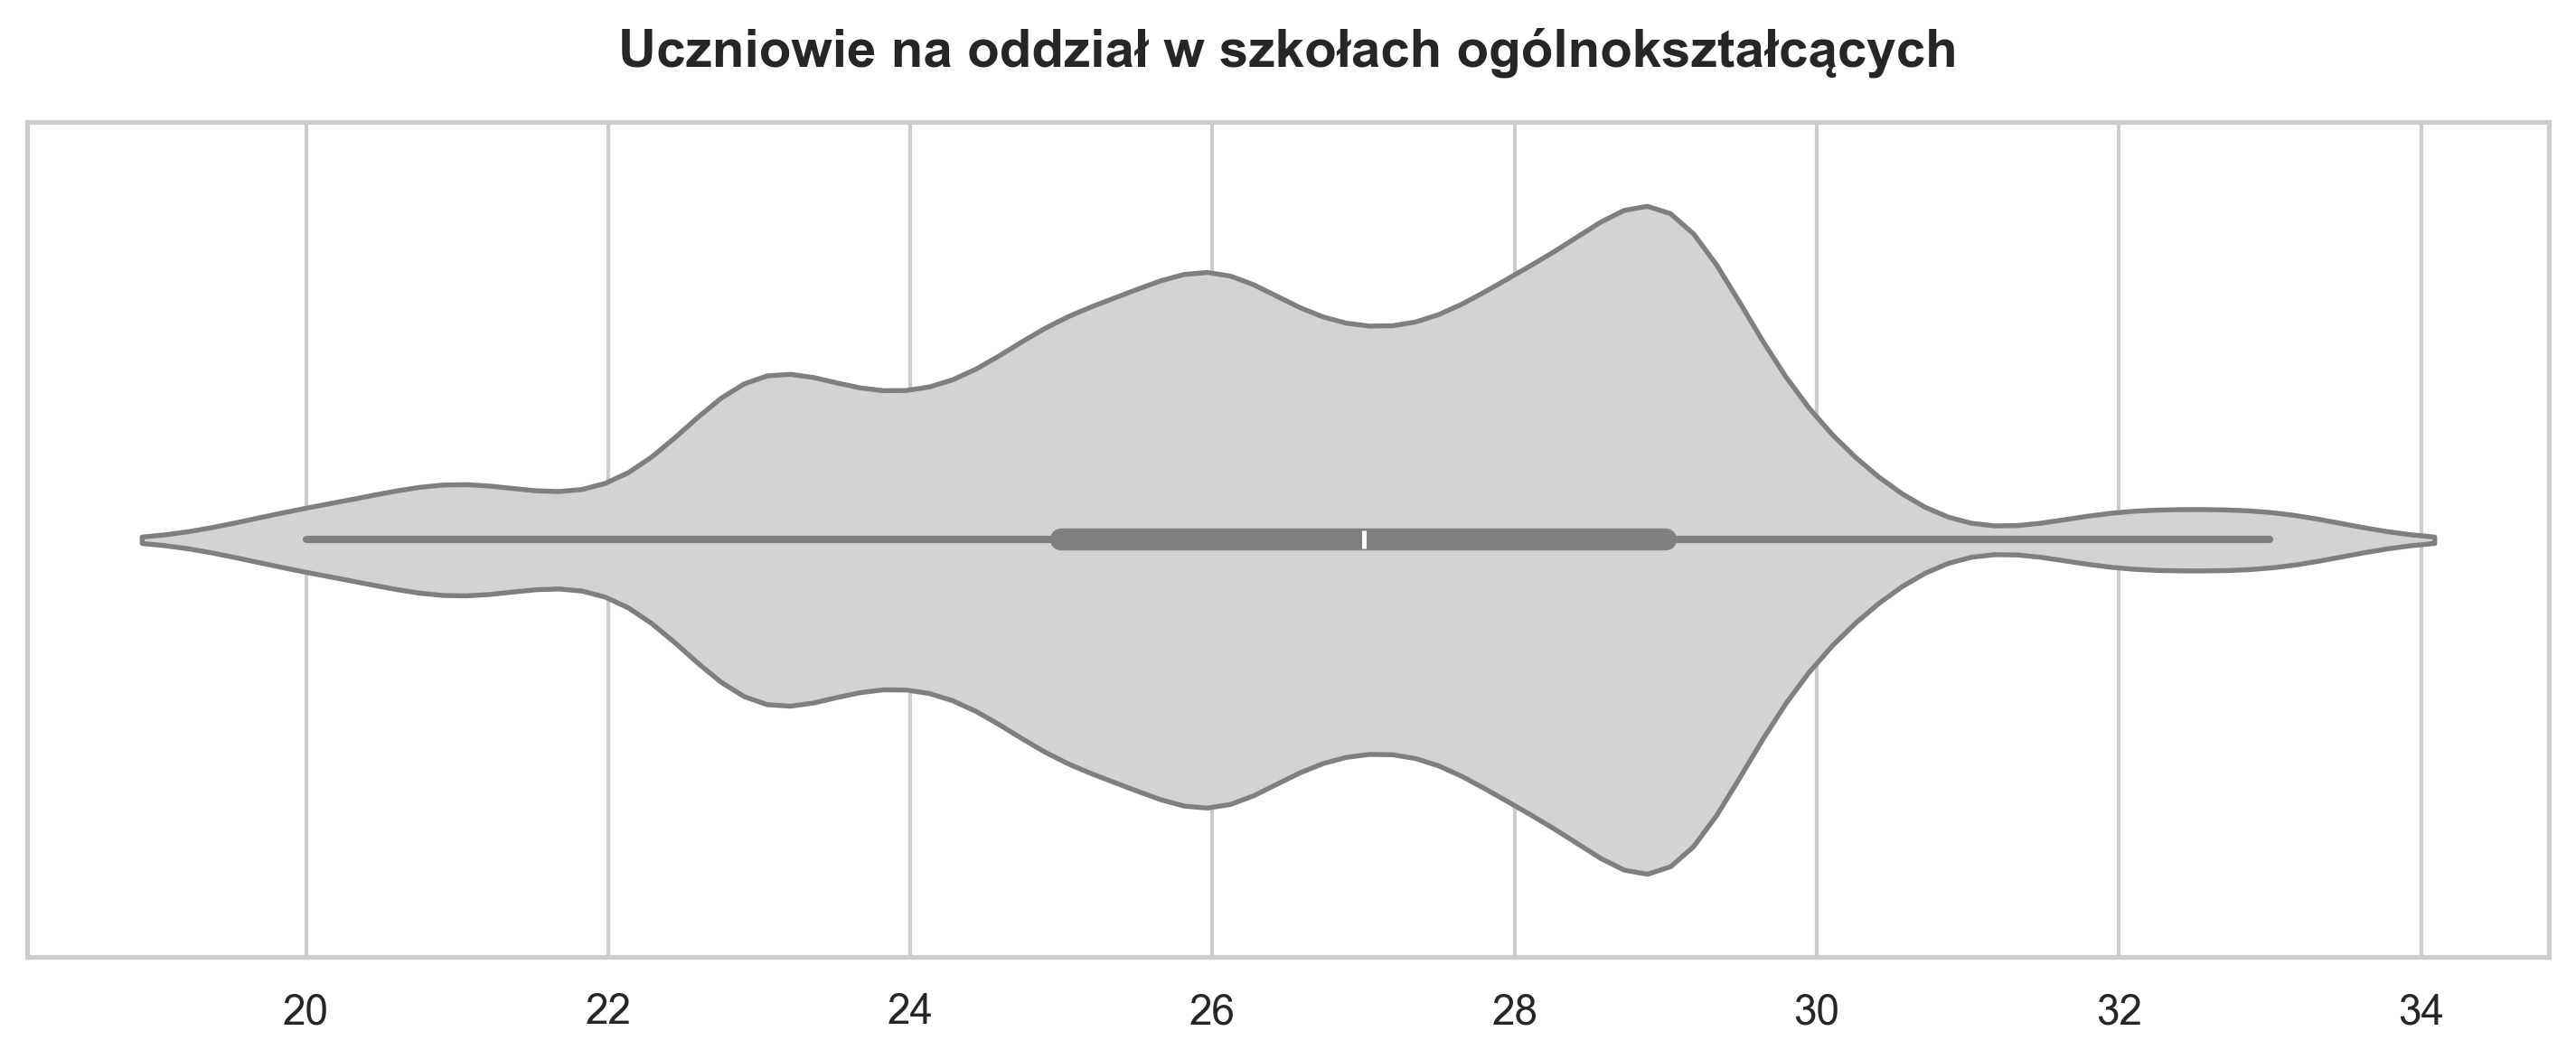

In [22]:
plt.figure(figsize=(12, 4), dpi=300)
sns.violinplot(
    x=df.columns[18],
    data=df,
    inner="box",
    color="lightgrey",
    linewidth=1.3,
    bw_method=0.2
)
plt.xlabel("")
plt.ylabel("")
plt.title("Uczniowie na oddział w szkołach ogólnokształcących", fontsize=14, fontweight='bold', pad=15)
plt.show()

Rozkład jest niemal symetryczny, a zmienność niewielka, co oznacza, że liczebność klas jest podobna w większości powiatów. Może to wskazywać na względnie wyrównane możliwości dostępu do edukacji w regionie.

### Macierz korelacji

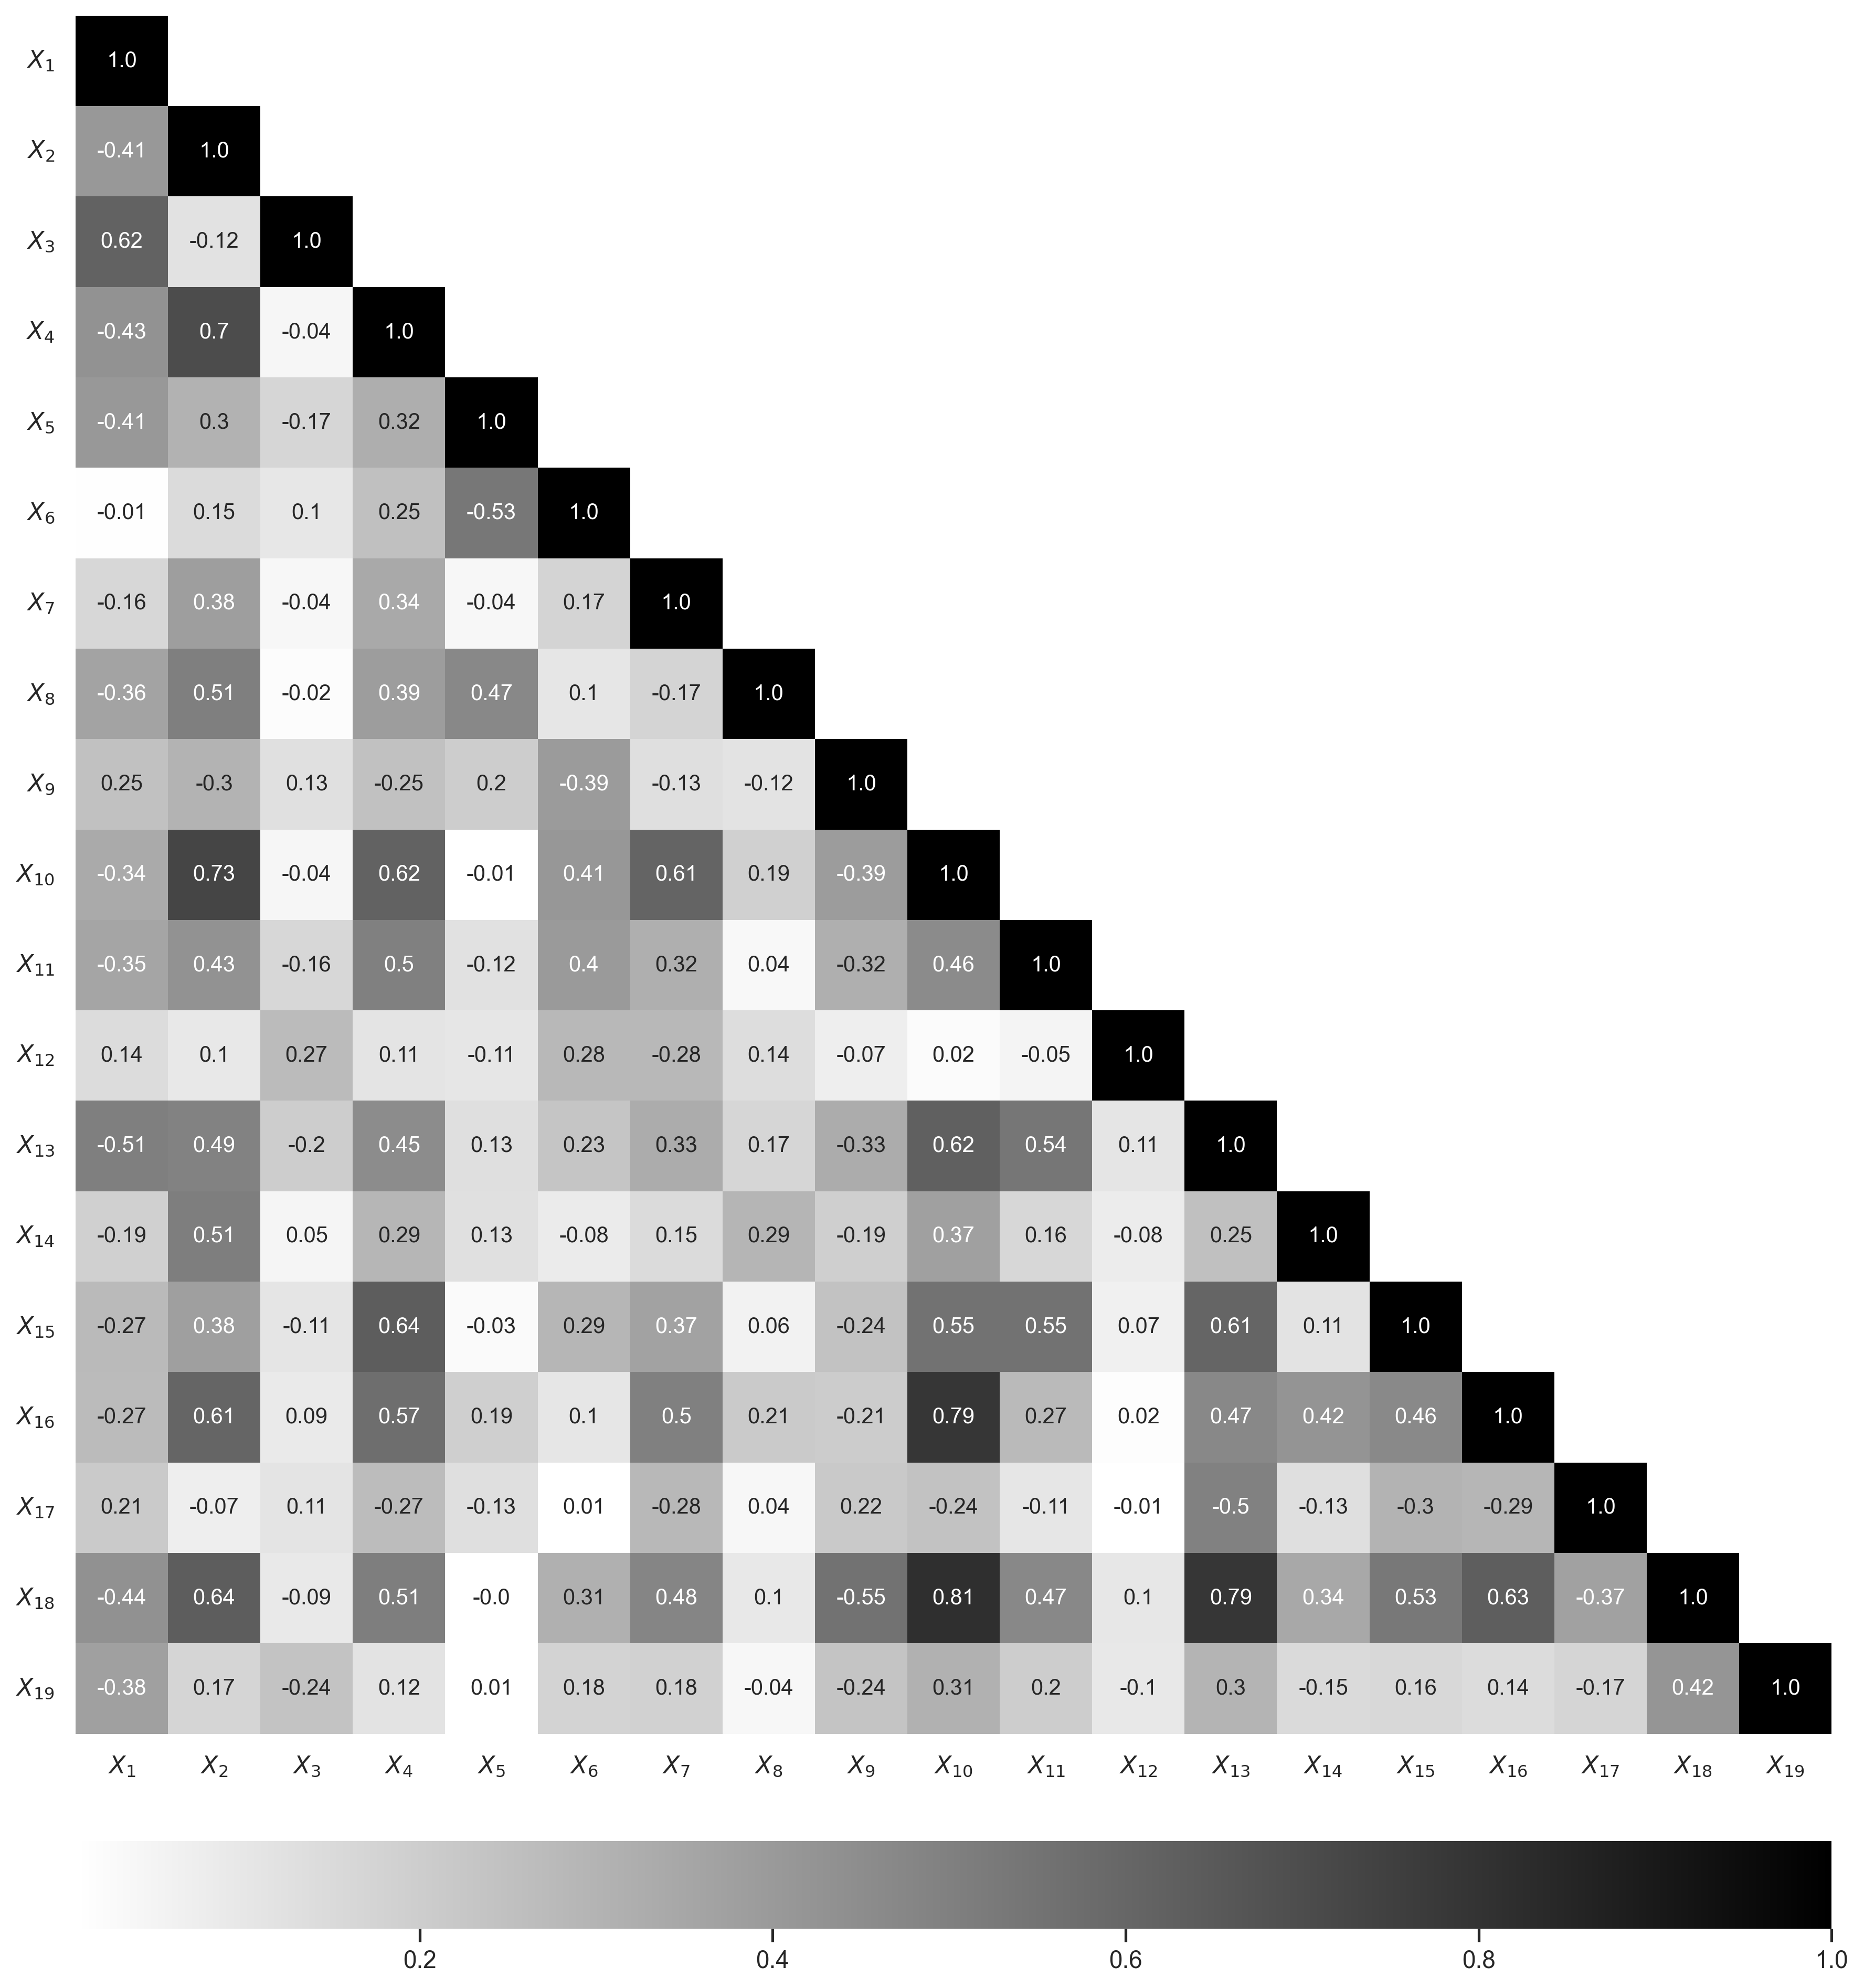

In [23]:
sns.set_theme(style="white")
plt.figure(figsize=(12, 14), dpi=300)
corr = df.corr()
cmap = mcolors.LinearSegmentedColormap.from_list(_, ["#ffffff", "#000000"])
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr.columns = [f'$X_{{{i+1}}}$' for i in range(len(corr.columns))]
corr.index = [f'$X_{{{i+1}}}$' for i in range(len(corr.columns))]
sns.heatmap(np.abs(corr), annot=corr.round(2), fmt='', cmap=cmap, mask=mask, annot_kws={"size": 10}, cbar=True, linewidths=0, linecolor='white', square=False, cbar_kws={"orientation": "horizontal", "pad": 0.05 })
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Zaobserwowano wyższy poziom korelacji między liczbą nowo zarejestrowanych podmiotów gospodarczych a przeciętnym wynagrodzeniem brutto oraz dostępnością do kadry medycznej. Może to wynikać z faktu, że regiony o większej aktywności gospodarczej generują wyższe dochody, co przyciąga specjalistów, w tym pracowników sektora medycznego, oraz umożliwia lepsze finansowanie lokalnej opieki zdrowotnej. Jednocześnie obszary o dynamicznie rozwijającej się gospodarce częściej pełnią funkcję centrów administracyjnych i usługowych, co sprzyja rozwojowi infrastruktury medycznej i wyższym wynagrodzeniom.<br><br>
Również między liczbą lekarzy przypadających na mieszkańca a udziałem terenów zielonych i poziomem skolaryzacji. Należy przypuszczać, że powiaty o dobrze rozwiniętej infrastrukturze społecznej i edukacyjnej nie tylko przyciągają wykwalifikowaną kadrę medyczną, ale również dbają o jakość środowiska miejskiego. Obecność terenów zielonych może odzwierciedlać dbałość o jakość życia mieszkańców, co z kolei sprzyja koncentracji instytucji edukacyjnych i medycznych w tych samych obszarach.<br><br>
Dodatkowo wykazano korelację między poziomem skolaryzacji a stopniem rozwoju infrastruktury. Może to sugerować, że obszary o dobrze rozwiniętej infrastrukturze – takie jak większe miasta – są naturalnymi ośrodkami edukacji i nauki. Wysoka jakość infrastruktury sprzyja koncentracji szkół wyższych, instytucji badawczych i ośrodków naukowych.

### Przygotowanie zmiennych
Większość z analizowanych cech charakteryzuje się silną prawostronną asymetrią. W celu osłabienia wpływu zdecydowano się na ograniczenie wartości zmiennych do wartości górnego lub dolnego wasą, tj. $Q_1 - 1.5 \cdot (Q_3 - Q_1)$ oraz $Q_3 + 1.5 \cdot (Q_3 - Q_1)$. W przypadku porządkowania liniowego oraz analizy skupień wartości odstające mogą znacząco wpłynąć na miary odległości i relacje między obiektami. Dodatkowo uzsadnione jest stwierdzenie, że pojedyncza element nie może w nieograniczonym stopniu wpływać na analizowane warunki życia.<br><br>

In [24]:
df = df.apply(lambda v: v.clip(lower=v.quantile(0.25) - 1.5 * (v.quantile(0.75) - v.quantile(0.25)), upper=v.quantile(0.75) + 1.5 * (v.quantile(0.75) - v.quantile(0.25))))

Dla zapewnienia porównywalności oraz zrównoważenia wpływu poszczególnych cech wszystkie zmienne diagnostyczne zostały przekształcone do wspólnej skali. W tym celu dokonano standaryzacji (normalizacji standardowej), zgodnie ze wzorem:
$$
z_{ij} = \frac{x_{ij} - \bar{x}_j}{s_j}
$$
gdzie:
* $z_{ij}$ - standaryzowana wartość j-tej zmiennej dla i-tego obiektu,
* $x_j$ - początkowa wartość j-tej zmiennej dla i-tego obiektu,
* $\bar{x}_j$ - średnia dla j-tej zmiennej,
* $s_j$ - odchylenie standardowe dla j-tej zmiennej.


In [25]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

<br>W porządkowaniu liniowym, dla technik bezwzorcowych wszystkie cechy należy zamienić na stymulanty. Podejście to również ma uzasadnienie dla technik wzorcowych. Dokonuje się tego zamieniając wartość destymulanty na $X_i^{\prime} = -X_i$.

In [26]:
indices = [0, 2, 5, 8, 10, 13, 14, 18]
df_scaled.iloc[:, indices] = -df_scaled.iloc[:, indices]

Żadna z analizowanych cech nie wykazuje bardzo silnej korelacji. W przypadku trzech zmiennych — przeciętnego wynagrodzenia, powierzchni użytkowej mieszkania oraz poziomu skolaryzacji — współczynnik zmienności wyniósł nieco poniżej 10%. Ze względu na prawdopodobną istotność tych cech dla porządkowania liniowego i analizy skupień zdecydowano jednak o ich zachowaniu. Ponadto rezygnacja z tych zmiennych nie byłaby wskazana, ponieważ umożliwia porównanie ocen warunków życia powiatów południowo-wschodniej Polski z wcześniejszym opracowaniem z 2019 r., w którym zastosowano te same zmienne.

## Porządkowanie liniowe
### Zastosowane metody
Jako bezwzorcową technikę porządkowania liniowego wykorzystano **metodę standaryzowanych sum**. Po zamianie zmiennych na stymulanty i standaryzacji należy zsumować oszacowanie uzyskane
ramach obiektu tj. $s_i = \frac{1}{m} \sum_{j=1}^{m} z_{ij}$. Dla uzyskanego wskaźnika można dokonać normalizacji.<br><br>

Jako wzorcową technikę porządkowania liniowego wykorzystano **metodę Hellwiga**. Po zamianie zmiennych na stymulanty i standaryzacji należy wyznaczyć wzorzec zgodnie ze wzorem: $z_{0j} = \max\limits_{i=1,\dots,n} z_{ij}$. Następnie wyznaczyć odległości wszystkich obiektów od wzorca (np. z wykorzystaniem metryki euklidesowej) tj. $d_i = \sqrt{\sum_{j=1}^{m} (z_{ij} - z_{0j})^2}$. W kolejnym etapie należy utworzyć synetyczny miernik, wskaźnik Hellwiga jako $s_i = 1 - \frac{d_i}{d_0}$, gdzie $d_0 = \bar{d} + 2 \cdot s_d$ (odłegłość *możliwie daleka*).

Dla interpetacji wyników zastosowano grupowanie według średniej:
* grupa I (najwyższy poziom): $r \geq \bar{x} + s_x$
* grupa II (poziom ponadprzeciętny): $\bar{x} \leq r < \bar{x} + s_x$
* grupa III (poziom poniżej przeciętnej): $\bar{x} - s_x \leq r < \bar{x}$
* grupa IV (poziom najniższy): $r < \bar{x} - s_x$

### Otrzymane rankingi

In [27]:
wzorzec = df_scaled.max()
d_i = np.sqrt(((df_scaled - wzorzec) ** 2).sum(axis=1))
d_mean = np.mean(d_i)
d_sd = np.std(d_i)
d_0 = d_mean + 2 * d_sd
s = 1 - d_i / d_0

def assign_group(r, z):
    z_mean = np.mean(z)
    z_sd = np.std(z)
    if r >= z_mean + z_sd:
        return "I"
    elif r >= z_mean:
        return "II"
    elif r >= z_mean - z_sd:
        return "III"
    else:
        return "IV"

df_Hellwig = pd.DataFrame({
    's_Hellwig': s,
    'grupa_Hellwig': [assign_group(r, s) for r in s]
}, index=df_scaled.index)
df_Hellwig['rank_Hellwig'] = df_Hellwig['s_Hellwig'].rank(ascending=False, method='min').astype(int)

sum_std = df_scaled.sum(axis=1)
sum_std = (sum_std - sum_std.min()) / (sum_std.max() - sum_std.min())
df_sum_std = pd.DataFrame({
    's_sum': sum_std,
    'grupa_sum': [assign_group(r, sum_std) for r in sum_std]
}, index=df_scaled.index)
df_sum_std['rank_sum'] = df_sum_std['s_sum'].rank(ascending=False, method='min').astype(int)

df_display = pd.concat([df_Hellwig, df_sum_std], axis=1)
df_display = df_display.sort_values("s_Hellwig", ascending=False).round(3)
df_display.columns = ['$s_i$', 'Gr.', 'Poz.', '$s_i$', 'Gr.', 'Poz.']
df_display.insert(0, 'Powiat', df_display.index)

mid = len(df_display) // 2
left = df_display.iloc[:mid]
right = df_display.iloc[mid:]

header = """
<thead>
<tr>
    <th></th>
    <th colspan="3" style="text-align:center;">Hellwig</th>
    <th colspan="3" style="text-align:center;">Standaryzowane sumy</th>
</tr>

</thead>
"""

html = f"""
<div style="display: flex; flex-wrap: wrap; gap: 10px;">
    <div>{left.to_html(index=False, escape=False).replace('<thead>', header)}</div>
    <div>{right.to_html(index=False, escape=False).replace('<thead>', header)}</div>
</div>
"""

display(HTML(html))

### Mapy podziałów na grupy

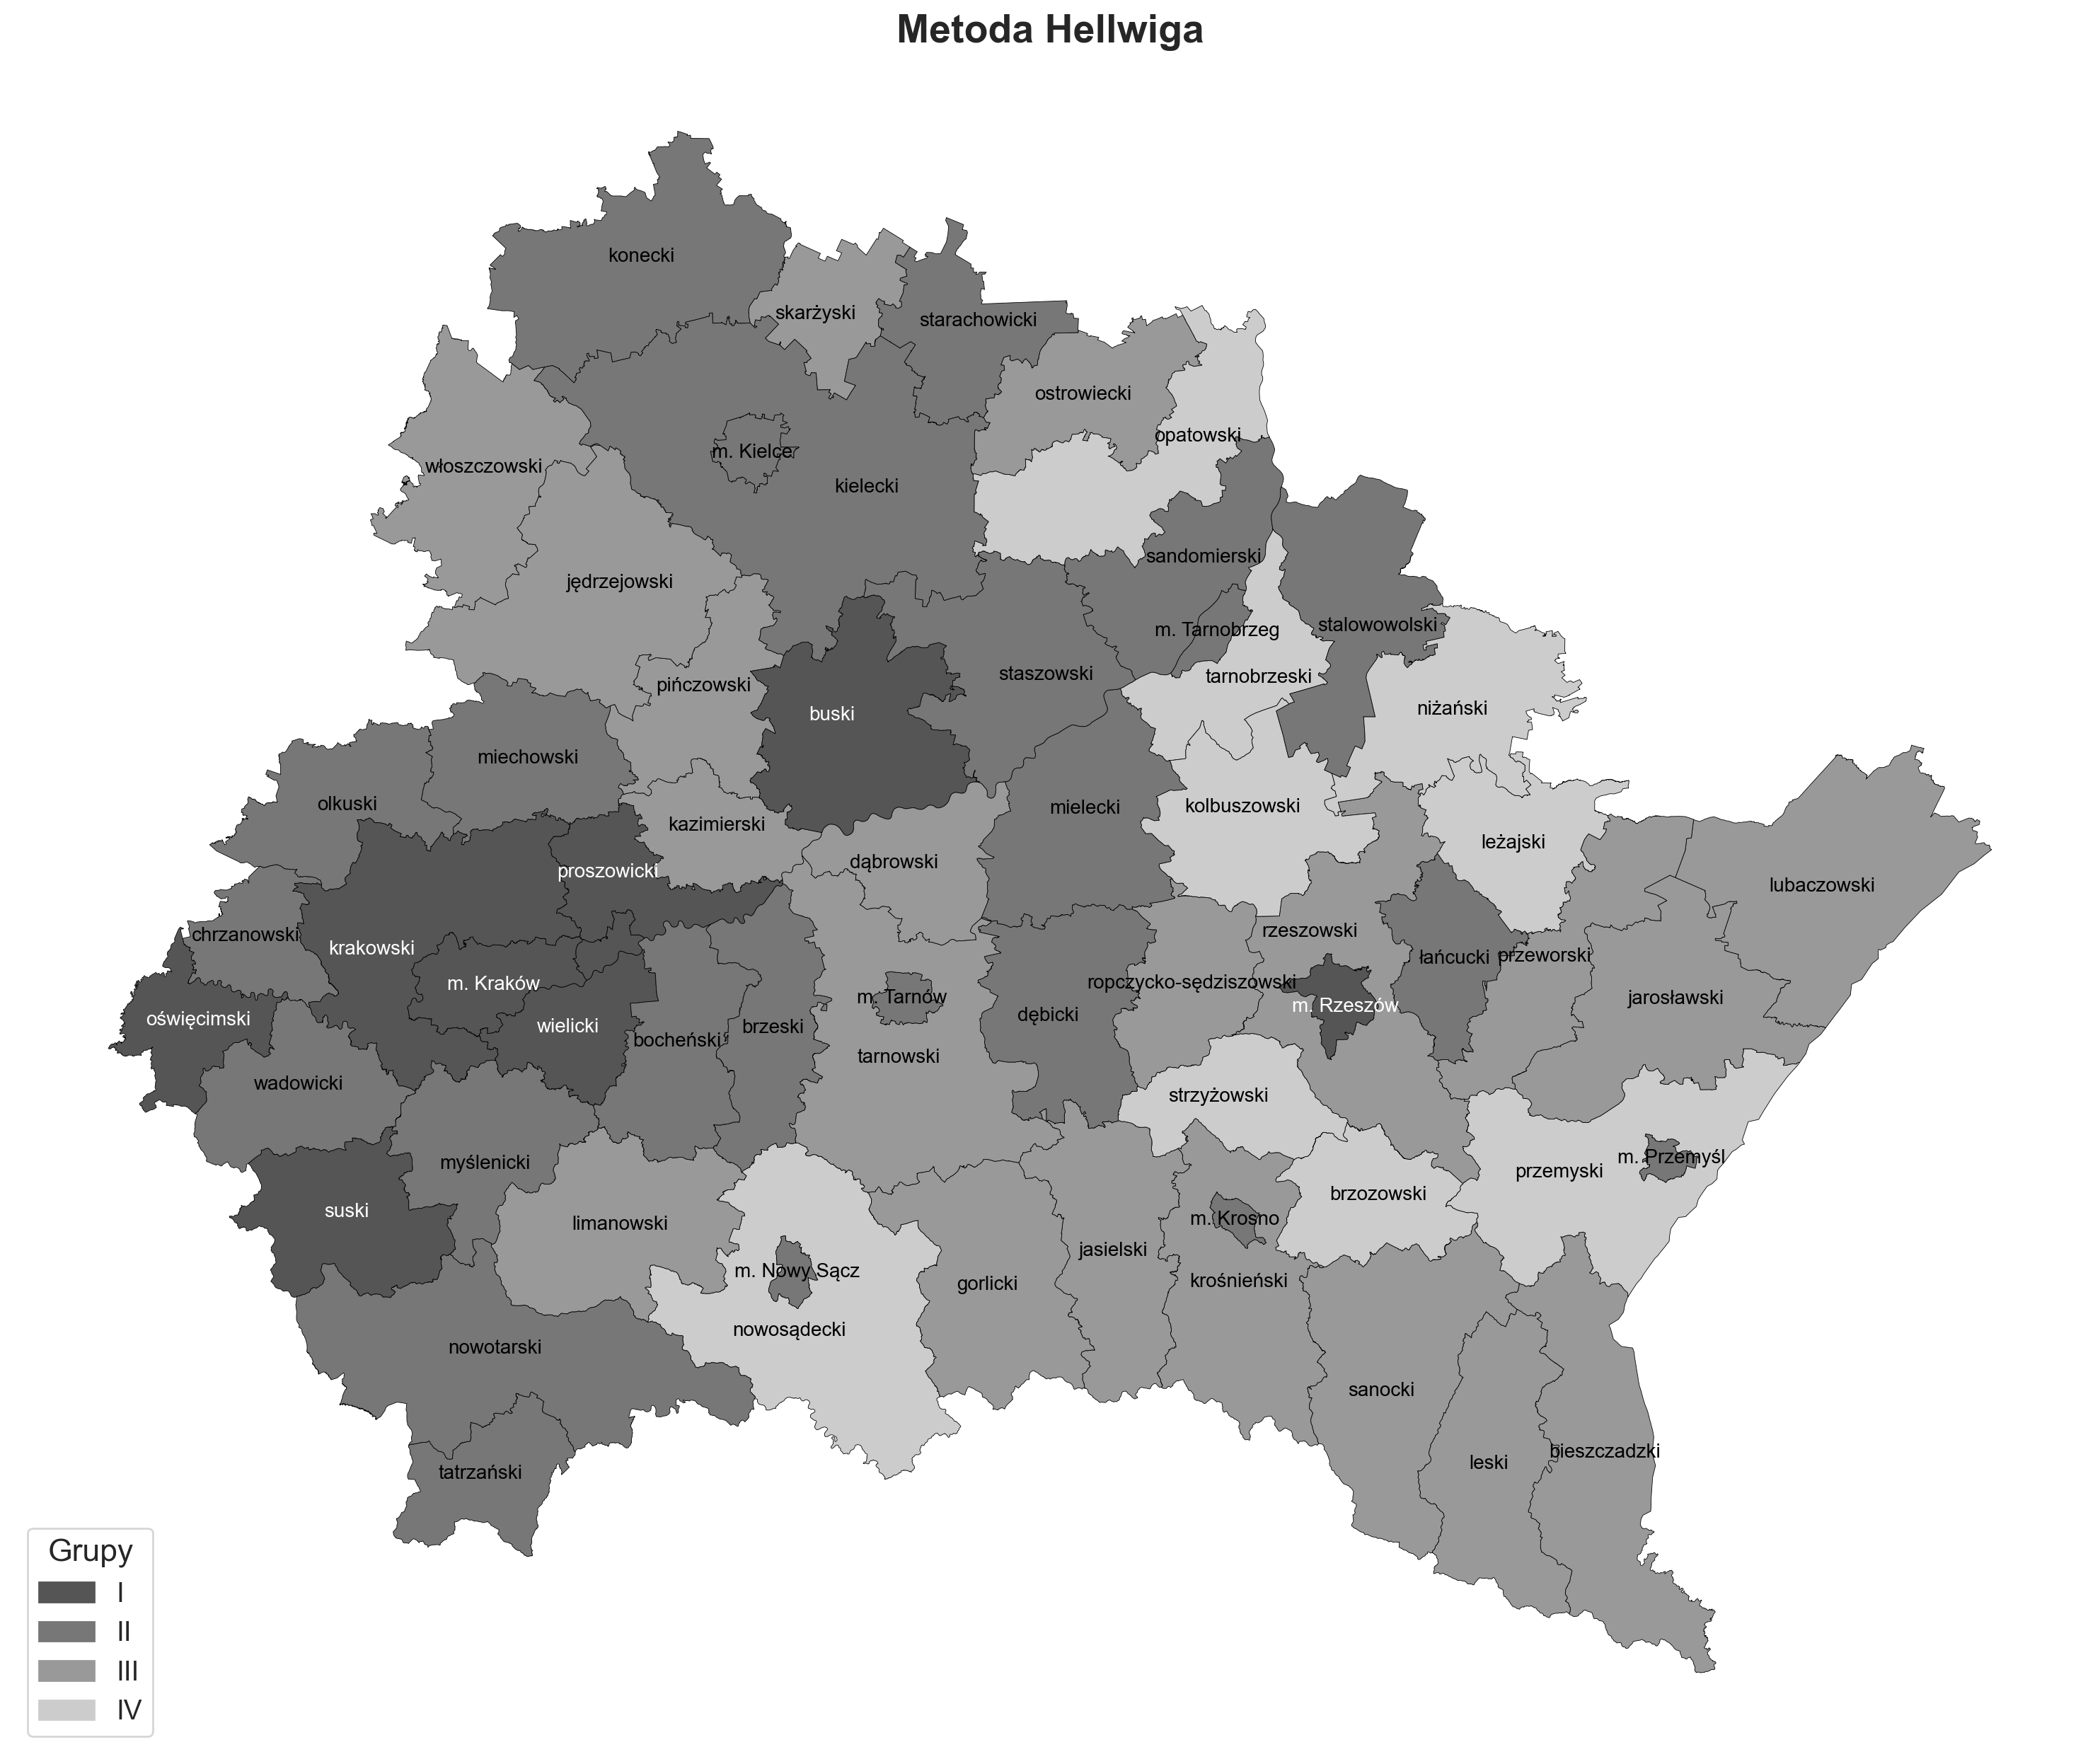

In [28]:
mapa_korekcyjna = {
 'bocheński':'bocheĺ\x84ski','dąbrowski':'dä\x85browski','dębicki':'dä\x99bicki',
 'jarosławski':'jarosĺ\x82awski','jędrzejowski':'jä\x99drzejowski','kraków':'krakăłw',
 'krośnieński':'kroĺ\x9bnieĺ\x84ski','leżajski':'leĺźajski','myślenicki':'myĺ\x9blenicki',
 'niżański':'niĺźaĺ\x84ski','nowosądecki':'nowosä\x85decki','nowy sącz':'nowy sä\x85cz',
 'oświęcimski':'oĺ\x9bwiä\x99cimski','pińczowski':'piĺ\x84czowski','przemyśl':'przemyĺ\x9bl',
 'ropczycko-sędziszowski':'ropczycko-sä\x99dziszowski','rzeszów':'rzeszăłw',
 'skarżyski':'skarĺźyski','strzyżowski':'strzyĺźowski','tarnów':'tarnăłw',
 'tatrzański':'tatrzaĺ\x84ski','włoszczowski':'wĺ\x82oszczowski','łańcucki':'ĺ\x82aĺ\x84cucki'
}

clean = lambda c: str(c).replace('\xa0',' ').replace('m. ','').replace('powiat ','').lower().strip()

g = gpd.read_file('A02_Granice_powiatow.shp', encoding='ISO-8859-2')
g['nazwa'] = g['JPT_NAZWA_'].apply(clean)

dm = df_Hellwig.copy()
dm['nazwa'] = dm.index.to_series().apply(clean).replace(mapa_korekcyjna)
dm['nazwa_do_tekstu'] = dm.index

cols = {'I':'#555555', 'II':'#777777', 'III':'#999999', 'IV':'#cccccc'}

m = g.merge(dm, on='nazwa').drop_duplicates('nazwa', keep='first')
m['grp'] = m['grupa_Hellwig'].fillna('Brak').str.strip()
m['kol'] = m['grp'].map(cols).fillna('#eeeeee')

fig, ax = plt.subplots(figsize=(15,15), dpi=200)
m.plot(color=m['kol'], ax=ax, edgecolor='black', linewidth=0.3)

ax.legend(
    handles=[mpatches.Patch(color=cols[g], label=g) for g in ['I','II','III','IV']],
    title='Grupy',
    loc='lower left',
    fontsize=14,
    title_fontsize=16
)

manual_offsets = {
    "tarnobrzeski": (-0.05, -0.05),
    "tarnowski": (0.00, -0.05),
    "nowosądecki": (0.00, -0.03),
    "rzeszowski": (0.07, 0.07)
}

for idx, row in m.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    dx, dy = manual_offsets.get(row['nazwa_do_tekstu'], (0, 0))
    text_color = 'white' if row['kol'] == '#555555' else 'black'
    ax.text(x+dx, y+dy, row['nazwa_do_tekstu'], fontsize=10, ha='center', va='center', color=text_color)

ax.set_title('Metoda Hellwiga', fontsize=20, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

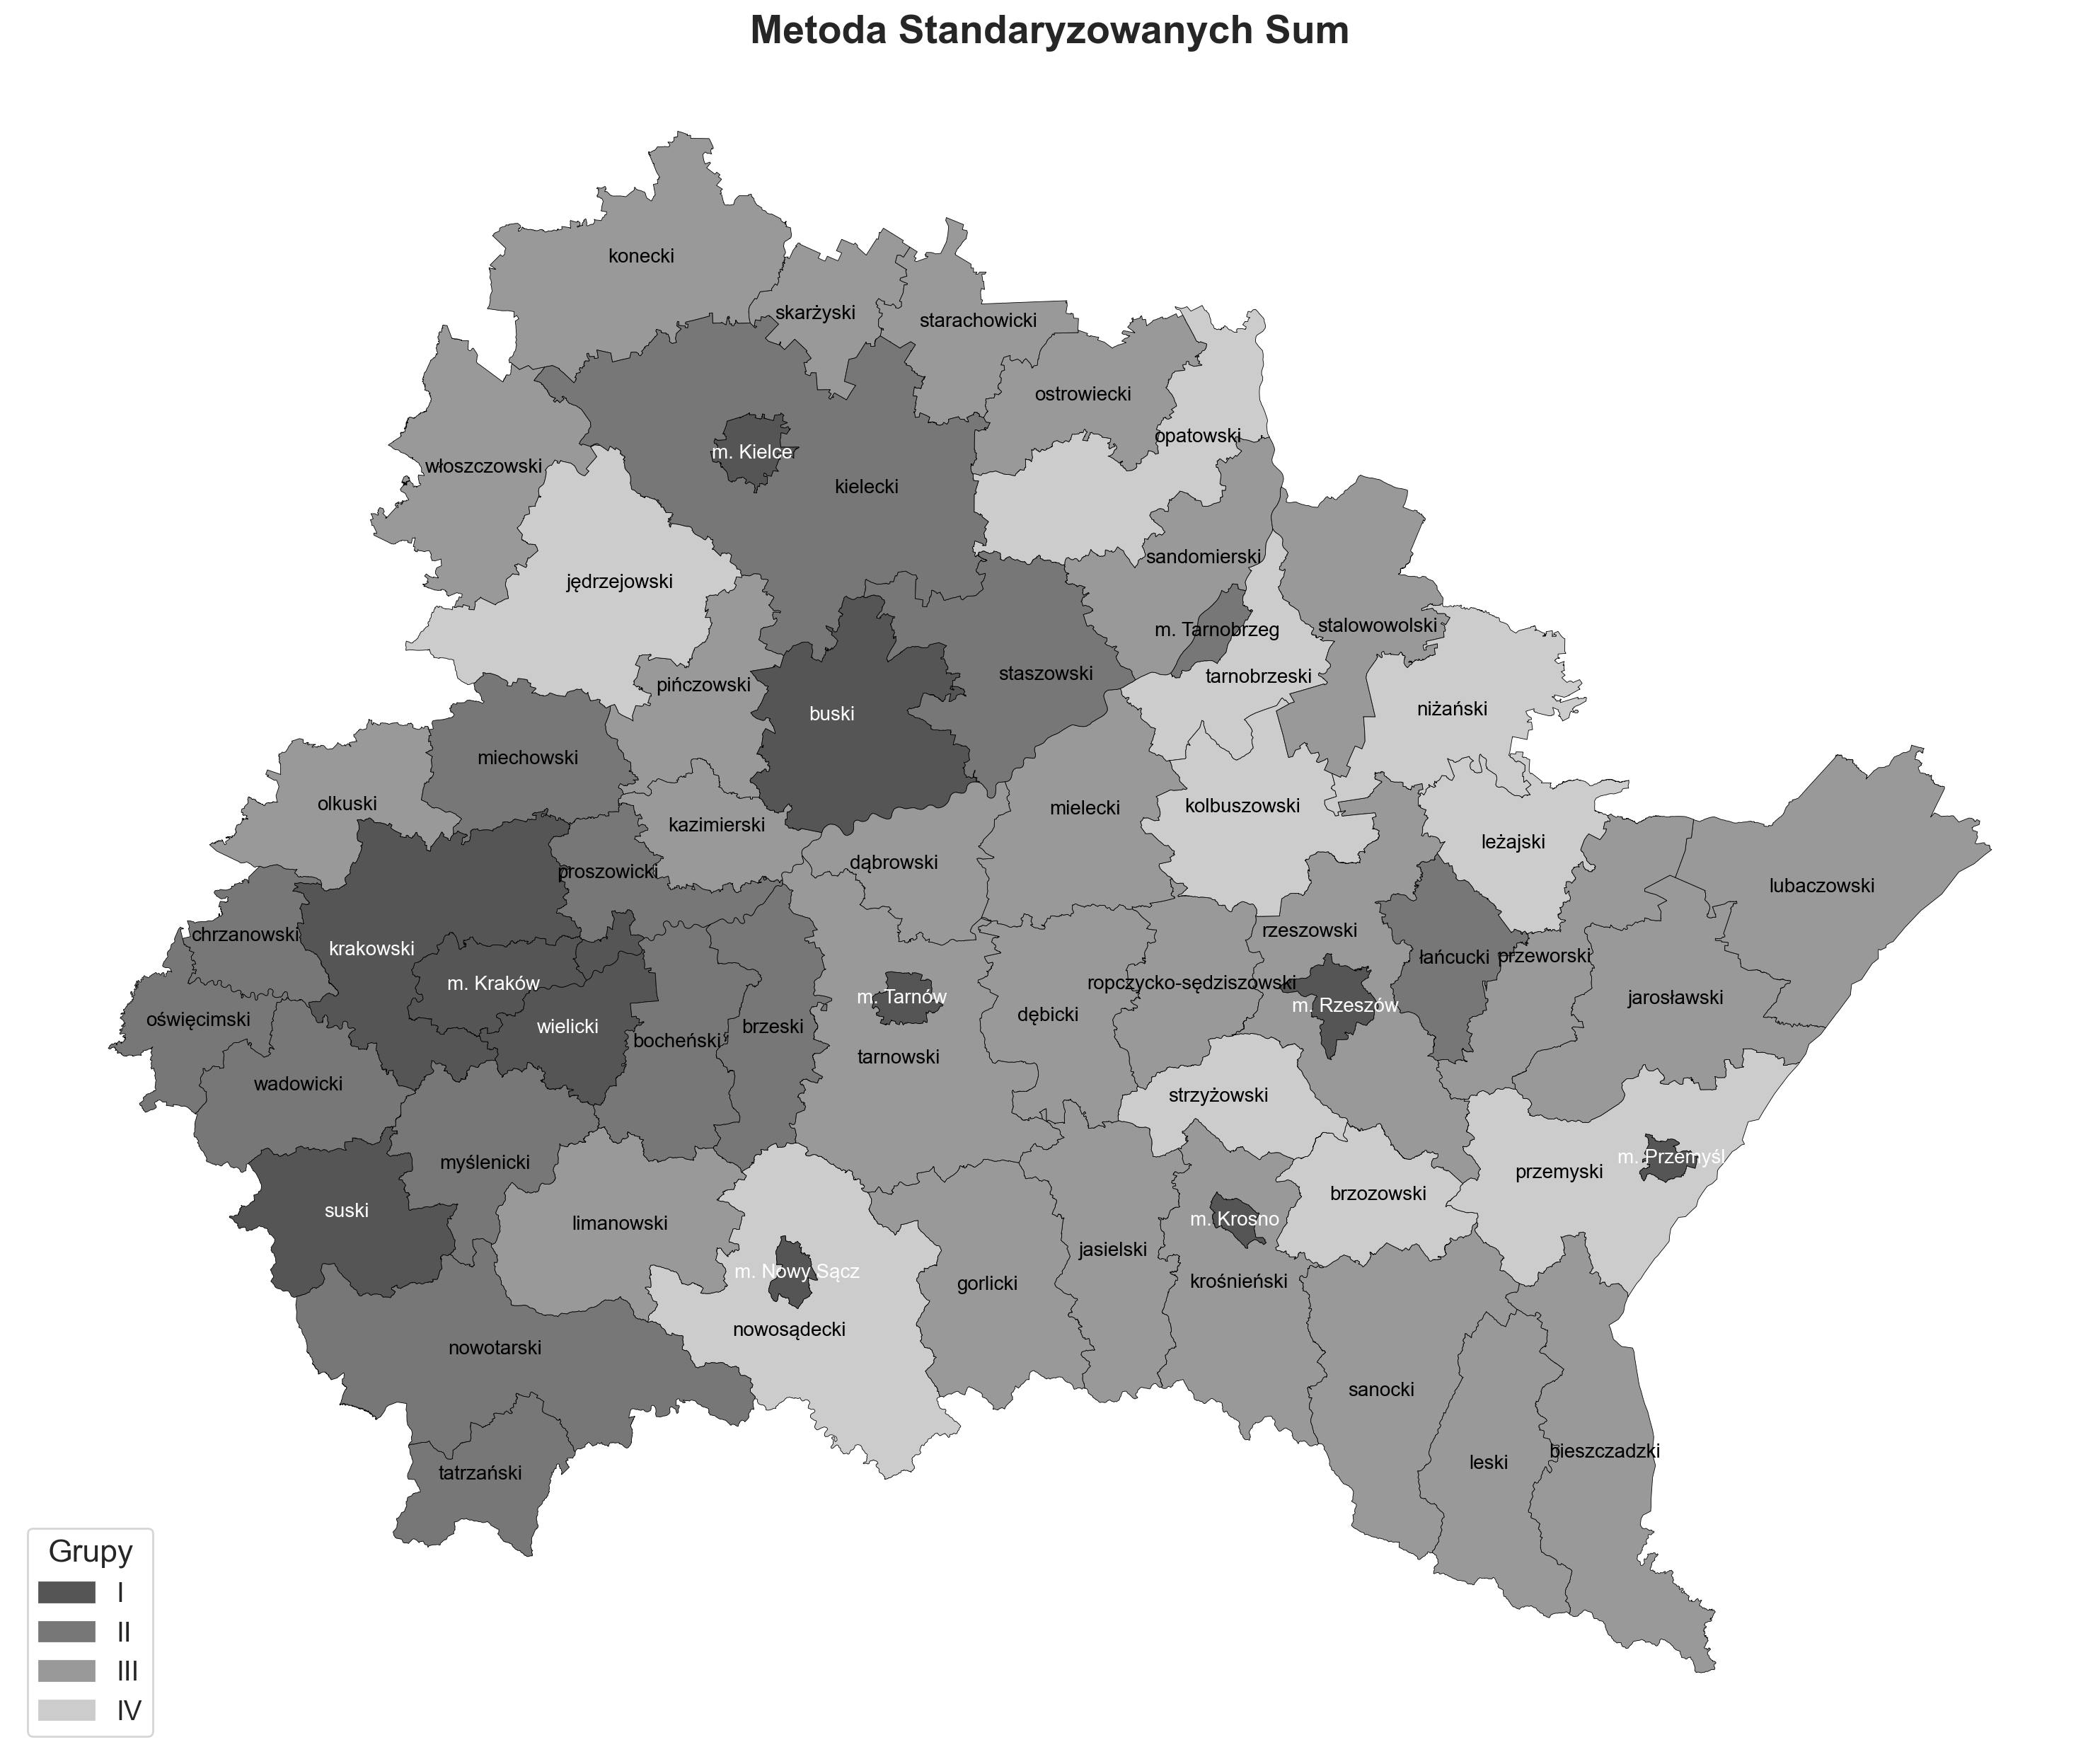

In [29]:
g = gpd.read_file('A02_Granice_powiatow.shp', encoding='ISO-8859-2')
g['nazwa'] = g['JPT_NAZWA_'].apply(clean)

dm = df_sum_std.copy()
dm['nazwa'] = dm.index.to_series().apply(clean).replace(mapa_korekcyjna)
dm['nazwa_do_tekstu'] = dm.index

cols = {'I':'#555555', 'II':'#777777', 'III':'#999999', 'IV':'#cccccc'}

m = g.merge(dm, on='nazwa').drop_duplicates('nazwa', keep='first')
m['grp'] = m['grupa_sum'].fillna('Brak').str.strip()
m['kol'] = m['grp'].map(cols).fillna('#eeeeee')

fig, ax = plt.subplots(figsize=(15,15), dpi=200)
m.plot(color=m['kol'], ax=ax, edgecolor='black', linewidth=0.3)

ax.legend(
    handles=[mpatches.Patch(color=cols[g], label=g) for g in ['I','II','III','IV']],
    title='Grupy',
    loc='lower left',
    fontsize=14,
    title_fontsize=16
)

manual_offsets = {
    "tarnobrzeski": (-0.05, -0.05),
    "tarnowski": (0.00, -0.05),
    "nowosądecki": (0.00, -0.03),
    "rzeszowski": (0.07, 0.07)
}

for idx, row in m.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    dx, dy = manual_offsets.get(row['nazwa_do_tekstu'], (0, 0))
    text_color = 'white' if row['kol'] == '#555555' else 'black'
    ax.text(x+dx, y+dy, row['nazwa_do_tekstu'], fontsize=10, ha='center', va='center', color=text_color)

ax.set_title('Metoda Standaryzowanych Sum', fontsize=20, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### Wnioski
Zastosowane metody porządkowania liniowego – Hellwiga oraz standaryzowanych sum – dały zbliżone wyniki w klasyfikacji powiatów. Obie metody są zgodne co do lidera rankingu, jednoznacznie wskazując m. Kraków na pierwszej pozycji w najwyższej klasie (grupa I). Największe rozbieżności widoczne są w klasyfikacji innych dużych miast: metoda standaryzowanych sum przyporządkowała m. Kielce, m. Tarnów, m. Nowy Sącz oraz m. Przemyśl do grupy I, podczas gdy w metodzie Hellwiga znalazły się one w niższej w grupie II. Występują również znaczące różnice w środkowych grupach; przykładowo powiaty sandomierski i olkuski zostały znacznie wyżej ocenione przez metodę Hellwiga (grupa II) niż przez metodę sum (grupa III).<br><br>
Metody Hellwiga i standaryzowanych sum wykazują bardzo wysoką zgodność porządkowania obiektów, co potwierdzają współczynniki korelacji Tau-Kendalla (0,83) i Spearmana (0,92). Obie korelacje są statystycznie istotne (p < 0,001), co oznacza, że uzyskane wyniki pokrywają się w znacznym stopniu. Można zatem uznać, że wybór jednej z metod nie wpływa znacząco na końcowe wnioski rankingowe.

In [30]:
tau, _ = kendalltau(df_Hellwig['grupa_Hellwig'], df_sum_std['grupa_sum'])
rho, _ = spearmanr(s, sum_std)

## Analiza skupień
### Zastosowane metody
Jako technikę grupowania podziałowego wykorzystano **metodę k-średnich**, która działa iteracyjnie i polega na podziale zbioru danych na k klastrów w taki sposób, aby obiekty w tym samym klastrze były jak najbardziej podobne, a różne klastry jak najbardziej od siebie odseparowane. Losowo wybiera się k centroidów, następnie przypisuje obiekty do najbliższego centroidu, aktualizuje je na podstawie średnich przypisanych punktów i powtarza te kroki aż do osiągnięcia zbieżności. Do doboru wartości parametru k wykorzystano metodę elbow (łokciową), którą dąży do zminimalizowania zmienności wewnątrz wszystkich klastrów.<br><br>

Jako technikę grupowania hierarchicznego wykorzystano **metodę Warda**, która działa iteracyjnie i polega na łączeniu obserwacji w klastry w taki sposób, aby minimalizować wzrost wariancji wewnątrzklastrowej. Liczbę klastrów określono na podstawie wskaźnika Calińskiego–Harabasza, który ocenia jakość podziału poprzez porównanie wariancji międzyklastrowej do wariancji wewnątrzklastrowej. Wyższe wartości wskaźnika wskazują na lepsze rozdzielenie i większą spójność klastrów.

### Metoda k-średnich
#### Wybór wartości parametru k

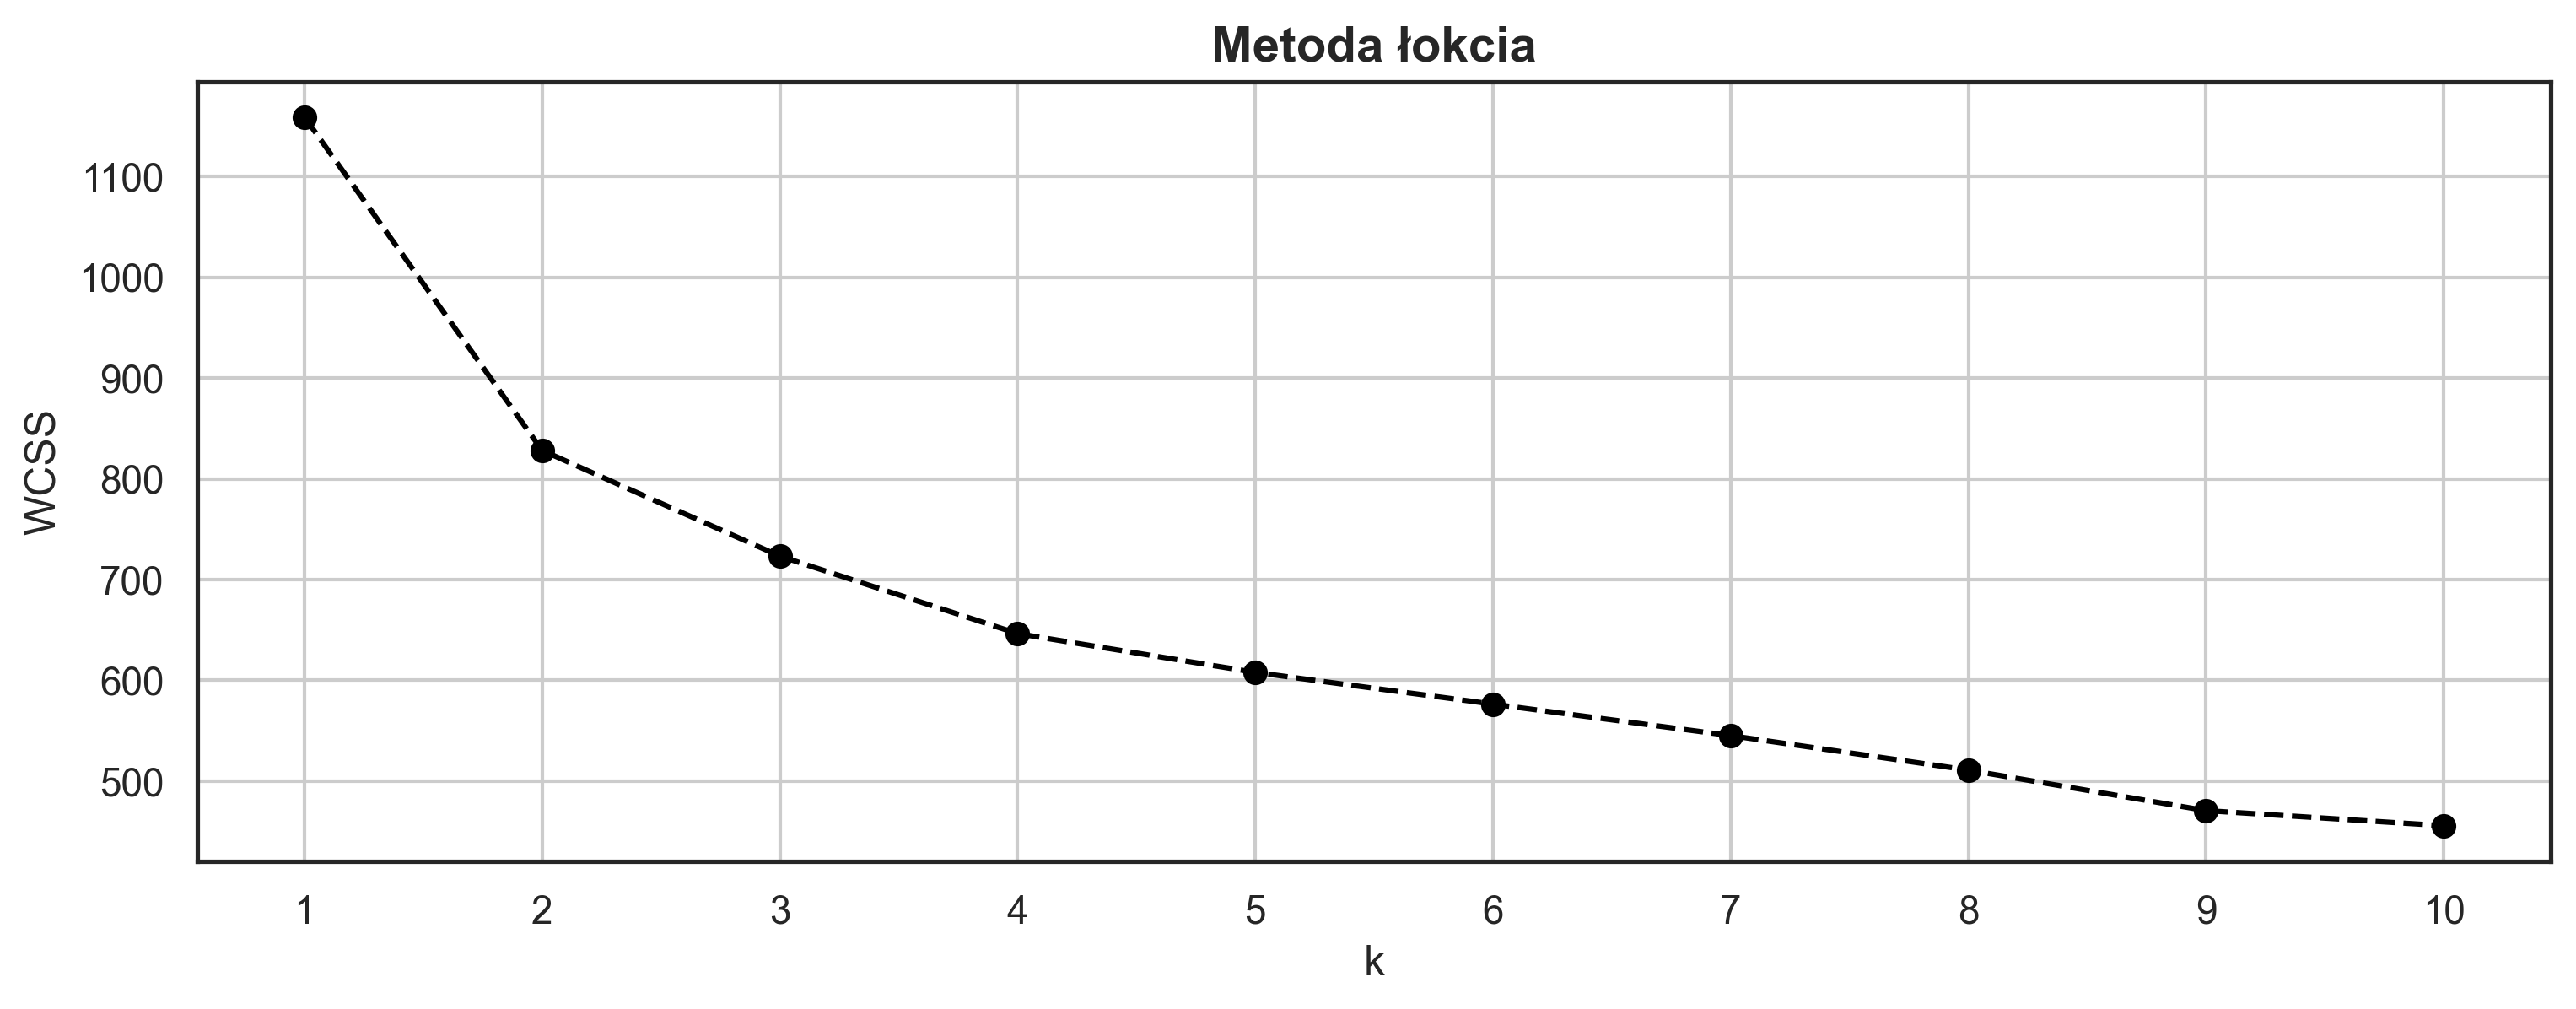

In [31]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=10,
                    random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 4), dpi=300)
plt.plot(K_range, inertia, marker='o', linestyle='--', color="black")
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Metoda łokcia', fontweight='bold', fontsize=14)
plt.xticks(K_range)
plt.grid(True)
plt.show()

Jako optymalną wartość paramateru, tzn. wartość, dla której dalsze zwiększanie liczby klastrów nie przynosi znaczącego spadku WCSS (tzw. *łokieć*), przyjęto cztery.
#### Mapa klastrów

In [32]:
k = 4
kmeans_final = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df_kmeans = df.copy()
df_kmeans['cluster'] = kmeans_final.fit_predict(df_scaled) + 1

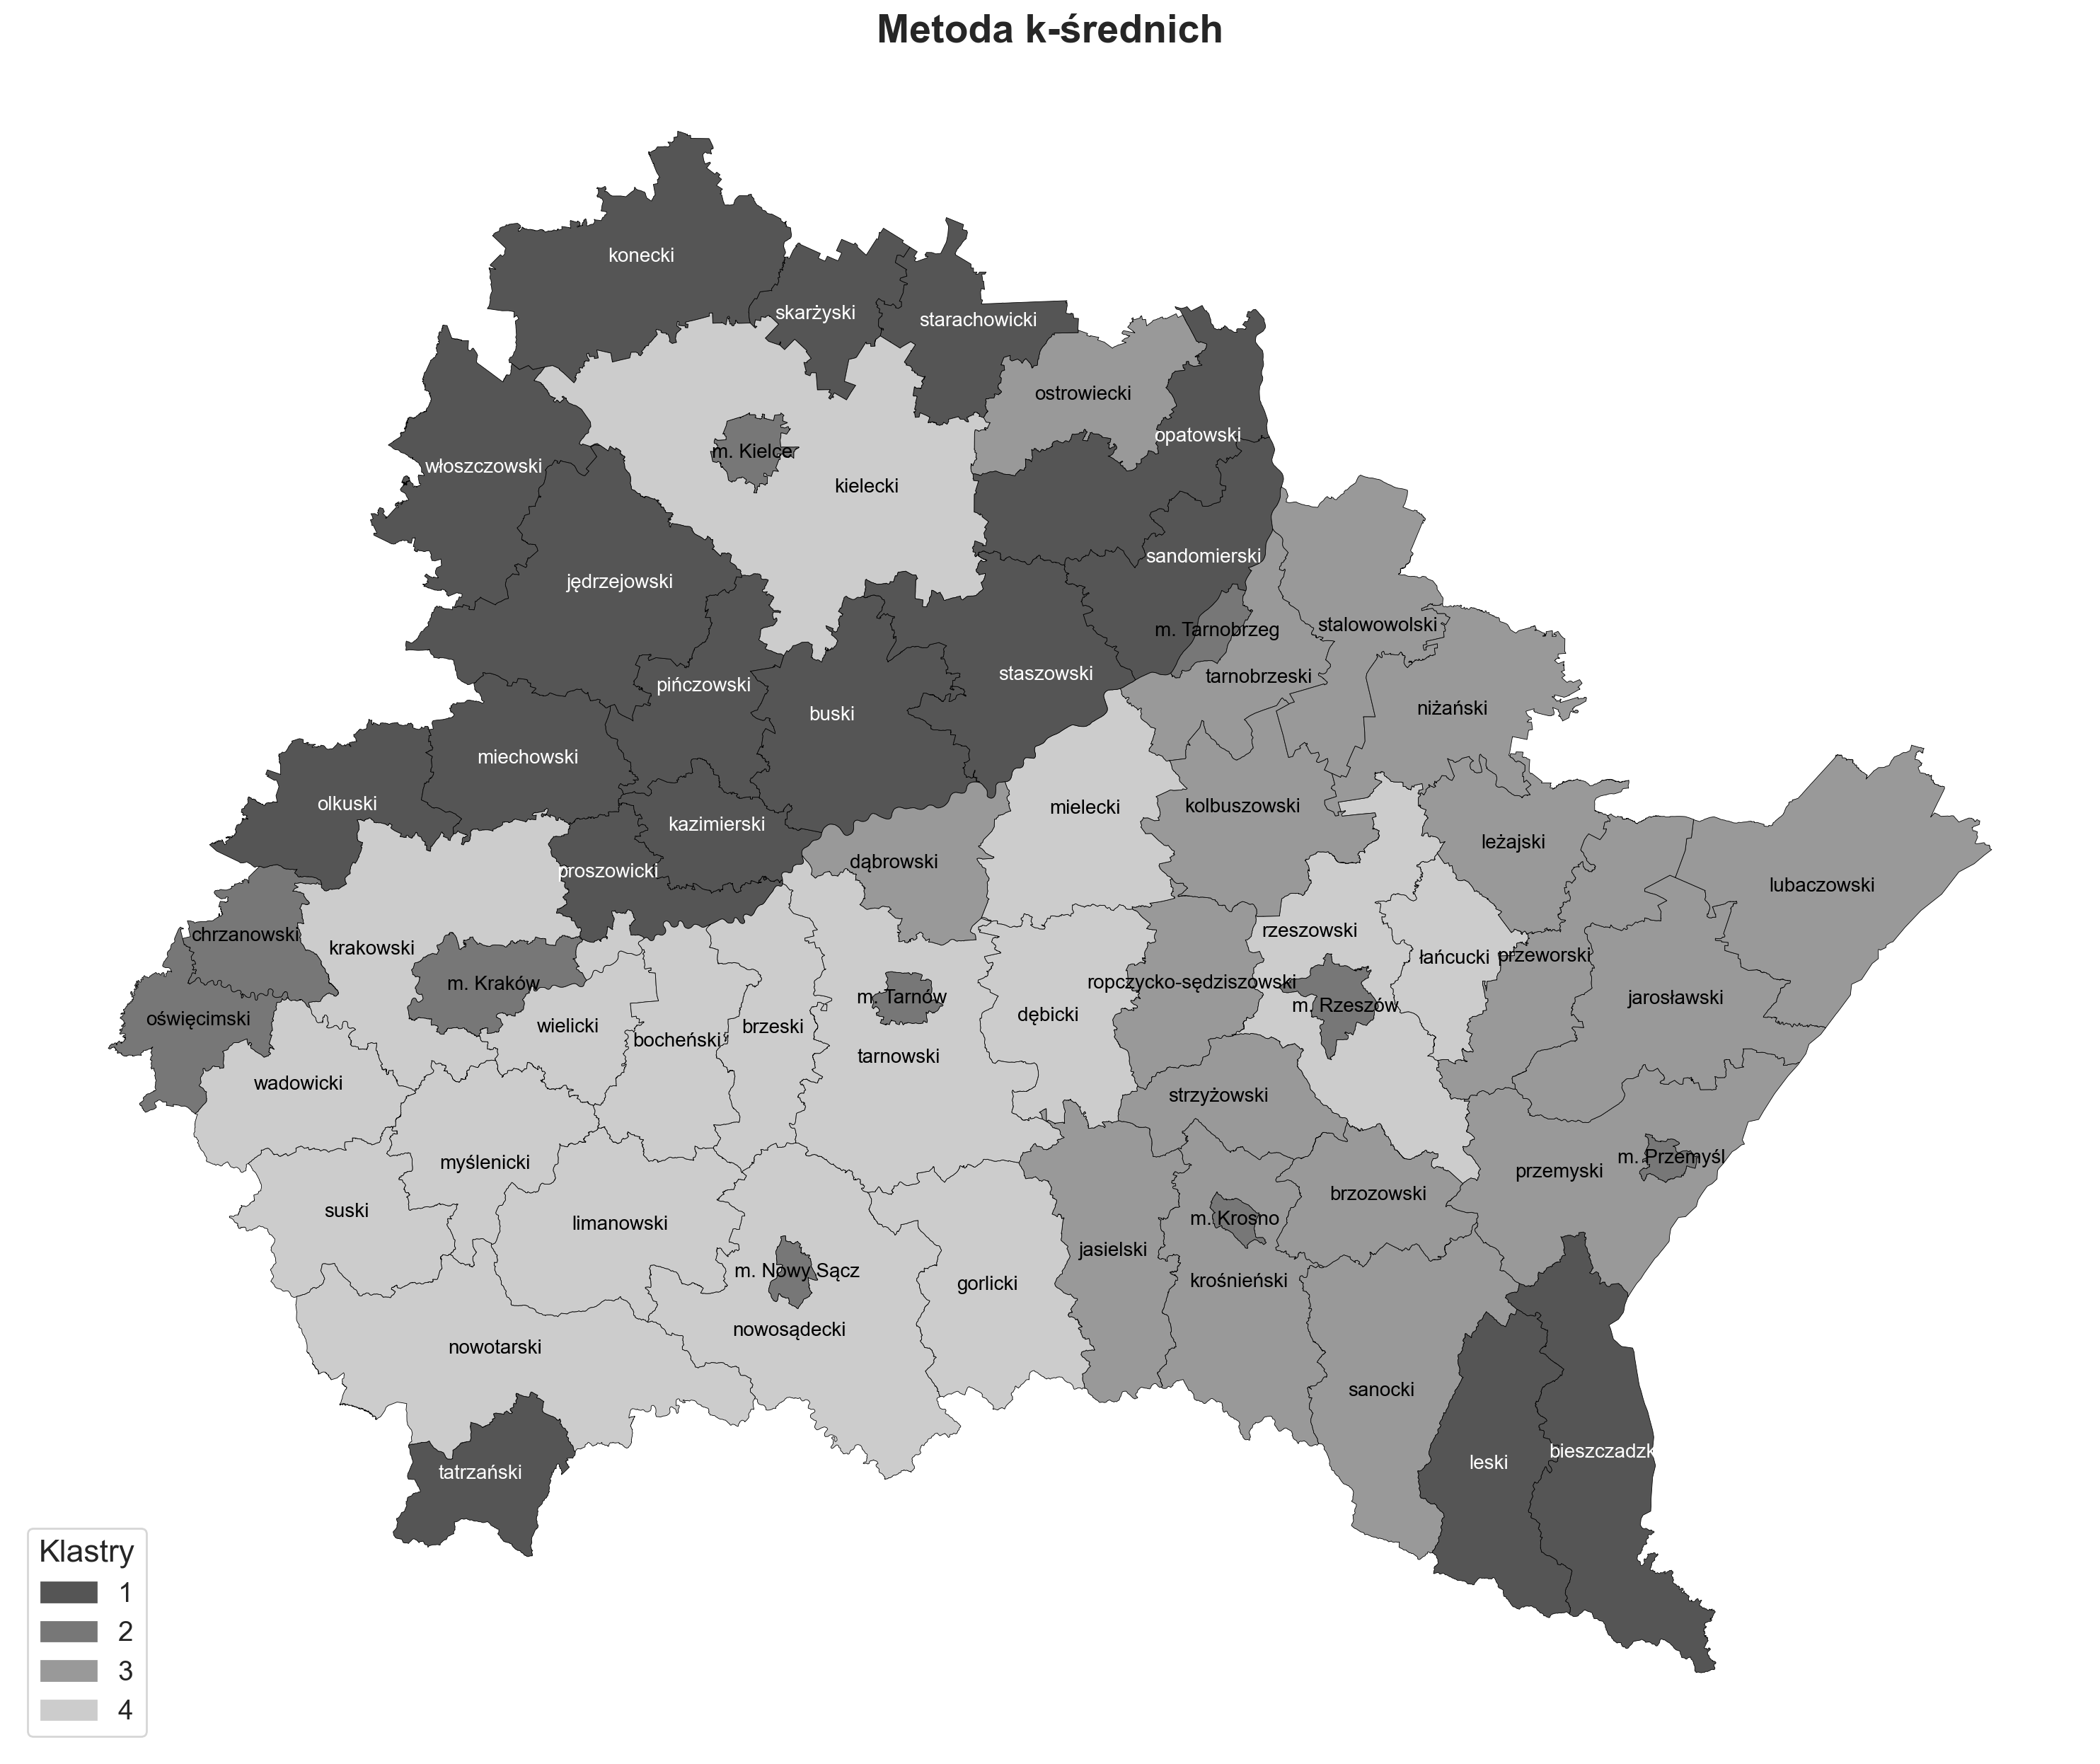

In [33]:
g = gpd.read_file('A02_Granice_powiatow.shp', encoding='ISO-8859-2')
g['nazwa'] = g['JPT_NAZWA_'].apply(clean)

dm = df_kmeans.copy()
dm['nazwa'] = dm.index.to_series().apply(clean).replace(mapa_korekcyjna)
dm['nazwa_do_tekstu'] = dm.index

cols = {1:'#555555', 2:'#777777', 3:'#999999', 4:'#cccccc'}

m = g.merge(dm, on='nazwa').drop_duplicates('nazwa', keep='first')
m['grp'] = m['cluster'].fillna(0).astype(int)
m['kol'] = m['grp'].map(cols).fillna('#eeeeee')

fig, ax = plt.subplots(figsize=(15,15), dpi=200)
m.plot(color=m['kol'], ax=ax, edgecolor='black', linewidth=0.3)

ax.legend(
    handles=[mpatches.Patch(color=cols[g], label=g) for g in [1,2,3,4]],
    title='Klastry',
    loc='lower left',
    fontsize=14,
    title_fontsize=16
)

manual_offsets = {
    "tarnobrzeski": (-0.05, -0.05),
    "tarnowski": (0.00, -0.05),
    "nowosądecki": (0.00, -0.03),
    "rzeszowski": (0.07, 0.07)
}

for idx, row in m.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    dx, dy = manual_offsets.get(row['nazwa_do_tekstu'], (0, 0))
    text_color = 'white' if row['kol'] == '#555555' else 'black'
    ax.text(x+dx, y+dy, row['nazwa_do_tekstu'], fontsize=10, ha='center', va='center', color=text_color)

ax.set_title('Metoda k-średnich', fontsize=20, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

#### Statystyki dla klastrów

In [34]:
group1 = df_kmeans[df_kmeans['cluster'] == 1].drop(columns='cluster')
desc1 = group1.describe().T[['mean', 'std']]
desc1.columns = ['Średnia', 'Odch. std.']
desc1.columns = pd.MultiIndex.from_product([['Klaster 1'], desc1.columns])

group2 = df_kmeans[df_kmeans['cluster'] == 2].drop(columns='cluster')
desc2 = group2.describe().T[['mean', 'std']]
desc2.columns = ['Średnia', 'Odch. std.']
desc2.columns = pd.MultiIndex.from_product([['Klaster 2'], desc2.columns])

group3 = df_kmeans[df_kmeans['cluster'] == 3].drop(columns='cluster')
desc3 = group3.describe().T[['mean', 'std']]
desc3.columns = ['Średnia', 'Odch. std.']
desc3.columns = pd.MultiIndex.from_product([['Klaster 3'], desc3.columns])

group4 = df_kmeans[df_kmeans['cluster'] == 4].drop(columns='cluster')
desc4 = group4.describe().T[['mean', 'std']]
desc4.columns = ['Średnia', 'Odch. std.']
desc4.columns = pd.MultiIndex.from_product([['Klaster 4'], desc4.columns])

summary = pd.concat([desc1, desc2, desc3, desc4], axis=1)
summary.insert(0, ('', 'Zmienna'), [f"$X_{{{i+1}}}$" for i in range(len(summary))])
summary = summary.round(2)

styler = (
    summary.style
    .hide(axis="index")
    .set_properties(subset=[('', 'Zmienna')], **{'text-align': 'center'})
    .format("{:.2f}", subset=summary.columns[1:])
)
styler

### Metoda Warda
#### Wybór punktu odcięcia

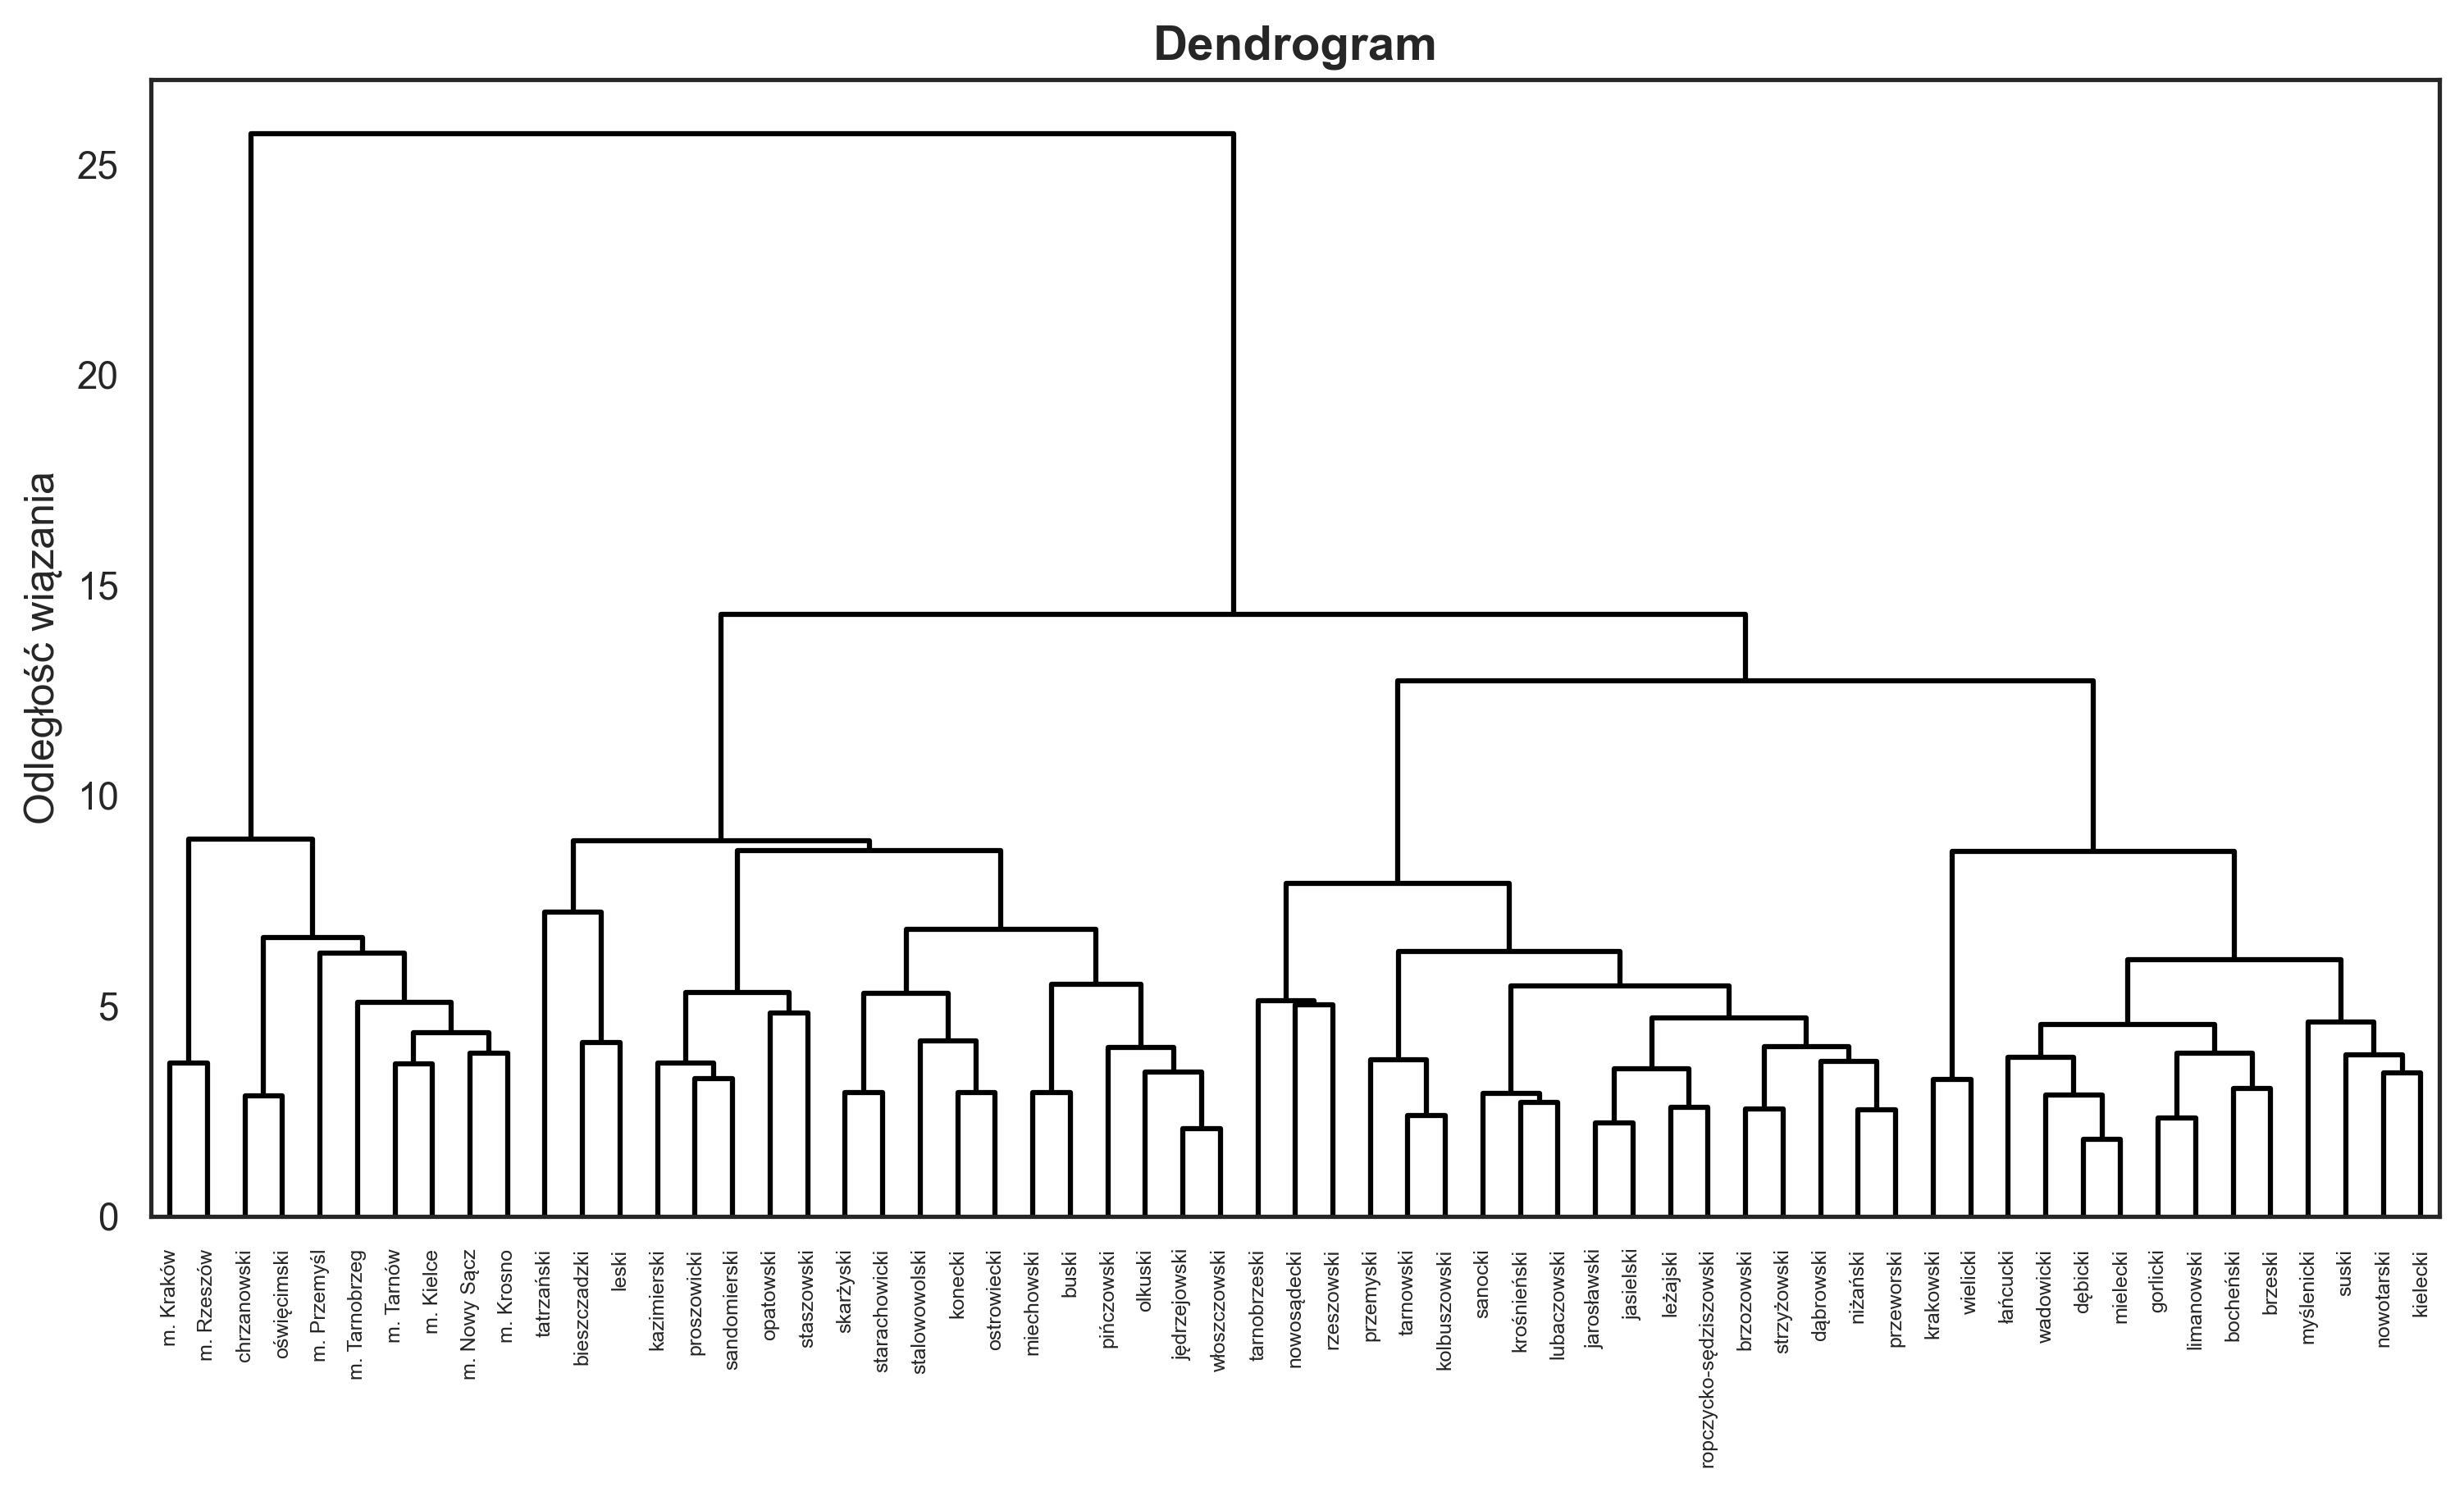

In [35]:
Z = linkage(df_scaled, method='ward')
plt.figure(figsize=(12,6), dpi=300)
dendrogram(Z, labels=df.index, leaf_rotation=90, color_threshold=0, above_threshold_color='black')
plt.title('Dendrogram', fontsize=14, fontweight='bold')
plt.ylabel('Odległość wiązania')
plt.show()

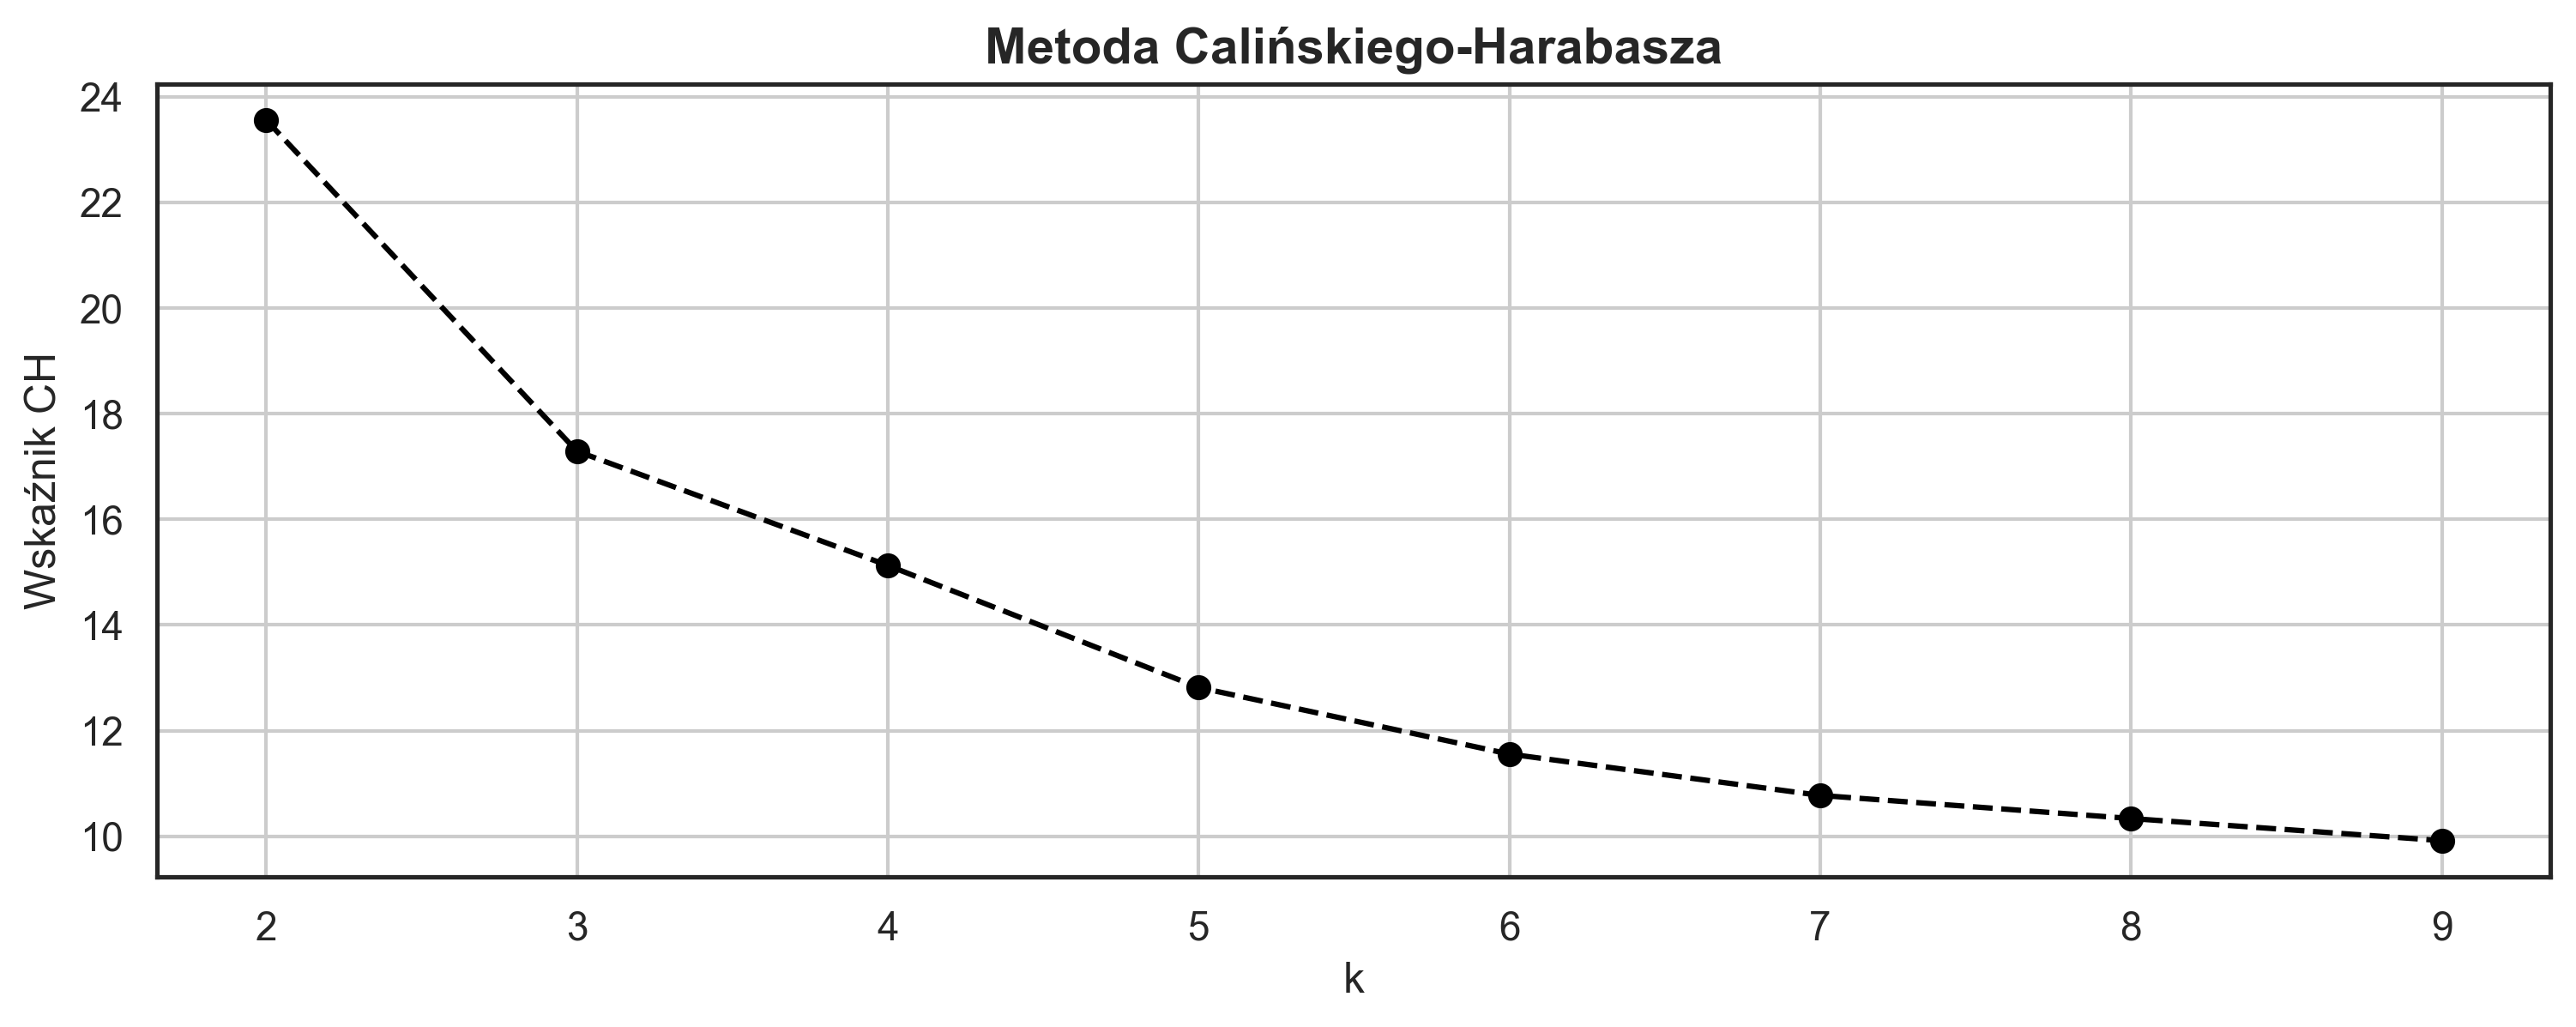

In [36]:
ch_scores = []
K_range = range(2, 10)

for k in K_range:
    labels = fcluster(Z, k, criterion='maxclust')
    ch_scores.append(calinski_harabasz_score(df_scaled, labels))

plt.figure(figsize=(12, 4), dpi=300)
plt.plot(K_range, ch_scores, marker='o', linestyle='--', color="black")
plt.xlabel('k')
plt.ylabel('Wskaźnik CH')
plt.title('Metoda Calińskiego-Harabasza', fontweight='bold', fontsize=14)
plt.xticks(K_range)
plt.grid(True)
plt.show()

Pomimo że najwyższą wartość wskaźnika Calińskiego–Harabasza uzyskano dla podziału na dwa klastry, zdecydowano się na wybór trzech klastrów, aby lepiej uchwycić zróżnicowanie pomiędzy licznymi powiatami i uniknąć nadmiernego uproszczenia.

#### Mapa klastrów

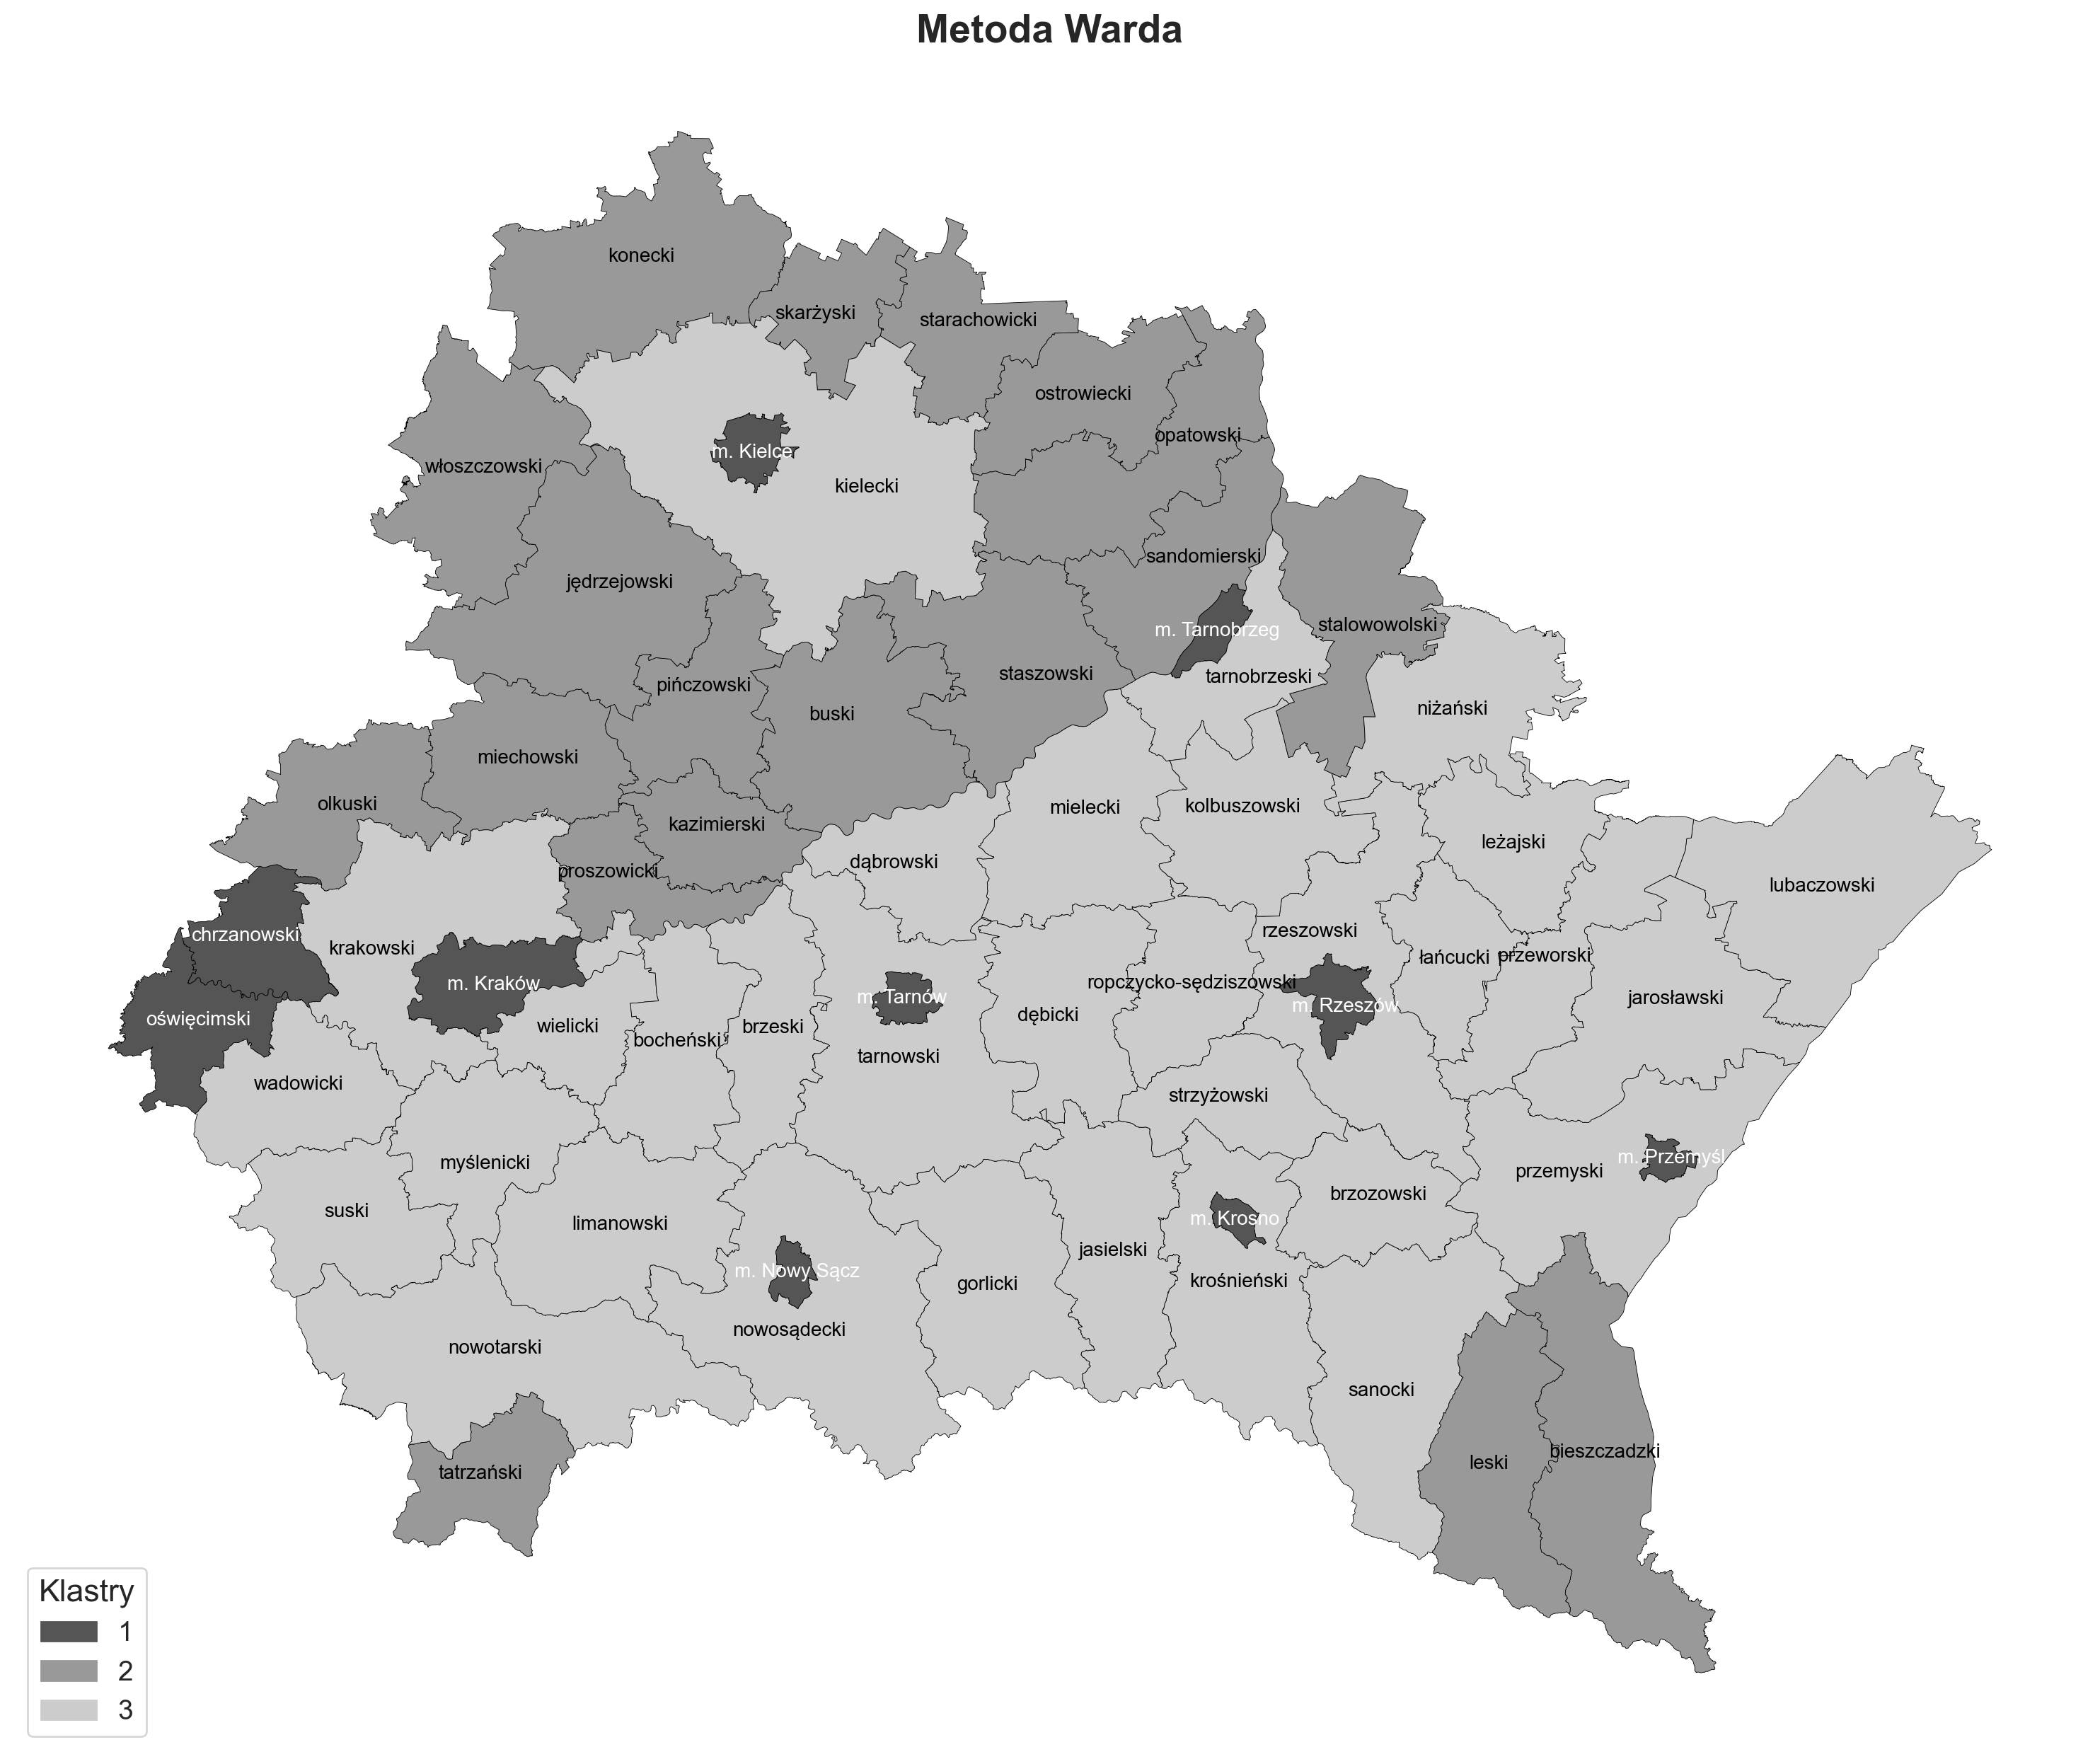

In [37]:
clusters_hier = fcluster(Z, t=3, criterion='maxclust')
df_hier = df.copy()
df_hier['cluster'] = clusters_hier

g = gpd.read_file('A02_Granice_powiatow.shp', encoding='ISO-8859-2')
g['nazwa'] = g['JPT_NAZWA_'].apply(clean)

dm = df_hier.copy()
dm['nazwa'] = dm.index.to_series().apply(clean).replace(mapa_korekcyjna)
dm['nazwa_do_tekstu'] = dm.index

cols = {1:'#555555', 2:'#999999', 3:'#cccccc'}

m = g.merge(dm, on='nazwa').drop_duplicates('nazwa', keep='first')
m['grp'] = m['cluster'].fillna(0).astype(int)
m['kol'] = m['grp'].map(cols).fillna('#eeeeee')

fig, ax = plt.subplots(figsize=(15,15), dpi=200)
m.plot(color=m['kol'], ax=ax, edgecolor='black', linewidth=0.3)

ax.legend(
    handles=[mpatches.Patch(color=cols[g], label=g) for g in [1,2,3]],
    title='Klastry',
    loc='lower left',
    fontsize=14,
    title_fontsize=16
)

manual_offsets = {
    "tarnobrzeski": (-0.05, -0.05),
    "tarnowski": (0.00, -0.05),
    "nowosądecki": (0.00, -0.03),
    "rzeszowski": (0.07, 0.07)
}

for idx, row in m.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    dx, dy = manual_offsets.get(row['nazwa_do_tekstu'], (0, 0))
    text_color = 'white' if row['kol'] == '#555555' else 'black'
    ax.text(x+dx, y+dy, row['nazwa_do_tekstu'], fontsize=10, ha='center', va='center', color=text_color)

ax.set_title('Metoda Warda', fontsize=20, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

#### Statystyki dla klastrów

In [38]:
group1 = df_hier[df_hier['cluster'] == 1].drop(columns='cluster')
desc1 = group1.describe().T[['mean', 'std']]
desc1.columns = ['Średnia', 'Odch. std.']
desc1.columns = pd.MultiIndex.from_product([['Klaster 1'], desc1.columns])

group2 = df_hier[df_hier['cluster'] == 2].drop(columns='cluster')
desc2 = group2.describe().T[['mean', 'std']]
desc2.columns = ['Średnia', 'Odch. std.']
desc2.columns = pd.MultiIndex.from_product([['Klaster 2'], desc2.columns])

group3 = df_hier[df_hier['cluster'] == 3].drop(columns='cluster')
desc3 = group3.describe().T[['mean', 'std']]
desc3.columns = ['Średnia', 'Odch. std.']
desc3.columns = pd.MultiIndex.from_product([['Klaster 3'], desc3.columns])

summary = pd.concat([desc1, desc2, desc3], axis=1)
summary.insert(0, ('', 'Zmienna'), [f"$X_{{{i+1}}}$" for i in range(len(summary))])
summary = summary.round(2)

styler = (
    summary.style
    .hide(axis="index")
    .set_properties(subset=[('', 'Zmienna')], **{'text-align': 'center'})
    .format("{:.2f}", subset=summary.columns[1:])
)
styler

### Wnioski

Porównanie mapy Warda ($k=3$) z mapą k-średnich ($k=4$) pokazuje, że podział na 4 klastry jest w dużej mierze rozwinięciem podziału na 3 klastry – jeden z klastrów metody Warda (klaster 3, obejmujący północny zachód i południowy wschód) został w metodzie k-średnich rozbity na dwie odrębne grupy (klaster 1 i klaster 4). Występuje silna autokorelacja przestrzenna: powiaty grupują się w spójne geograficznie regiony, co potwierdza zasadność podziału. Obie analizy potwierdziły istnienie bardzo stabilnego klastra "zurbanizowanego", skupionego wokół głównych miast (powiaty grockie), który wyróżnia się najwyższymi średnimi wartościami dla większości wskaźników (m.in. $X_2$, $X_{10}$, $X_{13}$). Przeciwieństwie do otrzymanego klastra "peryferyjnego" (klaster 3 w metodach Warda oraz k-średnich), dla którego powiaty charakteryzują się najniższymi wartościami tych wskaźników, ale jednocześnie mają wspólną cechę w postaci bardzo wysokiej średniej dla zmiennej $X_9$, która mówi o liczbie osób przypadających na aptekę.

## Podsumowanie

Powyższa analiza oraz wcześniejsze badania dr. Wolaka opierają się na identycznym zbiorze 19 wskaźników dla powiatów Polski południowo-wschodniej. Zasadnicza różnica w podejściach metodologicznych polega na różnicach w rozwinięciu analizy: w opracowaniu dr. Wolak poszerzono ją o metody porządkowania uwzględniające sąsiedztwo (algorytmy Pietrzaka i Sobolewskiego), podczas gdy w tym badaniu wykorzystano ranking Hellwiga i metodę standaryzowanych sum, a także analizę skupień (metody Warda i k-średnich). Pomimo zbliżonych, ale różnych podejść, wyniki obu analiz są wysoce zbieżne i wzajemnie się potwierdzają, co fundamentalnie wzmacnia ich wiarygodność. Zidentyfikowany klaster "zurbanizowany" dokładnie pokrywa się z jednostkami zajmującymi najwyższe pozycje w rankingu dr. Wolaka, zlokalizowanymi w centralnej i zachodniej Małopolsce. Analogicznie, wyznaczone klastry "peryferyjne" odpowiadają obszarom o najniższym wskaźniku syntetycznym w tamtym badaniu, czyli wschodniej części regionu. Obie metody analizy skupień analizy dowiodły również istnienia silnej autokorelacji przestrzennej warunków życia. Oznacza to, że kondycja powiatu jest silnie powiązana z jego sąsiadami, co prowadzi do tworzenia się wyraźnych geograficznych mikroregionów dobrobytu i stagnacji. Zaletą zastosowanego podejścia klasyfikacyjnego jest możliwość głębszej charakterystyki zidentyfikowanych grup (poprzez wyznaczenie statystyk dla każdego z klastrów). Pozwoliło to na wskazanie specyficznych, wspólnych problemów, jak np. krytycznie niska dostępność do aptek (zmienna $X_9$) w klastrach "peryferyjnych" i wysoka średnia wynagrodzeń ($X_2$) w klastrach "zurbanizowanych".